Data CSV diproses: 23 segmen
Scaler dimuat dari 'processed_data.pkl'
Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 1.
Memuat model terbaik dari fold 1 di best_model_lstm_layer_fold_1.h5



Hasil Prediksi untuk 23 Segmen:
Segmen 1: Probabilitas AF = 0.9884, Prediksi = AF
Segmen 2: Probabilitas AF = 0.9891, Prediksi = AF
Segmen 3: Probabilitas AF = 0.9882, Prediksi = AF
Segmen 4: Probabilitas AF = 0.9879, Prediksi = AF
Segmen 5: Probabilitas AF = 0.9874, Prediksi = AF
Segmen 6: Probabilitas AF = 0.9823, Prediksi = AF
Segmen 7: Probabilitas AF = 0.9887, Prediksi = AF
Segmen 8: Probabilitas AF = 0.9889, Prediksi = AF
Segmen 9: Probabilitas AF = 0.9909, Prediksi = AF
Segmen 10: Probabilitas AF = 0.9901, Prediksi = AF
Segmen 11: Probabilitas AF = 0.9930, Prediksi = AF
Segmen 12: Probabilitas AF = 0.9884, Prediksi = AF
Segmen 13: Probabilitas AF = 0.9876, Prediksi = AF
Segmen 14: Probabilitas AF = 0.9752, Prediksi = AF
Segmen 15: Probabilitas AF = 0.9898, Prediksi = AF
Segmen 16: Probabilitas AF = 0.9724, Prediksi = AF
Segmen 17: Probabilitas AF = 0.9617, Prediksi = AF
Segmen 18: Probabilitas AF = 0.9880, Prediksi = AF
Segmen 19: Probabilitas AF = 0.9827, Prediksi = AF
Segmen 

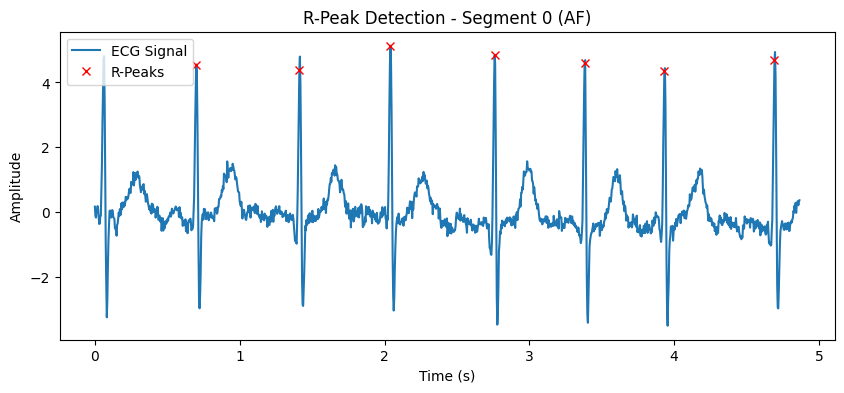

In [2]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
import os
import matplotlib.pyplot as plt
import neurokit2 as nk
from scipy.signal import butter, filtfilt, detrend, iirnotch, resample, welch
from scipy.stats import entropy
import pywt

# Required functions from your original code
def bandpass_filter(signal, lowcut=0.5, highcut=40.0, fs=267, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def notch_filter(signal, freq=50.0, fs=267, quality=30.0):
    b, a = iirnotch(freq, quality, fs)
    return filtfilt(b, a, signal)

def wavelet_denoise(signal, wavelet='db6', level=5):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    threshold = np.std(coeffs[-1]) * np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)

def compute_rr_features(signal, fs=267, use_entropy=True, visualize=False, segment_idx=0, label='unknown'):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    try:
        # Pra-pemrosesan sinyal
        signal_detrended = detrend(signal[:, 0])
        signal_denoised = wavelet_denoise(signal_detrended)
        signal_notched = notch_filter(signal_denoised, freq=50.0, fs=fs)
        signal_filtered = bandpass_filter(signal_notched, lowcut=0.5, highcut=40.0, fs=fs)
        signal_norm = (signal_filtered - np.mean(signal_filtered)) / (np.std(signal_filtered) + 1e-8)
        
        # Bersihkan sinyal dengan NeuroKit
        cleaned = nk.ecg_clean(signal_norm, sampling_rate=fs, method='neurokit')
        
        # Deteksi R-peaks
        rpeaks_info = nk.ecg_findpeaks(cleaned, sampling_rate=fs)
        r_peaks = np.array(rpeaks_info['ECG_R_Peaks'])
        
        # Cek apakah ada R-peaks yang terdeteksi
        if len(r_peaks) < 2:
            print(f"Peringatan: Hanya {len(r_peaks)} puncak R terdeteksi pada segmen {segment_idx}.")
            return None, None, None
        
        # Hitung RR intervals dan fitur lainnya
        rr_intervals = np.diff(r_peaks) / fs * 1000  # Dalam ms
        cv_rr = np.std(rr_intervals) / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        qrs_amplitude = np.max(signal_norm) - np.min(signal_norm)
        bpm = 60000 / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        
        # Hitung entropy
        if use_entropy:
            hist, _ = np.histogram(signal_norm, bins=50, density=True)
            signal_entropy = entropy(hist)
            signal_entropy = (signal_entropy - np.mean(hist)) / (np.std(hist) + 1e-8)
        else:
            freqs, psd = welch(signal_norm, fs=fs, nperseg=256)
            signal_entropy = np.sum(psd)
        
        # Visualisasi jika diaktifkan
        if visualize:
            visualize_r_peaks(cleaned, r_peaks, label, fs, segment_idx)
        
        return rr_intervals, [cv_rr, qrs_amplitude, signal_entropy, bpm], r_peaks
    except Exception as e:
        print(f"Error deteksi puncak R: {e}")
        return None, None, None

def visualize_r_peaks(signal, r_peaks, label, fs=267, segment_idx=0):
    if r_peaks is None or len(r_peaks) == 0:
        print("Tidak ada R-peaks untuk divisualisasikan.")
        return
    plt.figure(figsize=(10, 4))
    t = np.arange(len(signal)) / fs
    plt.plot(t, signal, label='ECG Signal')
    plt.plot(t[r_peaks], signal[r_peaks], 'rx', label='R-Peaks')
    plt.title(f'R-Peak Detection - Segment {segment_idx} ({label})')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.savefig(f'r_peaks_segment_{segment_idx}_{label}.png', dpi=300)
    plt.show()

def augment_signal(signal, noise_factor=0.1):
    noise = np.random.normal(0, noise_factor, signal.shape)
    scaled_signal = signal * np.random.uniform(0.8, 1.2)
    shifted_signal = scaled_signal + np.random.uniform(-0.2, 0.2)
    return shifted_signal + noise

def normalize_signal(signal):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    signal_norm = (signal - np.mean(signal, axis=0)) / (np.std(signal, axis=0) + 1e-8)
    return signal_norm

# Modified function to handle r_peaks_list as a list
def load_and_process_csv(csv_file, segment_length=1300, fs=267):
    # Baca file CSV
    df = pd.read_csv(csv_file)
    
    # Ambil kolom ECG
    signal = df['ECG'].values
    
    # Resample signal jika frekuensi sampling berbeda (misalnya, dari 250 Hz ke 267 Hz)
    original_fs = 250  # Berdasarkan interval 0.004s di CSV
    if original_fs != fs:
        target_samples = int(len(signal) * (fs / original_fs))
        signal = resample(signal, target_samples)
    
    # Pastikan panjang sinyal cukup untuk setidaknya satu segmen
    if len(signal) < segment_length:
        print(f"Panjang sinyal ({len(signal)}) kurang dari {segment_length}. Tidak dapat memproses.")
        return None, None, None
    
    # Inisialisasi array untuk menyimpan segmen
    segments = []
    rr_features_list = []
    r_peaks_list = []
    
    # Proses sinyal menjadi segmen-segmen
    step = int(segment_length * 0.5)  # Overlap seperti pada data pelatihan
    for i in range(0, len(signal) - segment_length, step):
        segment = signal[i:i + segment_length]
        if len(segment) != segment_length:
            continue
        
        # Normalisasi sinyal
        segment_norm = normalize_signal(segment)
        
        # Augmentasi sinyal
        segment_augmented = augment_signal(segment_norm)
        
        # Ekstraksi fitur RR
        rr_intervals, features, r_peaks = compute_rr_features(segment, fs=fs)
        if rr_intervals is None or features is None:
            continue
        
        segments.append(segment_augmented)
        rr_features_list.append(features)
        r_peaks_list.append(r_peaks)  # Keep as list, no np.array conversion
    
    if not segments:
        print("Tidak ada segmen yang valid setelah pemrosesan.")
        return None, None, None
    
    segments = np.array(segments)
    rr_features_list = np.array(rr_features_list)
    
    # Reshape segments ke format (num_samples, 1300, 1)
    segments = segments.reshape(segments.shape[0], segment_length, 1)
    
    return segments, rr_features_list, r_peaks_list

# Fungsi untuk memilih model terbaik
def select_best_model(fold_scores, base_path='best_model_lstm_layer_fold_{}.h5'):
    if not fold_scores:
        # Fallback: Coba fold 1 jika fold_scores kosong
        print("Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 1.")
        best_fold = 1
    else:
        best_fold = np.argmax(fold_scores) + 1  # +1 karena fold dimulai dari 1
    model_path = base_path.format(best_fold)
    if os.path.exists(model_path):
        print(f"Memuat model terbaik dari fold {best_fold} di {model_path}")
        model = load_model(model_path)
        return model, best_fold
    else:
        print(f"Model untuk fold {best_fold} tidak ditemukan di {model_path}")
        return None, None

# Fungsi untuk melakukan prediksi
def predict_with_model(model, scaler, X_test, rr_features_test):
    # Normalkan fitur RR menggunakan scaler yang disimpan
    rr_features_norm = scaler.transform(rr_features_test)
    
    # Lakukan prediksi
    predictions = model.predict([X_test, rr_features_norm], verbose=0)
    predictions_binary = (predictions > 0.5).astype(int).flatten()  # Biner: 0 (Normal) atau 1 (AF)
    
    return predictions, predictions_binary

# Main execution
csv_file = r'D:\Tugas Akhir\Pemodelan\CNN_LSTM\06995_AF.csv'  # Ganti dengan path file CSV kamu
segment_length = 1300
fs = 267

# 1. Muat dan proses data CSV
X_test, rr_features_test, r_peaks_test = load_and_process_csv(csv_file, segment_length, fs)
if X_test is None:
    print("Gagal memproses data CSV. Program dihentikan.")
    exit()

print(f"Data CSV diproses: {X_test.shape[0]} segmen")

# 2. Muat scaler dan data yang disimpan
data_dict = joblib.load('processed_data.pkl')
scaler = data_dict['scaler']
print("Scaler dimuat dari 'processed_data.pkl'")

# 3. Pilih model terbaik berdasarkan fold_scores
fold_scores = []  # Ganti dengan daftar fold_scores dari K-Fold CV
# Contoh: fold_scores = [0.95, 0.92, 0.96, 0.93, 0.94]  # Ganti dengan nilai sebenarnya
model, best_fold = select_best_model(fold_scores)
if model is None:
    print("Gagal memuat model terbaik. Program dihentikan.")
    exit()

# 4. Lakukan prediksi
predictions, predictions_binary = predict_with_model(model, scaler, X_test, rr_features_test)

# 5. Tampilkan hasil prediksi
print(f"\nHasil Prediksi untuk {X_test.shape[0]} Segmen:")
for i, (prob, label) in enumerate(zip(predictions.flatten(), predictions_binary)):
    label_str = 'AF' if label == 1 else 'Normal'
    print(f"Segmen {i+1}: Probabilitas AF = {prob:.4f}, Prediksi = {label_str}")

# 6. Visualisasi sinyal dan R-peaks untuk segmen pertama (opsional)
if X_test.shape[0] > 0:
    label = 'AF' if predictions_binary[0] == 1 else 'Normal'
    visualize_r_peaks(X_test[0].flatten(), r_peaks_test[0], label, fs=fs, segment_idx=0)

Data CSV diproses: 23 segmen
Scaler dimuat dari 'processed_data.pkl'
Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 2.
Memuat model terbaik dari fold 1 di best_model_lstm_layer_fold_2.h5

Hasil Prediksi untuk 23 Segmen:
Segmen 1: Probabilitas AF = 0.5497, Prediksi = AF
Segmen 2: Probabilitas AF = 0.5259, Prediksi = AF
Segmen 3: Probabilitas AF = 0.4403, Prediksi = Normal
Segmen 4: Probabilitas AF = 0.4761, Prediksi = Normal
Segmen 5: Probabilitas AF = 0.4008, Prediksi = Normal
Segmen 6: Probabilitas AF = 0.3607, Prediksi = Normal
Segmen 7: Probabilitas AF = 0.4222, Prediksi = Normal
Segmen 8: Probabilitas AF = 0.3895, Prediksi = Normal
Segmen 9: Probabilitas AF = 0.5414, Prediksi = AF
Segmen 10: Probabilitas AF = 0.5463, Prediksi = AF
Segmen 11: Probabilitas AF = 0.6334, Prediksi = AF
Segmen 12: Probabilitas AF = 0.5181, Prediksi = AF
Segmen 13: Probabilitas AF = 0.4748, Prediksi = Normal
Segmen 14: Probabilitas AF = 0.5187, Prediksi = AF
Segmen 15: Probabilitas AF = 0.

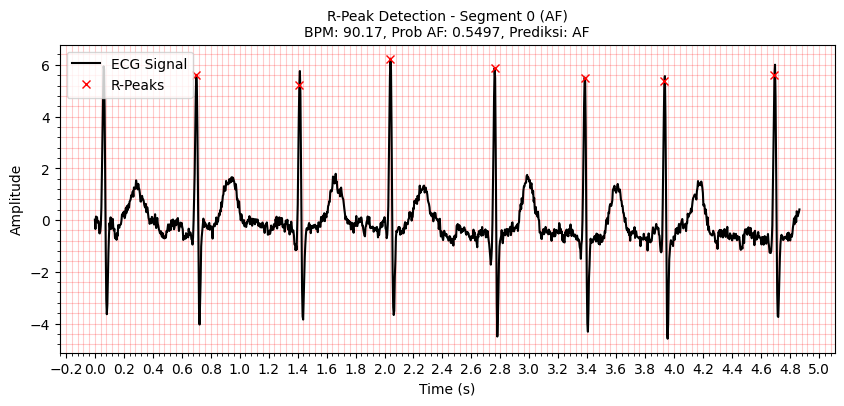

In [16]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker  # Import for AutoMinorLocator
import neurokit2 as nk
from scipy.signal import butter, filtfilt, detrend, iirnotch, resample, welch
from scipy.stats import entropy
import pywt

# Required functions from your original code
def bandpass_filter(signal, lowcut=0.5, highcut=40.0, fs=267, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def notch_filter(signal, freq=50.0, fs=267, quality=30.0):
    b, a = iirnotch(freq, quality, fs)
    return filtfilt(b, a, signal)

def wavelet_denoise(signal, wavelet='db6', level=5):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    threshold = np.std(coeffs[-1]) * np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)

def compute_rr_features(signal, fs=267, use_entropy=True, visualize=False, segment_idx=0, label='unknown'):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    try:
        # Pra-pemrosesan sinyal
        signal_detrended = detrend(signal[:, 0])
        signal_denoised = wavelet_denoise(signal_detrended)
        signal_notched = notch_filter(signal_denoised, freq=50.0, fs=fs)
        signal_filtered = bandpass_filter(signal_notched, lowcut=0.5, highcut=40.0, fs=fs)
        signal_norm = (signal_filtered - np.mean(signal_filtered)) / (np.std(signal_filtered) + 1e-8)
        
        # Bersihkan sinyal dengan NeuroKit
        cleaned = nk.ecg_clean(signal_norm, sampling_rate=fs, method='neurokit')
        
        # Deteksi R-peaks
        rpeaks_info = nk.ecg_findpeaks(cleaned, sampling_rate=fs)
        r_peaks = np.array(rpeaks_info['ECG_R_Peaks'])
        
        # Cek apakah ada R-peaks yang terdeteksi
        if len(r_peaks) < 2:
            print(f"Peringatan: Hanya {len(r_peaks)} puncak R terdeteksi pada segmen {segment_idx}.")
            return None, None, None
        
        # Hitung RR intervals dan fitur lainnya
        rr_intervals = np.diff(r_peaks) / fs * 1000  # Dalam ms
        cv_rr = np.std(rr_intervals) / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        qrs_amplitude = np.max(signal_norm) - np.min(signal_norm)
        bpm = 60000 / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        
        # Hitung entropy
        if use_entropy:
            hist, _ = np.histogram(signal_norm, bins=50, density=True)
            signal_entropy = entropy(hist)
            signal_entropy = (signal_entropy - np.mean(hist)) / (np.std(hist) + 1e-8)
        else:
            freqs, psd = welch(signal_norm, fs=fs, nperseg=256)
            signal_entropy = np.sum(psd)
        
        # Visualisasi jika diaktifkan
        if visualize:
            visualize_r_peaks(cleaned, r_peaks, label, fs, segment_idx)
        
        return rr_intervals, [cv_rr, qrs_amplitude, signal_entropy, bpm], r_peaks
    except Exception as e:
        print(f"Error deteksi puncak R: {e}")
        return None, None, None

def visualize_r_peaks(signal, r_peaks, label, fs=267, segment_idx=0, bpm=None, prob=None):
    if r_peaks is None or len(r_peaks) == 0:
        print("Tidak ada R-peaks untuk divisualisasikan.")
        return
    plt.figure(figsize=(10, 4))
    t = np.arange(len(signal)) / fs
    
    # Plot ECG signal and R-peaks
    plt.plot(t, signal, label='ECG Signal', color='black')
    plt.plot(t[r_peaks], signal[r_peaks], 'rx', label='R-Peaks')
    
    # Set title with BPM, probability, and prediction
    title_str = f'R-Peak Detection - Segment {segment_idx} ({label})'
    if bpm is not None and prob is not None:
        title_str += f'\nBPM: {bpm:.2f}, Prob AF: {prob:.4f}, Prediksi: {label}'
    plt.title(title_str, fontsize=10)
    
    # Add ECG-like grid
    plt.grid(True, which='both', linestyle='-', alpha=0.2, color='red')
    # Minor grid: 0.04 seconds (1 mm at 25 mm/s, ~10.68 samples at 267 Hz)
    plt.minorticks_on()
    plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.04))  # Fixed import
    plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator(5))  # Fixed import
    # Major grid: 0.2 seconds (5 mm at 25 mm/s, ~53.4 samples at 267 Hz)
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    plt.gca().yaxis.set_major_locator(ticker.AutoLocator())
    
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.savefig(f'r_peaks_segment_{segment_idx}_{label}.png', dpi=300)
    plt.show()

def augment_signal(signal, noise_factor=0.1):
    noise = np.random.normal(0, noise_factor, signal.shape)
    scaled_signal = signal * np.random.uniform(0.8, 1.2)
    shifted_signal = scaled_signal + np.random.uniform(-0.2, 0.2)
    return shifted_signal + noise

def normalize_signal(signal):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    signal_norm = (signal - np.mean(signal, axis=0)) / (np.std(signal, axis=0) + 1e-8)
    return signal_norm

def load_and_process_csv(csv_file, segment_length=1300, fs=267):
    # Baca file CSV
    df = pd.read_csv(csv_file)
    
    # Ambil kolom ECG
    signal = df['ECG'].values
    
    # Resample signal jika frekuensi sampling berbeda (misalnya, dari 250 Hz ke 267 Hz)
    original_fs = 250  # Berdasarkan interval 0.004s di CSV
    if original_fs != fs:
        target_samples = int(len(signal) * (fs / original_fs))
        signal = resample(signal, target_samples)
    
    # Pastikan panjang sinyal cukup untuk setidaknya satu segmen
    if len(signal) < segment_length:
        print(f"Panjang sinyal ({len(signal)}) kurang dari {segment_length}. Tidak dapat memproses.")
        return None, None, None
    
    # Inisialisasi array untuk menyimpan segmen
    segments = []
    rr_features_list = []
    r_peaks_list = []
    
    # Proses sinyal menjadi segmen-segmen
    step = int(segment_length * 0.5)  # Overlap seperti pada data pelatihan
    for i in range(0, len(signal) - segment_length, step):
        segment = signal[i:i + segment_length]
        if len(segment) != segment_length:
            continue
        
        # Normalisasi sinyal
        segment_norm = normalize_signal(segment)
        
        # Augmentasi sinyal
        segment_augmented = augment_signal(segment_norm)
        
        # Ekstraksi fitur RR
        rr_intervals, features, r_peaks = compute_rr_features(segment, fs=fs)
        if rr_intervals is None or features is None:
            continue
        
        segments.append(segment_augmented)
        rr_features_list.append(features)
        r_peaks_list.append(r_peaks)  # Keep as list, no np.array conversion
    
    if not segments:
        print("Tidak ada segmen yang valid setelah pemrosesan.")
        return None, None, None
    
    segments = np.array(segments)
    rr_features_list = np.array(rr_features_list)
    
    # Reshape segments ke format (num_samples, 1300, 1)
    segments = segments.reshape(segments.shape[0], segment_length, 1)
    
    return segments, rr_features_list, r_peaks_list

def select_best_model(fold_scores, base_path='best_model_lstm_layer_fold_2.h5'):
    if not fold_scores:
        # Fallback: Coba fold 1 jika fold_scores kosong
        print("Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 2.")
        best_fold = 1
    else:
        best_fold = np.argmax(fold_scores) + 1  # +1 karena fold dimulai dari 1
    model_path = base_path.format(best_fold)
    if os.path.exists(model_path):
        print(f"Memuat model terbaik dari fold {best_fold} di {model_path}")
        model = load_model(model_path)
        return model, best_fold
    else:
        print(f"Model untuk fold {best_fold} tidak ditemukan di {model_path}")
        return None, None

def predict_with_model(model, scaler, X_test, rr_features_test):
    # Normalkan fitur RR menggunakan scaler yang disimpan
    rr_features_norm = scaler.transform(rr_features_test)
    
    # Lakukan prediksi
    predictions = model.predict([X_test, rr_features_norm], verbose=0)
    predictions_binary = (predictions > 0.5).astype(int).flatten()  # Biner: 0 (Normal) atau 1 (AF)
    
    return predictions, predictions_binary

# Main execution
csv_file = r'D:\Tugas Akhir\Pemodelan\CNN_LSTM\06995_AF.csv'  # Ganti dengan path file CSV kamu
segment_length = 1300
fs = 267

# 1. Muat dan proses data CSV
X_test, rr_features_test, r_peaks_test = load_and_process_csv(csv_file, segment_length, fs)
if X_test is None:
    print("Gagal memproses data CSV. Program dihentikan.")
    exit()

print(f"Data CSV diproses: {X_test.shape[0]} segmen")

# 2. Muat scaler dan data yang disimpan
data_dict = joblib.load('processed_data.pkl')
scaler = data_dict['scaler']
print("Scaler dimuat dari 'processed_data.pkl'")

# 3. Pilih model terbaik berdasarkan fold_scores
fold_scores = []  # Ganti dengan daftar fold_scores dari K-Fold CV
# Contoh: fold_scores = [0.95, 0.92, 0.96, 0.93, 0.94]  # Ganti dengan nilai sebenarnya
model, best_fold = select_best_model(fold_scores)
if model is None:
    print("Gagal memuat model terbaik. Program dihentikan.")
    exit()

# 4. Lakukan prediksi
predictions, predictions_binary = predict_with_model(model, scaler, X_test, rr_features_test)

# 5. Tampilkan hasil prediksi
print(f"\nHasil Prediksi untuk {X_test.shape[0]} Segmen:")
for i, (prob, label) in enumerate(zip(predictions.flatten(), predictions_binary)):
    label_str = 'AF' if label == 1 else 'Normal'
    print(f"Segmen {i+1}: Probabilitas AF = {prob:.4f}, Prediksi = {label_str}")

# 6. Visualisasi sinyal dan R-peaks untuk segmen pertama (opsional)
if X_test.shape[0] > 0:
    label = 'AF' if predictions_binary[0] == 1 else 'Normal'
    bpm = rr_features_test[0][3]  # BPM is the 4th feature in rr_features_test
    prob = predictions[0][0]  # Probability for the first segment
    visualize_r_peaks(X_test[0].flatten(), r_peaks_test[0], label, fs=fs, segment_idx=0, bpm=bpm, prob=prob)

Data CSV diproses: 27 segmen
RR Features for Segment 0: [4.40853382e-02 1.03152380e+01 1.19565367e+01 6.43373494e+01]
Scaler dimuat dari 'processed_data.pkl'
Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 2.
Memuat model terbaik dari fold 1 di best_model_lstm_layer_fold_2.h5

Hasil Prediksi untuk 27 Segmen:
Segmen 1: Probabilitas AF = 0.4010, Prediksi = Normal
Segmen 2: Probabilitas AF = 0.3580, Prediksi = Normal
Segmen 3: Probabilitas AF = 0.2993, Prediksi = Normal
Segmen 4: Probabilitas AF = 0.3529, Prediksi = Normal
Segmen 5: Probabilitas AF = 0.3742, Prediksi = Normal
Segmen 6: Probabilitas AF = 0.3833, Prediksi = Normal
Segmen 7: Probabilitas AF = 0.1981, Prediksi = Normal
Segmen 8: Probabilitas AF = 0.3710, Prediksi = Normal
Segmen 9: Probabilitas AF = 0.4326, Prediksi = Normal
Segmen 10: Probabilitas AF = 0.3404, Prediksi = Normal
Segmen 11: Probabilitas AF = 0.5808, Prediksi = Normal
Segmen 12: Probabilitas AF = 0.3190, Prediksi = Normal
Segmen 13: Probabilitas 

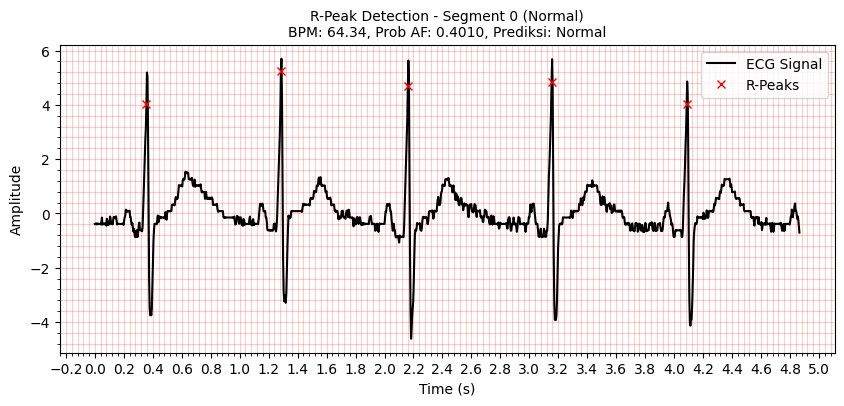

In [14]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import neurokit2 as nk
from scipy.signal import butter, filtfilt, detrend, iirnotch, resample, welch
from scipy.stats import entropy
import pywt

# Required functions (unchanged except for debugging options)
def bandpass_filter(signal, lowcut=0.5, highcut=40.0, fs=267, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def notch_filter(signal, freq=50.0, fs=267, quality=30.0):
    b, a = iirnotch(freq, quality, fs)
    return filtfilt(b, a, signal)

def wavelet_denoise(signal, wavelet='db6', level=5):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    threshold = np.std(coeffs[-1]) * np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)

def compute_rr_features(signal, fs=267, use_entropy=True, visualize=False, segment_idx=0, label='unknown'):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    try:
        signal_detrended = detrend(signal[:, 0])
        signal_denoised = wavelet_denoise(signal_detrended)
        signal_notched = notch_filter(signal_denoised, freq=50.0, fs=fs)
        signal_filtered = bandpass_filter(signal_notched, lowcut=0.5, highcut=40.0, fs=fs)
        signal_norm = (signal_filtered - np.mean(signal_filtered)) / (np.std(signal_filtered) + 1e-8)
        cleaned = nk.ecg_clean(signal_norm, sampling_rate=fs, method='neurokit')
        rpeaks_info = nk.ecg_findpeaks(cleaned, sampling_rate=fs)
        r_peaks = np.array(rpeaks_info['ECG_R_Peaks'])
        if len(r_peaks) < 2:
            print(f"Peringatan: Hanya {len(r_peaks)} puncak R terdeteksi pada segmen {segment_idx}.")
            return None, None, None
        rr_intervals = np.diff(r_peaks) / fs * 1000
        cv_rr = np.std(rr_intervals) / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        qrs_amplitude = np.max(signal_norm) - np.min(signal_norm)
        bpm = 60000 / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        if use_entropy:
            hist, _ = np.histogram(signal_norm, bins=50, density=True)
            signal_entropy = entropy(hist)
            signal_entropy = (signal_entropy - np.mean(hist)) / (np.std(hist) + 1e-8)
        else:
            freqs, psd = welch(signal_norm, fs=fs, nperseg=256)
            signal_entropy = np.sum(psd)
        if visualize:
            visualize_r_peaks(cleaned, r_peaks, label, fs, segment_idx)
        return rr_intervals, [cv_rr, qrs_amplitude, signal_entropy, bpm], r_peaks
    except Exception as e:
        print(f"Error deteksi puncak R: {e}")
        return None, None, None

def visualize_r_peaks(signal, r_peaks, label, fs=267, segment_idx=0, bpm=None, prob=None):
    if r_peaks is None or len(r_peaks) == 0:
        print("Tidak ada R-peaks untuk divisualisasikan.")
        return
    plt.figure(figsize=(10, 4))
    t = np.arange(len(signal)) / fs
    plt.plot(t, signal, label='ECG Signal', color='black')
    plt.plot(t[r_peaks], signal[r_peaks], 'rx', label='R-Peaks')
    title_str = f'R-Peak Detection - Segment {segment_idx} ({label})'
    if bpm is not None and prob is not None:
        title_str += f'\nBPM: {bpm:.2f}, Prob AF: {prob:.4f}, Prediksi: {label}'
    plt.title(title_str, fontsize=10)
    plt.grid(True, which='both', linestyle='-', alpha=0.2, color='red')
    plt.minorticks_on()
    plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.04))
    plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    plt.gca().yaxis.set_major_locator(ticker.AutoLocator())
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.savefig(f'r_peaks_segment_{segment_idx}_{label}.png', dpi=300)
    plt.show()

def augment_signal(signal, noise_factor=0.1):
    noise = np.random.normal(0, noise_factor, signal.shape)
    scaled_signal = signal * np.random.uniform(0.8, 1.2)
    shifted_signal = scaled_signal + np.random.uniform(-0.2, 0.2)
    return shifted_signal + noise

def normalize_signal(signal):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    signal_norm = (signal - np.mean(signal, axis=0)) / (np.std(signal, axis=0) + 1e-8)
    return signal_norm

def load_and_process_csv(csv_file, segment_length=1300, fs=267, disable_augmentation=False):
    df = pd.read_csv(csv_file)
    signal = df['ECG'].values
    original_fs = 250  # Based on 0.004s interval
    if original_fs != fs:
        target_samples = int(len(signal) * (fs / original_fs))
        signal = resample(signal, target_samples)
    if len(signal) < segment_length:
        print(f"Panjang sinyal ({len(signal)}) kurang dari {segment_length}. Tidak dapat memroses.")
        return None, None, None
    segments, rr_features_list, r_peaks_list = [], [], []
    step = int(segment_length * 0.5)
    for i in range(0, len(signal) - segment_length, step):
        segment = signal[i:i + segment_length]
        if len(segment) != segment_length:
            continue
        segment_norm = normalize_signal(segment)
        segment_augmented = segment_norm if disable_augmentation else augment_signal(segment_norm)
        rr_intervals, features, r_peaks = compute_rr_features(segment, fs=fs)
        if rr_intervals is None or features is None:
            continue
        segments.append(segment_augmented)
        rr_features_list.append(features)
        r_peaks_list.append(r_peaks)
    if not segments:
        print("Tidak ada segmen yang valid setelah pemrosesan.")
        return None, None, None
    segments = np.array(segments)
    rr_features_list = np.array(rr_features_list)
    segments = segments.reshape(segments.shape[0], segment_length, 1)
    return segments, rr_features_list, r_peaks_list

def select_best_model(fold_scores, base_path='best_model_lstm_layer_fold_2.h5'):
    if not fold_scores:
        print("Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 2.")
        best_fold = 1
    else:
        best_fold = np.argmax(fold_scores) + 1
    model_path = base_path.format(best_fold)
    if os.path.exists(model_path):
        print(f"Memuat model terbaik dari fold {best_fold} di {model_path}")
        model = load_model(model_path)
        return model, best_fold
    else:
        print(f"Model untuk fold {best_fold} tidak ditemukan di {model_path}")
        return None, None

def predict_with_model(model, scaler, X_test, rr_features_test, threshold=0.5):
    rr_features_norm = scaler.transform(rr_features_test)
    predictions = model.predict([X_test, rr_features_norm], verbose=0)
    predictions_binary = (predictions > threshold).astype(int).flatten()
    return predictions, predictions_binary

# Main execution
csv_file = r'D:\Tugas Akhir\Pemodelan\CNN_LSTM\Berdiri.csv'  # Ganti dengan path file CSV kamu
segment_length = 1300
fs = 267

# 1. Muat dan proses data CSV with debugging option
X_test, rr_features_test, r_peaks_test = load_and_process_csv(csv_file, segment_length, fs, disable_augmentation=True)
if X_test is None:
    print("Gagal memroses data CSV. Program dihentikan.")
    exit()

print(f"Data CSV diproses: {X_test.shape[0]} segmen")
print(f"RR Features for Segment 0: {rr_features_test[0]}")  # Debug RR features

# 2. Muat scaler dan data yang disimpan
data_dict = joblib.load('processed_data.pkl')
scaler = data_dict['scaler']
print("Scaler dimuat dari 'processed_data.pkl'")

# 3. Pilih model terbaik berdasarkan fold_scores
fold_scores = []  # Ganti dengan daftar fold_scores dari K-Fold CV
# Contoh: fold_scores = [0.95, 0.92, 0.96, 0.93, 0.94]
model, best_fold = select_best_model(fold_scores)
if model is None:
    print("Gagal memuat model terbaik. Program dihentikan.")
    exit()

# 4. Lakukan prediksi with adjustable threshold
predictions, predictions_binary = predict_with_model(model, scaler, X_test, rr_features_test, threshold=0.7)

# 5. Tampilkan hasil prediksi
print(f"\nHasil Prediksi untuk {X_test.shape[0]} Segmen:")
for i, (prob, label) in enumerate(zip(predictions.flatten(), predictions_binary)):
    label_str = 'AF' if label == 1 else 'Normal'
    print(f"Segmen {i+1}: Probabilitas AF = {prob:.4f}, Prediksi = {label_str}")

# 6. Visualisasi sinyal dan R-peaks untuk segmen pertama
if X_test.shape[0] > 0:
    label = 'AF' if predictions_binary[0] == 1 else 'Normal'
    bpm = rr_features_test[0][3]
    prob = predictions[0][0]
    visualize_r_peaks(X_test[0].flatten(), r_peaks_test[0], label, fs=fs, segment_idx=0, bpm=bpm, prob=prob)

Data CSV diproses: 28 segmen
RR Features for Segment 0: [5.37383091e-02 9.12422355e+00 7.69935679e+00 6.44020101e+01]
Scaler dimuat dari 'processed_data.pkl'
Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 2.
Memuat model terbaik dari fold 1 di best_model_lstm_layer_fold_2.h5

Hasil Prediksi untuk 28 Segmen:
Segmen 1: Probabilitas AF = 0.6723, Prediksi = Normal
Segmen 2: Probabilitas AF = 0.5841, Prediksi = Normal
Segmen 3: Probabilitas AF = 0.6787, Prediksi = Normal
Segmen 4: Probabilitas AF = 0.5092, Prediksi = Normal
Segmen 5: Probabilitas AF = 0.6253, Prediksi = Normal
Segmen 6: Probabilitas AF = 0.5889, Prediksi = Normal
Segmen 7: Probabilitas AF = 0.5357, Prediksi = Normal
Segmen 8: Probabilitas AF = 0.6458, Prediksi = Normal
Segmen 9: Probabilitas AF = 0.5976, Prediksi = Normal
Segmen 10: Probabilitas AF = 0.6239, Prediksi = Normal
Segmen 11: Probabilitas AF = 0.5667, Prediksi = Normal
Segmen 12: Probabilitas AF = 0.5719, Prediksi = Normal
Segmen 13: Probabilitas 

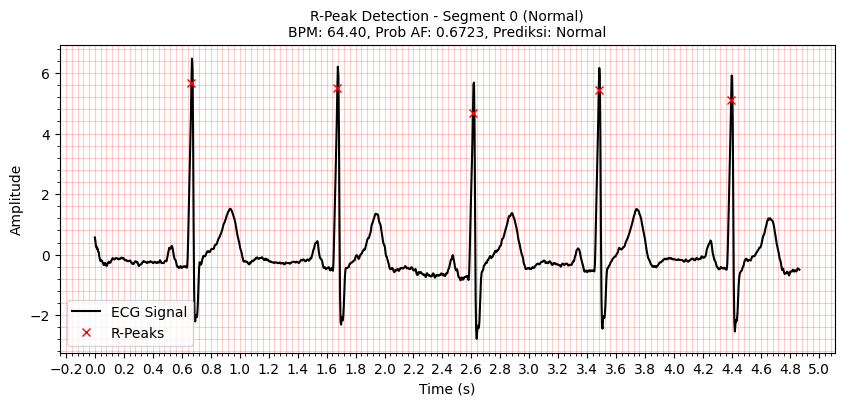

In [15]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import neurokit2 as nk
from scipy.signal import butter, filtfilt, detrend, iirnotch, resample, welch
from scipy.stats import entropy
import pywt

# Required functions (unchanged except for debugging options)
def bandpass_filter(signal, lowcut=0.5, highcut=40.0, fs=267, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def notch_filter(signal, freq=50.0, fs=267, quality=30.0):
    b, a = iirnotch(freq, quality, fs)
    return filtfilt(b, a, signal)

def wavelet_denoise(signal, wavelet='db6', level=5):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    threshold = np.std(coeffs[-1]) * np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)

def compute_rr_features(signal, fs=267, use_entropy=True, visualize=False, segment_idx=0, label='unknown'):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    try:
        signal_detrended = detrend(signal[:, 0])
        signal_denoised = wavelet_denoise(signal_detrended)
        signal_notched = notch_filter(signal_denoised, freq=50.0, fs=fs)
        signal_filtered = bandpass_filter(signal_notched, lowcut=0.5, highcut=40.0, fs=fs)
        signal_norm = (signal_filtered - np.mean(signal_filtered)) / (np.std(signal_filtered) + 1e-8)
        cleaned = nk.ecg_clean(signal_norm, sampling_rate=fs, method='neurokit')
        rpeaks_info = nk.ecg_findpeaks(cleaned, sampling_rate=fs)
        r_peaks = np.array(rpeaks_info['ECG_R_Peaks'])
        if len(r_peaks) < 2:
            print(f"Peringatan: Hanya {len(r_peaks)} puncak R terdeteksi pada segmen {segment_idx}.")
            return None, None, None
        rr_intervals = np.diff(r_peaks) / fs * 1000
        cv_rr = np.std(rr_intervals) / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        qrs_amplitude = np.max(signal_norm) - np.min(signal_norm)
        bpm = 60000 / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        if use_entropy:
            hist, _ = np.histogram(signal_norm, bins=50, density=True)
            signal_entropy = entropy(hist)
            signal_entropy = (signal_entropy - np.mean(hist)) / (np.std(hist) + 1e-8)
        else:
            freqs, psd = welch(signal_norm, fs=fs, nperseg=256)
            signal_entropy = np.sum(psd)
        if visualize:
            visualize_r_peaks(cleaned, r_peaks, label, fs, segment_idx)
        return rr_intervals, [cv_rr, qrs_amplitude, signal_entropy, bpm], r_peaks
    except Exception as e:
        print(f"Error deteksi puncak R: {e}")
        return None, None, None

def visualize_r_peaks(signal, r_peaks, label, fs=267, segment_idx=0, bpm=None, prob=None):
    if r_peaks is None or len(r_peaks) == 0:
        print("Tidak ada R-peaks untuk divisualisasikan.")
        return
    plt.figure(figsize=(10, 4))
    t = np.arange(len(signal)) / fs
    plt.plot(t, signal, label='ECG Signal', color='black')
    plt.plot(t[r_peaks], signal[r_peaks], 'rx', label='R-Peaks')
    title_str = f'R-Peak Detection - Segment {segment_idx} ({label})'
    if bpm is not None and prob is not None:
        title_str += f'\nBPM: {bpm:.2f}, Prob AF: {prob:.4f}, Prediksi: {label}'
    plt.title(title_str, fontsize=10)
    plt.grid(True, which='both', linestyle='-', alpha=0.2, color='red')
    plt.minorticks_on()
    plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.04))
    plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    plt.gca().yaxis.set_major_locator(ticker.AutoLocator())
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.savefig(f'r_peaks_segment_{segment_idx}_{label}.png', dpi=300)
    plt.show()

def augment_signal(signal, noise_factor=0.1):
    noise = np.random.normal(0, noise_factor, signal.shape)
    scaled_signal = signal * np.random.uniform(0.8, 1.2)
    shifted_signal = scaled_signal + np.random.uniform(-0.2, 0.2)
    return shifted_signal + noise

def normalize_signal(signal):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    signal_norm = (signal - np.mean(signal, axis=0)) / (np.std(signal, axis=0) + 1e-8)
    return signal_norm

def load_and_process_csv(csv_file, segment_length=1300, fs=267, disable_augmentation=False):
    df = pd.read_csv(csv_file)
    signal = df['ECG'].values
    original_fs = 250  # Based on 0.004s interval
    if original_fs != fs:
        target_samples = int(len(signal) * (fs / original_fs))
        signal = resample(signal, target_samples)
    if len(signal) < segment_length:
        print(f"Panjang sinyal ({len(signal)}) kurang dari {segment_length}. Tidak dapat memroses.")
        return None, None, None
    segments, rr_features_list, r_peaks_list = [], [], []
    step = int(segment_length * 0.5)
    for i in range(0, len(signal) - segment_length, step):
        segment = signal[i:i + segment_length]
        if len(segment) != segment_length:
            continue
        segment_norm = normalize_signal(segment)
        segment_augmented = segment_norm if disable_augmentation else augment_signal(segment_norm)
        rr_intervals, features, r_peaks = compute_rr_features(segment, fs=fs)
        if rr_intervals is None or features is None:
            continue
        segments.append(segment_augmented)
        rr_features_list.append(features)
        r_peaks_list.append(r_peaks)
    if not segments:
        print("Tidak ada segmen yang valid setelah pemrosesan.")
        return None, None, None
    segments = np.array(segments)
    rr_features_list = np.array(rr_features_list)
    segments = segments.reshape(segments.shape[0], segment_length, 1)
    return segments, rr_features_list, r_peaks_list

def select_best_model(fold_scores, base_path='best_model_lstm_layer_fold_2.h5'):
    if not fold_scores:
        print("Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 2.")
        best_fold = 1
    else:
        best_fold = np.argmax(fold_scores) + 1
    model_path = base_path.format(best_fold)
    if os.path.exists(model_path):
        print(f"Memuat model terbaik dari fold {best_fold} di {model_path}")
        model = load_model(model_path)
        return model, best_fold
    else:
        print(f"Model untuk fold {best_fold} tidak ditemukan di {model_path}")
        return None, None

def predict_with_model(model, scaler, X_test, rr_features_test, threshold=0.5):
    rr_features_norm = scaler.transform(rr_features_test)
    predictions = model.predict([X_test, rr_features_norm], verbose=0)
    predictions_binary = (predictions > threshold).astype(int).flatten()
    return predictions, predictions_binary

# Main execution
csv_file = r'D:\Tugas Akhir\Pemodelan\CNN_LSTM\Recording Perbandingan\11.csv'  # Ganti dengan path file CSV kamu
segment_length = 1300
fs = 267

# 1. Muat dan proses data CSV with debugging option
X_test, rr_features_test, r_peaks_test = load_and_process_csv(csv_file, segment_length, fs, disable_augmentation=True)
if X_test is None:
    print("Gagal memroses data CSV. Program dihentikan.")
    exit()

print(f"Data CSV diproses: {X_test.shape[0]} segmen")
print(f"RR Features for Segment 0: {rr_features_test[0]}")  # Debug RR features

# 2. Muat scaler dan data yang disimpan
data_dict = joblib.load('processed_data.pkl')
scaler = data_dict['scaler']
print("Scaler dimuat dari 'processed_data.pkl'")

# 3. Pilih model terbaik berdasarkan fold_scores
fold_scores = []  # Ganti dengan daftar fold_scores dari K-Fold CV
# Contoh: fold_scores = [0.95, 0.92, 0.96, 0.93, 0.94]
model, best_fold = select_best_model(fold_scores)
if model is None:
    print("Gagal memuat model terbaik. Program dihentikan.")
    exit()

# 4. Lakukan prediksi with adjustable threshold
predictions, predictions_binary = predict_with_model(model, scaler, X_test, rr_features_test, threshold=0.7)

# 5. Tampilkan hasil prediksi
print(f"\nHasil Prediksi untuk {X_test.shape[0]} Segmen:")
for i, (prob, label) in enumerate(zip(predictions.flatten(), predictions_binary)):
    label_str = 'AF' if label == 1 else 'Normal'
    print(f"Segmen {i+1}: Probabilitas AF = {prob:.4f}, Prediksi = {label_str}")

# 6. Visualisasi sinyal dan R-peaks untuk segmen pertama
if X_test.shape[0] > 0:
    label = 'AF' if predictions_binary[0] == 1 else 'Normal'
    bpm = rr_features_test[0][3]
    prob = predictions[0][0]
    visualize_r_peaks(X_test[0].flatten(), r_peaks_test[0], label, fs=fs, segment_idx=0, bpm=bpm, prob=prob)

Data CSV diproses: 1721 segmen
RR Features for Segment 0: [1.18052892e-02 8.51938969e+00 1.65778738e+01 1.21134216e+02]
Scaler dimuat dari 'processed_data.pkl'
Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 2.
Memuat model terbaik dari fold 1 di best_model_lstm_layer_fold_2.h5



Hasil Prediksi untuk 1721 Segmen:
Segmen 1: Probabilitas AF = 0.1807, Prediksi = Normal
Segmen 2: Probabilitas AF = 0.2109, Prediksi = Normal
Segmen 3: Probabilitas AF = 0.2624, Prediksi = Normal
Segmen 4: Probabilitas AF = 0.3370, Prediksi = Normal
Segmen 5: Probabilitas AF = 0.2441, Prediksi = Normal
Segmen 6: Probabilitas AF = 0.2296, Prediksi = Normal
Segmen 7: Probabilitas AF = 0.2642, Prediksi = Normal
Segmen 8: Probabilitas AF = 0.2697, Prediksi = Normal
Segmen 9: Probabilitas AF = 0.2269, Prediksi = Normal
Segmen 10: Probabilitas AF = 0.2329, Prediksi = Normal
Segmen 11: Probabilitas AF = 0.2412, Prediksi = Normal
Segmen 12: Probabilitas AF = 0.2276, Prediksi = Normal
Segmen 13: Probabilitas AF = 0.1844, Prediksi = Normal
Segmen 14: Probabilitas AF = 0.1609, Prediksi = Normal
Segmen 15: Probabilitas AF = 0.1684, Prediksi = Normal
Segmen 16: Probabilitas AF = 0.1356, Prediksi = Normal
Segmen 17: Probabilitas AF = 0.1921, Prediksi = Normal
Segmen 18: Probabilitas AF = 0.1716, Pr

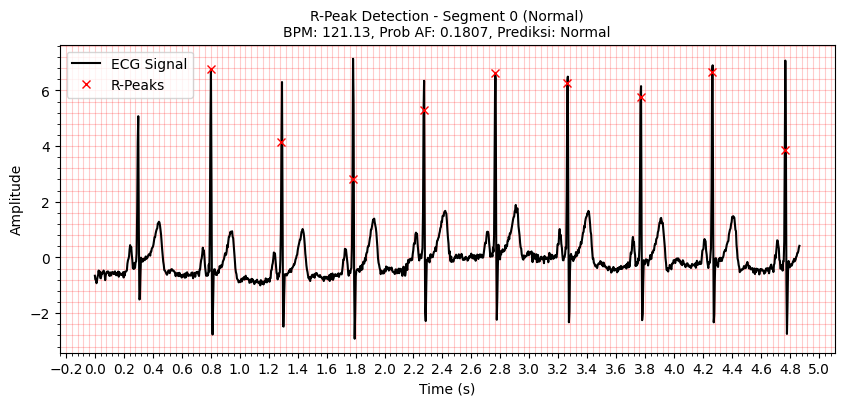

In [18]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import neurokit2 as nk
from scipy.signal import butter, filtfilt, detrend, iirnotch, resample, welch
from scipy.stats import entropy
import pywt

# Required functions (unchanged except for debugging options)
def bandpass_filter(signal, lowcut=0.5, highcut=40.0, fs=267, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def notch_filter(signal, freq=50.0, fs=267, quality=30.0):
    b, a = iirnotch(freq, quality, fs)
    return filtfilt(b, a, signal)

def wavelet_denoise(signal, wavelet='db6', level=5):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    threshold = np.std(coeffs[-1]) * np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)

def compute_rr_features(signal, fs=267, use_entropy=True, visualize=False, segment_idx=0, label='unknown'):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    try:
        signal_detrended = detrend(signal[:, 0])
        signal_denoised = wavelet_denoise(signal_detrended)
        signal_notched = notch_filter(signal_denoised, freq=50.0, fs=fs)
        signal_filtered = bandpass_filter(signal_notched, lowcut=0.5, highcut=40.0, fs=fs)
        signal_norm = (signal_filtered - np.mean(signal_filtered)) / (np.std(signal_filtered) + 1e-8)
        cleaned = nk.ecg_clean(signal_norm, sampling_rate=fs, method='neurokit')
        rpeaks_info = nk.ecg_findpeaks(cleaned, sampling_rate=fs)
        r_peaks = np.array(rpeaks_info['ECG_R_Peaks'])
        if len(r_peaks) < 2:
            print(f"Peringatan: Hanya {len(r_peaks)} puncak R terdeteksi pada segmen {segment_idx}.")
            return None, None, None
        rr_intervals = np.diff(r_peaks) / fs * 1000
        cv_rr = np.std(rr_intervals) / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        qrs_amplitude = np.max(signal_norm) - np.min(signal_norm)
        bpm = 60000 / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        if use_entropy:
            hist, _ = np.histogram(signal_norm, bins=50, density=True)
            signal_entropy = entropy(hist)
            signal_entropy = (signal_entropy - np.mean(hist)) / (np.std(hist) + 1e-8)
        else:
            freqs, psd = welch(signal_norm, fs=fs, nperseg=256)
            signal_entropy = np.sum(psd)
        if visualize:
            visualize_r_peaks(cleaned, r_peaks, label, fs, segment_idx)
        return rr_intervals, [cv_rr, qrs_amplitude, signal_entropy, bpm], r_peaks
    except Exception as e:
        print(f"Error deteksi puncak R: {e}")
        return None, None, None

def visualize_r_peaks(signal, r_peaks, label, fs=267, segment_idx=0, bpm=None, prob=None):
    if r_peaks is None or len(r_peaks) == 0:
        print("Tidak ada R-peaks untuk divisualisasikan.")
        return
    plt.figure(figsize=(10, 4))
    t = np.arange(len(signal)) / fs
    plt.plot(t, signal, label='ECG Signal', color='black')
    plt.plot(t[r_peaks], signal[r_peaks], 'rx', label='R-Peaks')
    title_str = f'R-Peak Detection - Segment {segment_idx} ({label})'
    if bpm is not None and prob is not None:
        title_str += f'\nBPM: {bpm:.2f}, Prob AF: {prob:.4f}, Prediksi: {label}'
    plt.title(title_str, fontsize=10)
    plt.grid(True, which='both', linestyle='-', alpha=0.2, color='red')
    plt.minorticks_on()
    plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.04))
    plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    plt.gca().yaxis.set_major_locator(ticker.AutoLocator())
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.savefig(f'r_peaks_segment_{segment_idx}_{label}.png', dpi=300)
    plt.show()

def augment_signal(signal, noise_factor=0.1):
    noise = np.random.normal(0, noise_factor, signal.shape)
    scaled_signal = signal * np.random.uniform(0.8, 1.2)
    shifted_signal = scaled_signal + np.random.uniform(-0.2, 0.2)
    return shifted_signal + noise

def normalize_signal(signal):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    signal_norm = (signal - np.mean(signal, axis=0)) / (np.std(signal, axis=0) + 1e-8)
    return signal_norm

def load_and_process_csv(csv_file, segment_length=1300, fs=267, disable_augmentation=False):
    df = pd.read_csv(csv_file)
    signal = df['ECG'].values
    original_fs = 250  # Based on 0.004s interval
    if original_fs != fs:
        target_samples = int(len(signal) * (fs / original_fs))
        signal = resample(signal, target_samples)
    if len(signal) < segment_length:
        print(f"Panjang sinyal ({len(signal)}) kurang dari {segment_length}. Tidak dapat memroses.")
        return None, None, None
    segments, rr_features_list, r_peaks_list = [], [], []
    step = int(segment_length * 0.5)
    for i in range(0, len(signal) - segment_length, step):
        segment = signal[i:i + segment_length]
        if len(segment) != segment_length:
            continue
        segment_norm = normalize_signal(segment)
        segment_augmented = segment_norm if disable_augmentation else augment_signal(segment_norm)
        rr_intervals, features, r_peaks = compute_rr_features(segment, fs=fs)
        if rr_intervals is None or features is None:
            continue
        segments.append(segment_augmented)
        rr_features_list.append(features)
        r_peaks_list.append(r_peaks)
    if not segments:
        print("Tidak ada segmen yang valid setelah pemrosesan.")
        return None, None, None
    segments = np.array(segments)
    rr_features_list = np.array(rr_features_list)
    segments = segments.reshape(segments.shape[0], segment_length, 1)
    return segments, rr_features_list, r_peaks_list

def select_best_model(fold_scores, base_path='best_model_lstm_layer_fold_2.h5'):
    if not fold_scores:
        print("Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 2.")
        best_fold = 1
    else:
        best_fold = np.argmax(fold_scores) + 1
    model_path = base_path.format(best_fold)
    if os.path.exists(model_path):
        print(f"Memuat model terbaik dari fold {best_fold} di {model_path}")
        model = load_model(model_path)
        return model, best_fold
    else:
        print(f"Model untuk fold {best_fold} tidak ditemukan di {model_path}")
        return None, None

def predict_with_model(model, scaler, X_test, rr_features_test, threshold=0.5):
    rr_features_norm = scaler.transform(rr_features_test)
    predictions = model.predict([X_test, rr_features_norm], verbose=0)
    predictions_binary = (predictions > threshold).astype(int).flatten()
    return predictions, predictions_binary

# Main execution
csv_file = r'D:\Tugas Akhir\Pemodelan\CNN_LSTM\normal_16272_leadII.csv'  # Ganti dengan path file CSV kamu
segment_length = 1300
fs = 267

# 1. Muat dan proses data CSV with debugging option
X_test, rr_features_test, r_peaks_test = load_and_process_csv(csv_file, segment_length, fs, disable_augmentation=True)
if X_test is None:
    print("Gagal memroses data CSV. Program dihentikan.")
    exit()

print(f"Data CSV diproses: {X_test.shape[0]} segmen")
print(f"RR Features for Segment 0: {rr_features_test[0]}")  # Debug RR features

# 2. Muat scaler dan data yang disimpan
data_dict = joblib.load('processed_data.pkl')
scaler = data_dict['scaler']
print("Scaler dimuat dari 'processed_data.pkl'")

# 3. Pilih model terbaik berdasarkan fold_scores
fold_scores = []  # Ganti dengan daftar fold_scores dari K-Fold CV
# Contoh: fold_scores = [0.95, 0.92, 0.96, 0.93, 0.94]
model, best_fold = select_best_model(fold_scores)
if model is None:
    print("Gagal memuat model terbaik. Program dihentikan.")
    exit()

# 4. Lakukan prediksi with adjustable threshold
predictions, predictions_binary = predict_with_model(model, scaler, X_test, rr_features_test, threshold=0.7)

# 5. Tampilkan hasil prediksi
print(f"\nHasil Prediksi untuk {X_test.shape[0]} Segmen:")
for i, (prob, label) in enumerate(zip(predictions.flatten(), predictions_binary)):
    label_str = 'AF' if label == 1 else 'Normal'
    print(f"Segmen {i+1}: Probabilitas AF = {prob:.4f}, Prediksi = {label_str}")

# 6. Visualisasi sinyal dan R-peaks untuk segmen pertama
if X_test.shape[0] > 0:
    label = 'AF' if predictions_binary[0] == 1 else 'Normal'
    bpm = rr_features_test[0][3]
    prob = predictions[0][0]
    visualize_r_peaks(X_test[0].flatten(), r_peaks_test[0], label, fs=fs, segment_idx=0, bpm=bpm, prob=prob)

Data CSV diproses: 34 segmen
RR Features for Segment 0: [1.80733515e-02 1.01270350e+01 1.21514312e+01 7.01401051e+01]
Scaler dimuat dari 'processed_data.pkl'
Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 2.
Memuat model terbaik dari fold 1 di best_model_lstm_layer_fold_2.h5



Hasil Prediksi untuk 34 Segmen:
Segmen 1: Probabilitas AF = 0.3403, Prediksi = Normal
Segmen 2: Probabilitas AF = 0.4744, Prediksi = Normal
Segmen 3: Probabilitas AF = 0.4891, Prediksi = Normal
Segmen 4: Probabilitas AF = 0.4542, Prediksi = Normal
Segmen 5: Probabilitas AF = 0.4511, Prediksi = Normal
Segmen 6: Probabilitas AF = 0.5013, Prediksi = Normal
Segmen 7: Probabilitas AF = 0.4186, Prediksi = Normal
Segmen 8: Probabilitas AF = 0.3991, Prediksi = Normal
Segmen 9: Probabilitas AF = 0.4861, Prediksi = Normal
Segmen 10: Probabilitas AF = 0.4851, Prediksi = Normal
Segmen 11: Probabilitas AF = 0.4941, Prediksi = Normal
Segmen 12: Probabilitas AF = 0.4800, Prediksi = Normal
Segmen 13: Probabilitas AF = 0.4413, Prediksi = Normal
Segmen 14: Probabilitas AF = 0.4537, Prediksi = Normal
Segmen 15: Probabilitas AF = 0.3073, Prediksi = Normal
Segmen 16: Probabilitas AF = 0.3281, Prediksi = Normal
Segmen 17: Probabilitas AF = 0.4491, Prediksi = Normal
Segmen 18: Probabilitas AF = 0.4029, Pred

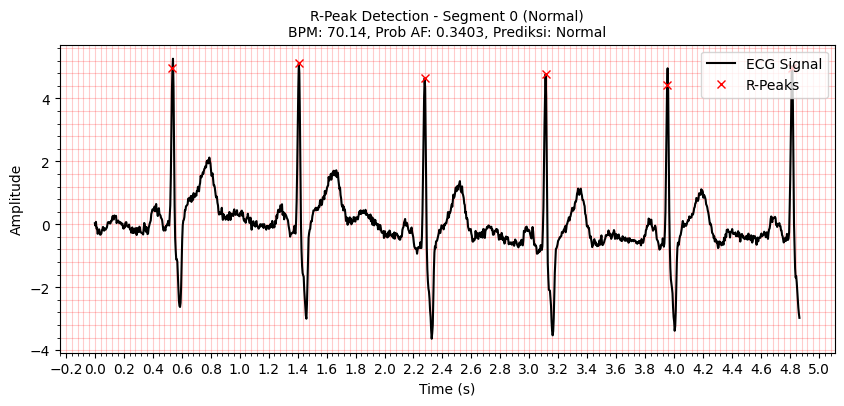

In [1]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import neurokit2 as nk
from scipy.signal import butter, filtfilt, detrend, iirnotch, resample, welch
from scipy.stats import entropy
import pywt

# Required functions (unchanged except for debugging options)
def bandpass_filter(signal, lowcut=0.5, highcut=40.0, fs=267, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def notch_filter(signal, freq=50.0, fs=267, quality=30.0):
    b, a = iirnotch(freq, quality, fs)
    return filtfilt(b, a, signal)

def wavelet_denoise(signal, wavelet='db6', level=5):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    threshold = np.std(coeffs[-1]) * np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)

def compute_rr_features(signal, fs=267, use_entropy=True, visualize=False, segment_idx=0, label='unknown'):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    try:
        signal_detrended = detrend(signal[:, 0])
        signal_denoised = wavelet_denoise(signal_detrended)
        signal_notched = notch_filter(signal_denoised, freq=50.0, fs=fs)
        signal_filtered = bandpass_filter(signal_notched, lowcut=0.5, highcut=40.0, fs=fs)
        signal_norm = (signal_filtered - np.mean(signal_filtered)) / (np.std(signal_filtered) + 1e-8)
        cleaned = nk.ecg_clean(signal_norm, sampling_rate=fs, method='neurokit')
        rpeaks_info = nk.ecg_findpeaks(cleaned, sampling_rate=fs)
        r_peaks = np.array(rpeaks_info['ECG_R_Peaks'])
        if len(r_peaks) < 2:
            print(f"Peringatan: Hanya {len(r_peaks)} puncak R terdeteksi pada segmen {segment_idx}.")
            return None, None, None
        rr_intervals = np.diff(r_peaks) / fs * 1000
        cv_rr = np.std(rr_intervals) / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        qrs_amplitude = np.max(signal_norm) - np.min(signal_norm)
        bpm = 60000 / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        if use_entropy:
            hist, _ = np.histogram(signal_norm, bins=50, density=True)
            signal_entropy = entropy(hist)
            signal_entropy = (signal_entropy - np.mean(hist)) / (np.std(hist) + 1e-8)
        else:
            freqs, psd = welch(signal_norm, fs=fs, nperseg=256)
            signal_entropy = np.sum(psd)
        if visualize:
            visualize_r_peaks(cleaned, r_peaks, label, fs, segment_idx)
        return rr_intervals, [cv_rr, qrs_amplitude, signal_entropy, bpm], r_peaks
    except Exception as e:
        print(f"Error deteksi puncak R: {e}")
        return None, None, None

def visualize_r_peaks(signal, r_peaks, label, fs=267, segment_idx=0, bpm=None, prob=None):
    if r_peaks is None or len(r_peaks) == 0:
        print("Tidak ada R-peaks untuk divisualisasikan.")
        return
    plt.figure(figsize=(10, 4))
    t = np.arange(len(signal)) / fs
    plt.plot(t, signal, label='ECG Signal', color='black')
    plt.plot(t[r_peaks], signal[r_peaks], 'rx', label='R-Peaks')
    title_str = f'R-Peak Detection - Segment {segment_idx} ({label})'
    if bpm is not None and prob is not None:
        title_str += f'\nBPM: {bpm:.2f}, Prob AF: {prob:.4f}, Prediksi: {label}'
    plt.title(title_str, fontsize=10)
    plt.grid(True, which='both', linestyle='-', alpha=0.2, color='red')
    plt.minorticks_on()
    plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.04))
    plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    plt.gca().yaxis.set_major_locator(ticker.AutoLocator())
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.savefig(f'r_peaks_segment_{segment_idx}_{label}.png', dpi=300)
    plt.show()

def augment_signal(signal, noise_factor=0.1):
    noise = np.random.normal(0, noise_factor, signal.shape)
    scaled_signal = signal * np.random.uniform(0.8, 1.2)
    shifted_signal = scaled_signal + np.random.uniform(-0.2, 0.2)
    return shifted_signal + noise

def normalize_signal(signal):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    signal_norm = (signal - np.mean(signal, axis=0)) / (np.std(signal, axis=0) + 1e-8)
    return signal_norm

def load_and_process_csv(csv_file, segment_length=1300, fs=267, disable_augmentation=False):
    df = pd.read_csv(csv_file)
    signal = df['ECG'].values
    original_fs = 250  # Based on 0.004s interval
    if original_fs != fs:
        target_samples = int(len(signal) * (fs / original_fs))
        signal = resample(signal, target_samples)
    if len(signal) < segment_length:
        print(f"Panjang sinyal ({len(signal)}) kurang dari {segment_length}. Tidak dapat memroses.")
        return None, None, None
    segments, rr_features_list, r_peaks_list = [], [], []
    step = int(segment_length * 0.5)
    for i in range(0, len(signal) - segment_length, step):
        segment = signal[i:i + segment_length]
        if len(segment) != segment_length:
            continue
        segment_norm = normalize_signal(segment)
        segment_augmented = segment_norm if disable_augmentation else augment_signal(segment_norm)
        rr_intervals, features, r_peaks = compute_rr_features(segment, fs=fs)
        if rr_intervals is None or features is None:
            continue
        segments.append(segment_augmented)
        rr_features_list.append(features)
        r_peaks_list.append(r_peaks)
    if not segments:
        print("Tidak ada segmen yang valid setelah pemrosesan.")
        return None, None, None
    segments = np.array(segments)
    rr_features_list = np.array(rr_features_list)
    segments = segments.reshape(segments.shape[0], segment_length, 1)
    return segments, rr_features_list, r_peaks_list

def select_best_model(fold_scores, base_path='best_model_lstm_layer_fold_2.h5'):
    if not fold_scores:
        print("Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 2.")
        best_fold = 1
    else:
        best_fold = np.argmax(fold_scores) + 1
    model_path = base_path.format(best_fold)
    if os.path.exists(model_path):
        print(f"Memuat model terbaik dari fold {best_fold} di {model_path}")
        model = load_model(model_path)
        return model, best_fold
    else:
        print(f"Model untuk fold {best_fold} tidak ditemukan di {model_path}")
        return None, None

def predict_with_model(model, scaler, X_test, rr_features_test, threshold=0.5):
    rr_features_norm = scaler.transform(rr_features_test)
    predictions = model.predict([X_test, rr_features_norm], verbose=0)
    predictions_binary = (predictions > threshold).astype(int).flatten()
    return predictions, predictions_binary

# Main execution
csv_file = r'D:\Tugas Akhir\Pemodelan\CNN_LSTM\mitbihafdb_04048_channel1_segment_1.csv'  # Ganti dengan path file CSV kamu
segment_length = 1300
fs = 267

# 1. Muat dan proses data CSV with debugging option
X_test, rr_features_test, r_peaks_test = load_and_process_csv(csv_file, segment_length, fs, disable_augmentation=True)
if X_test is None:
    print("Gagal memroses data CSV. Program dihentikan.")
    exit()

print(f"Data CSV diproses: {X_test.shape[0]} segmen")
print(f"RR Features for Segment 0: {rr_features_test[0]}")  # Debug RR features

# 2. Muat scaler dan data yang disimpan
data_dict = joblib.load('processed_data.pkl')
scaler = data_dict['scaler']
print("Scaler dimuat dari 'processed_data.pkl'")

# 3. Pilih model terbaik berdasarkan fold_scores
fold_scores = []  # Ganti dengan daftar fold_scores dari K-Fold CV
# Contoh: fold_scores = [0.95, 0.92, 0.96, 0.93, 0.94]
model, best_fold = select_best_model(fold_scores)
if model is None:
    print("Gagal memuat model terbaik. Program dihentikan.")
    exit()

# 4. Lakukan prediksi with adjustable threshold
predictions, predictions_binary = predict_with_model(model, scaler, X_test, rr_features_test, threshold=0.7)

# 5. Tampilkan hasil prediksi
print(f"\nHasil Prediksi untuk {X_test.shape[0]} Segmen:")
for i, (prob, label) in enumerate(zip(predictions.flatten(), predictions_binary)):
    label_str = 'AF' if label == 1 else 'Normal'
    print(f"Segmen {i+1}: Probabilitas AF = {prob:.4f}, Prediksi = {label_str}")

# 6. Visualisasi sinyal dan R-peaks untuk segmen pertama
if X_test.shape[0] > 0:
    label = 'AF' if predictions_binary[0] == 1 else 'Normal'
    bpm = rr_features_test[0][3]
    prob = predictions[0][0]
    visualize_r_peaks(X_test[0].flatten(), r_peaks_test[0], label, fs=fs, segment_idx=0, bpm=bpm, prob=prob)

In [ ]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import neurokit2 as nk
from scipy.signal import butter, filtfilt, detrend, iirnotch, resample, welch
from scipy.stats import entropy
import pywt

# Required functions (unchanged except for debugging options)
def bandpass_filter(signal, lowcut=0.5, highcut=40.0, fs=267, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def notch_filter(signal, freq=50.0, fs=267, quality=30.0):
    b, a = iirnotch(freq, quality, fs)
    return filtfilt(b, a, signal)

def wavelet_denoise(signal, wavelet='db6', level=5):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    threshold = np.std(coeffs[-1]) * np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)

def compute_rr_features(signal, fs=267, use_entropy=True, visualize=False, segment_idx=0, label='unknown'):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    try:
        signal_detrended = detrend(signal[:, 0])
        signal_denoised = wavelet_denoise(signal_detrended)
        signal_notched = notch_filter(signal_denoised, freq=50.0, fs=fs)
        signal_filtered = bandpass_filter(signal_notched, lowcut=0.5, highcut=40.0, fs=fs)
        signal_norm = (signal_filtered - np.mean(signal_filtered)) / (np.std(signal_filtered) + 1e-8)
        cleaned = nk.ecg_clean(signal_norm, sampling_rate=fs, method='neurokit')
        rpeaks_info = nk.ecg_findpeaks(cleaned, sampling_rate=fs)
        r_peaks = np.array(rpeaks_info['ECG_R_Peaks'])
        if len(r_peaks) < 2:
            print(f"Peringatan: Hanya {len(r_peaks)} puncak R terdeteksi pada segmen {segment_idx}.")
            return None, None, None
        rr_intervals = np.diff(r_peaks) / fs * 1000
        cv_rr = np.std(rr_intervals) / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        qrs_amplitude = np.max(signal_norm) - np.min(signal_norm)
        bpm = 60000 / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        if use_entropy:
            hist, _ = np.histogram(signal_norm, bins=50, density=True)
            signal_entropy = entropy(hist)
            signal_entropy = (signal_entropy - np.mean(hist)) / (np.std(hist) + 1e-8)
        else:
            freqs, psd = welch(signal_norm, fs=fs, nperseg=256)
            signal_entropy = np.sum(psd)
        if visualize:
            visualize_r_peaks(cleaned, r_peaks, label, fs, segment_idx)
        return rr_intervals, [cv_rr, qrs_amplitude, signal_entropy, bpm], r_peaks
    except Exception as e:
        print(f"Error deteksi puncak R: {e}")
        return None, None, None

def visualize_r_peaks(signal, r_peaks, label, fs=267, segment_idx=0, bpm=None, prob=None):
    if r_peaks is None or len(r_peaks) == 0:
        print("Tidak ada R-peaks untuk divisualisasikan.")
        return
    plt.figure(figsize=(10, 4))
    t = np.arange(len(signal)) / fs
    plt.plot(t, signal, label='ECG Signal', color='black')
    plt.plot(t[r_peaks], signal[r_peaks], 'rx', label='R-Peaks')
    title_str = f'R-Peak Detection - Segment {segment_idx} ({label})'
    if bpm is not None and prob is not None:
        title_str += f'\nBPM: {bpm:.2f}, Prob AF: {prob:.4f}, Prediksi: {label}'
    plt.title(title_str, fontsize=10)
    plt.grid(True, which='both', linestyle='-', alpha=0.2, color='red')
    plt.minorticks_on()
    plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.04))
    plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    plt.gca().yaxis.set_major_locator(ticker.AutoLocator())
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.savefig(f'r_peaks_segment_{segment_idx}_{label}.png', dpi=300)
    plt.show()

def augment_signal(signal, noise_factor=0.1):
    noise = np.random.normal(0, noise_factor, signal.shape)
    scaled_signal = signal * np.random.uniform(0.8, 1.2)
    shifted_signal = scaled_signal + np.random.uniform(-0.2, 0.2)
    return shifted_signal + noise

def normalize_signal(signal):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    signal_norm = (signal - np.mean(signal, axis=0)) / (np.std(signal, axis=0) + 1e-8)
    return signal_norm

def load_and_process_csv(csv_file, segment_length=1300, fs=267, disable_augmentation=False):
    df = pd.read_csv(csv_file)
    signal = df['ECG'].values
    original_fs = 250  # Based on 0.004s interval
    if original_fs != fs:
        target_samples = int(len(signal) * (fs / original_fs))
        signal = resample(signal, target_samples)
    if len(signal) < segment_length:
        print(f"Panjang sinyal ({len(signal)}) kurang dari {segment_length}. Tidak dapat memroses.")
        return None, None, None
    segments, rr_features_list, r_peaks_list = [], [], []
    step = int(segment_length * 0.5)
    for i in range(0, len(signal) - segment_length, step):
        segment = signal[i:i + segment_length]
        if len(segment) != segment_length:
            continue
        segment_norm = normalize_signal(segment)
        segment_augmented = segment_norm if disable_augmentation else augment_signal(segment_norm)
        rr_intervals, features, r_peaks = compute_rr_features(segment, fs=fs)
        if rr_intervals is None or features is None:
            continue
        segments.append(segment_augmented)
        rr_features_list.append(features)
        r_peaks_list.append(r_peaks)
    if not segments:
        print("Tidak ada segmen yang valid setelah pemrosesan.")
        return None, None, None
    segments = np.array(segments)
    rr_features_list = np.array(rr_features_list)
    segments = segments.reshape(segments.shape[0], segment_length, 1)
    return segments, rr_features_list, r_peaks_list

def select_best_model(fold_scores, base_path='best_model_lstm_layer_fold_2.h5'):
    if not fold_scores:
        print("Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 2.")
        best_fold = 1
    else:
        best_fold = np.argmax(fold_scores) + 1
    model_path = base_path.format(best_fold)
    if os.path.exists(model_path):
        print(f"Memuat model terbaik dari fold {best_fold} di {model_path}")
        model = load_model(model_path)
        return model, best_fold
    else:
        print(f"Model untuk fold {best_fold} tidak ditemukan di {model_path}")
        return None, None

def predict_with_model(model, scaler, X_test, rr_features_test, threshold=0.5):
    rr_features_norm = scaler.transform(rr_features_test)
    predictions = model.predict([X_test, rr_features_norm], verbose=0)
    predictions_binary = (predictions > threshold).astype(int).flatten()
    return predictions, predictions_binary

# Main execution
csv_file = r'D:\Tugas Akhir\Pemodelan\CNN_LSTM\mitbihafdb_04048_channel1_segment_1.csv'  # Ganti dengan path file CSV kamu
segment_length = 1300
fs = 267

# 1. Muat dan proses data CSV with debugging option
X_test, rr_features_test, r_peaks_test = load_and_process_csv(csv_file, segment_length, fs, disable_augmentation=True)
if X_test is None:
    print("Gagal memroses data CSV. Program dihentikan.")
    exit()

print(f"Data CSV diproses: {X_test.shape[0]} segmen")
print(f"RR Features for Segment 0: {rr_features_test[0]}")  # Debug RR features

# 2. Muat scaler dan data yang disimpan
data_dict = joblib.load('processed_data.pkl')
scaler = data_dict['scaler']
print("Scaler dimuat dari 'processed_data.pkl'")

# 3. Pilih model terbaik berdasarkan fold_scores
fold_scores = []  # Ganti dengan daftar fold_scores dari K-Fold CV
# Contoh: fold_scores = [0.95, 0.92, 0.96, 0.93, 0.94]
model, best_fold = select_best_model(fold_scores)
if model is None:
    print("Gagal memuat model terbaik. Program dihentikan.")
    exit()

# 4. Lakukan prediksi with adjustable threshold
predictions, predictions_binary = predict_with_model(model, scaler, X_test, rr_features_test, threshold=0.7)

# 5. Tampilkan hasil prediksi
print(f"\nHasil Prediksi untuk {X_test.shape[0]} Segmen:")
for i, (prob, label) in enumerate(zip(predictions.flatten(), predictions_binary)):
    label_str = 'AF' if label == 1 else 'Normal'
    print(f"Segmen {i+1}: Probabilitas AF = {prob:.4f}, Prediksi = {label_str}")

# 6. Visualisasi sinyal dan R-peaks untuk segmen pertama
if X_test.shape[0] > 0:
    label = 'AF' if predictions_binary[0] == 1 else 'Normal'
    bpm = rr_features_test[0][3]
    prob = predictions[0][0]
    visualize_r_peaks(X_test[0].flatten(), r_peaks_test[0], label, fs=fs, segment_idx=0, bpm=bpm, prob=prob)

Data CSV diproses: 34 segmen
RR Features for Segment 0: [1.07415165e-02 8.72912469e+00 1.09567488e+01 6.65420561e+01]
Scaler dimuat dari 'processed_data.pkl'
Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 2.
Memuat model terbaik dari fold 1 di best_model_lstm_layer_fold_2.h5

Hasil Prediksi untuk 34 Segmen:
Segmen 1: Probabilitas AF = 0.4831, Prediksi = Normal
Segmen 2: Probabilitas AF = 0.4337, Prediksi = Normal
Segmen 3: Probabilitas AF = 0.4004, Prediksi = Normal
Segmen 4: Probabilitas AF = 0.4778, Prediksi = Normal
Segmen 5: Probabilitas AF = 0.3316, Prediksi = Normal
Segmen 6: Probabilitas AF = 0.4249, Prediksi = Normal
Segmen 7: Probabilitas AF = 0.5327, Prediksi = Normal
Segmen 8: Probabilitas AF = 0.4464, Prediksi = Normal
Segmen 9: Probabilitas AF = 0.4543, Prediksi = Normal
Segmen 10: Probabilitas AF = 0.5636, Prediksi = Normal
Segmen 11: Probabilitas AF = 0.3826, Prediksi = Normal
Segmen 12: Probabilitas AF = 0.4294, Prediksi = Normal
Segmen 13: Probabilitas 

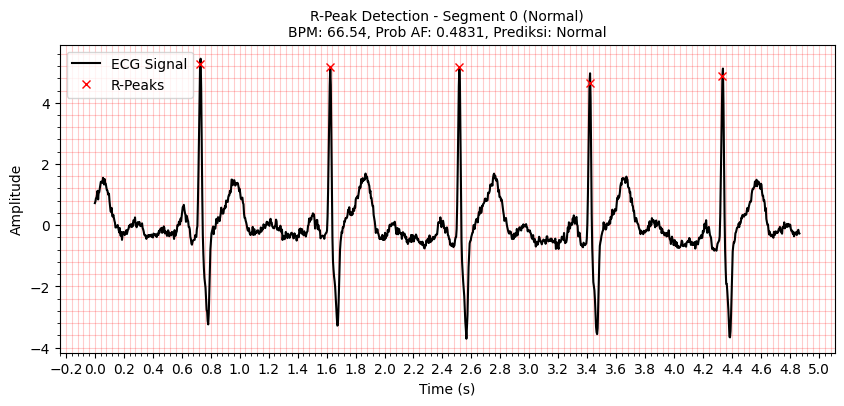

In [2]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import neurokit2 as nk
from scipy.signal import butter, filtfilt, detrend, iirnotch, resample, welch
from scipy.stats import entropy
import pywt

# Required functions (unchanged except for debugging options)
def bandpass_filter(signal, lowcut=0.5, highcut=40.0, fs=267, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def notch_filter(signal, freq=50.0, fs=267, quality=30.0):
    b, a = iirnotch(freq, quality, fs)
    return filtfilt(b, a, signal)

def wavelet_denoise(signal, wavelet='db6', level=5):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    threshold = np.std(coeffs[-1]) * np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)

def compute_rr_features(signal, fs=267, use_entropy=True, visualize=False, segment_idx=0, label='unknown'):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    try:
        signal_detrended = detrend(signal[:, 0])
        signal_denoised = wavelet_denoise(signal_detrended)
        signal_notched = notch_filter(signal_denoised, freq=50.0, fs=fs)
        signal_filtered = bandpass_filter(signal_notched, lowcut=0.5, highcut=40.0, fs=fs)
        signal_norm = (signal_filtered - np.mean(signal_filtered)) / (np.std(signal_filtered) + 1e-8)
        cleaned = nk.ecg_clean(signal_norm, sampling_rate=fs, method='neurokit')
        rpeaks_info = nk.ecg_findpeaks(cleaned, sampling_rate=fs)
        r_peaks = np.array(rpeaks_info['ECG_R_Peaks'])
        if len(r_peaks) < 2:
            print(f"Peringatan: Hanya {len(r_peaks)} puncak R terdeteksi pada segmen {segment_idx}.")
            return None, None, None
        rr_intervals = np.diff(r_peaks) / fs * 1000
        cv_rr = np.std(rr_intervals) / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        qrs_amplitude = np.max(signal_norm) - np.min(signal_norm)
        bpm = 60000 / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        if use_entropy:
            hist, _ = np.histogram(signal_norm, bins=50, density=True)
            signal_entropy = entropy(hist)
            signal_entropy = (signal_entropy - np.mean(hist)) / (np.std(hist) + 1e-8)
        else:
            freqs, psd = welch(signal_norm, fs=fs, nperseg=256)
            signal_entropy = np.sum(psd)
        if visualize:
            visualize_r_peaks(cleaned, r_peaks, label, fs, segment_idx)
        return rr_intervals, [cv_rr, qrs_amplitude, signal_entropy, bpm], r_peaks
    except Exception as e:
        print(f"Error deteksi puncak R: {e}")
        return None, None, None

def visualize_r_peaks(signal, r_peaks, label, fs=267, segment_idx=0, bpm=None, prob=None):
    if r_peaks is None or len(r_peaks) == 0:
        print("Tidak ada R-peaks untuk divisualisasikan.")
        return
    plt.figure(figsize=(10, 4))
    t = np.arange(len(signal)) / fs
    plt.plot(t, signal, label='ECG Signal', color='black')
    plt.plot(t[r_peaks], signal[r_peaks], 'rx', label='R-Peaks')
    title_str = f'R-Peak Detection - Segment {segment_idx} ({label})'
    if bpm is not None and prob is not None:
        title_str += f'\nBPM: {bpm:.2f}, Prob AF: {prob:.4f}, Prediksi: {label}'
    plt.title(title_str, fontsize=10)
    plt.grid(True, which='both', linestyle='-', alpha=0.2, color='red')
    plt.minorticks_on()
    plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.04))
    plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    plt.gca().yaxis.set_major_locator(ticker.AutoLocator())
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.savefig(f'r_peaks_segment_{segment_idx}_{label}.png', dpi=300)
    plt.show()

def augment_signal(signal, noise_factor=0.1):
    noise = np.random.normal(0, noise_factor, signal.shape)
    scaled_signal = signal * np.random.uniform(0.8, 1.2)
    shifted_signal = scaled_signal + np.random.uniform(-0.2, 0.2)
    return shifted_signal + noise

def normalize_signal(signal):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    signal_norm = (signal - np.mean(signal, axis=0)) / (np.std(signal, axis=0) + 1e-8)
    return signal_norm

def load_and_process_csv(csv_file, segment_length=1300, fs=267, disable_augmentation=False):
    df = pd.read_csv(csv_file)
    signal = df['ECG'].values
    original_fs = 250  # Based on 0.004s interval
    if original_fs != fs:
        target_samples = int(len(signal) * (fs / original_fs))
        signal = resample(signal, target_samples)
    if len(signal) < segment_length:
        print(f"Panjang sinyal ({len(signal)}) kurang dari {segment_length}. Tidak dapat memroses.")
        return None, None, None
    segments, rr_features_list, r_peaks_list = [], [], []
    step = int(segment_length * 0.5)
    for i in range(0, len(signal) - segment_length, step):
        segment = signal[i:i + segment_length]
        if len(segment) != segment_length:
            continue
        segment_norm = normalize_signal(segment)
        segment_augmented = segment_norm if disable_augmentation else augment_signal(segment_norm)
        rr_intervals, features, r_peaks = compute_rr_features(segment, fs=fs)
        if rr_intervals is None or features is None:
            continue
        segments.append(segment_augmented)
        rr_features_list.append(features)
        r_peaks_list.append(r_peaks)
    if not segments:
        print("Tidak ada segmen yang valid setelah pemrosesan.")
        return None, None, None
    segments = np.array(segments)
    rr_features_list = np.array(rr_features_list)
    segments = segments.reshape(segments.shape[0], segment_length, 1)
    return segments, rr_features_list, r_peaks_list

def select_best_model(fold_scores, base_path='best_model_lstm_layer_fold_2.h5'):
    if not fold_scores:
        print("Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 2.")
        best_fold = 1
    else:
        best_fold = np.argmax(fold_scores) + 1
    model_path = base_path.format(best_fold)
    if os.path.exists(model_path):
        print(f"Memuat model terbaik dari fold {best_fold} di {model_path}")
        model = load_model(model_path)
        return model, best_fold
    else:
        print(f"Model untuk fold {best_fold} tidak ditemukan di {model_path}")
        return None, None

def predict_with_model(model, scaler, X_test, rr_features_test, threshold=0.5):
    rr_features_norm = scaler.transform(rr_features_test)
    predictions = model.predict([X_test, rr_features_norm], verbose=0)
    predictions_binary = (predictions > threshold).astype(int).flatten()
    return predictions, predictions_binary

# Main execution
csv_file = r'D:\Tugas Akhir\Pemodelan\CNN_LSTM\mitbihafdb_04048_channel1_segment_7.csv'  # Ganti dengan path file CSV kamu
segment_length = 1300
fs = 267

# 1. Muat dan proses data CSV with debugging option
X_test, rr_features_test, r_peaks_test = load_and_process_csv(csv_file, segment_length, fs, disable_augmentation=True)
if X_test is None:
    print("Gagal memroses data CSV. Program dihentikan.")
    exit()

print(f"Data CSV diproses: {X_test.shape[0]} segmen")
print(f"RR Features for Segment 0: {rr_features_test[0]}")  # Debug RR features

# 2. Muat scaler dan data yang disimpan
data_dict = joblib.load('processed_data.pkl')
scaler = data_dict['scaler']
print("Scaler dimuat dari 'processed_data.pkl'")

# 3. Pilih model terbaik berdasarkan fold_scores
fold_scores = []  # Ganti dengan daftar fold_scores dari K-Fold CV
# Contoh: fold_scores = [0.95, 0.92, 0.96, 0.93, 0.94]
model, best_fold = select_best_model(fold_scores)
if model is None:
    print("Gagal memuat model terbaik. Program dihentikan.")
    exit()

# 4. Lakukan prediksi with adjustable threshold
predictions, predictions_binary = predict_with_model(model, scaler, X_test, rr_features_test, threshold=0.7)

# 5. Tampilkan hasil prediksi
print(f"\nHasil Prediksi untuk {X_test.shape[0]} Segmen:")
for i, (prob, label) in enumerate(zip(predictions.flatten(), predictions_binary)):
    label_str = 'AF' if label == 1 else 'Normal'
    print(f"Segmen {i+1}: Probabilitas AF = {prob:.4f}, Prediksi = {label_str}")

# 6. Visualisasi sinyal dan R-peaks untuk segmen pertama
if X_test.shape[0] > 0:
    label = 'AF' if predictions_binary[0] == 1 else 'Normal'
    bpm = rr_features_test[0][3]
    prob = predictions[0][0]
    visualize_r_peaks(X_test[0].flatten(), r_peaks_test[0], label, fs=fs, segment_idx=0, bpm=bpm, prob=prob)

Data CSV diproses: 1721 segmen
RR Features for Segment 0: [2.21457103e-02 7.68747974e+00 1.39136679e+01 1.44715447e+02]
Scaler dimuat dari 'processed_data.pkl'
Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 2.
Memuat model terbaik dari fold 1 di best_model_lstm_layer_fold_2.h5



Hasil Prediksi untuk 1721 Segmen:
Segmen 1: Probabilitas AF = 0.3009, Prediksi = Normal
Segmen 2: Probabilitas AF = 0.3087, Prediksi = Normal
Segmen 3: Probabilitas AF = 0.2826, Prediksi = Normal
Segmen 4: Probabilitas AF = 0.3821, Prediksi = Normal
Segmen 5: Probabilitas AF = 0.4053, Prediksi = Normal
Segmen 6: Probabilitas AF = 0.4837, Prediksi = Normal
Segmen 7: Probabilitas AF = 0.4692, Prediksi = Normal
Segmen 8: Probabilitas AF = 0.4585, Prediksi = Normal
Segmen 9: Probabilitas AF = 0.3344, Prediksi = Normal
Segmen 10: Probabilitas AF = 0.3366, Prediksi = Normal
Segmen 11: Probabilitas AF = 0.2987, Prediksi = Normal
Segmen 12: Probabilitas AF = 0.3670, Prediksi = Normal
Segmen 13: Probabilitas AF = 0.3318, Prediksi = Normal
Segmen 14: Probabilitas AF = 0.4302, Prediksi = Normal
Segmen 15: Probabilitas AF = 0.3934, Prediksi = Normal
Segmen 16: Probabilitas AF = 0.3775, Prediksi = Normal
Segmen 17: Probabilitas AF = 0.3972, Prediksi = Normal
Segmen 18: Probabilitas AF = 0.4307, Pr

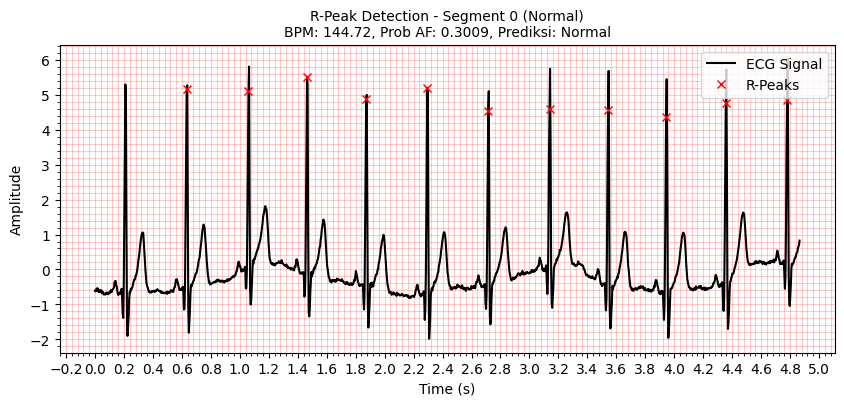

In [3]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import neurokit2 as nk
from scipy.signal import butter, filtfilt, detrend, iirnotch, resample, welch
from scipy.stats import entropy
import pywt

# Required functions (unchanged except for debugging options)
def bandpass_filter(signal, lowcut=0.5, highcut=40.0, fs=267, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def notch_filter(signal, freq=50.0, fs=267, quality=30.0):
    b, a = iirnotch(freq, quality, fs)
    return filtfilt(b, a, signal)

def wavelet_denoise(signal, wavelet='db6', level=5):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    threshold = np.std(coeffs[-1]) * np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)

def compute_rr_features(signal, fs=267, use_entropy=True, visualize=False, segment_idx=0, label='unknown'):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    try:
        signal_detrended = detrend(signal[:, 0])
        signal_denoised = wavelet_denoise(signal_detrended)
        signal_notched = notch_filter(signal_denoised, freq=50.0, fs=fs)
        signal_filtered = bandpass_filter(signal_notched, lowcut=0.5, highcut=40.0, fs=fs)
        signal_norm = (signal_filtered - np.mean(signal_filtered)) / (np.std(signal_filtered) + 1e-8)
        cleaned = nk.ecg_clean(signal_norm, sampling_rate=fs, method='neurokit')
        rpeaks_info = nk.ecg_findpeaks(cleaned, sampling_rate=fs)
        r_peaks = np.array(rpeaks_info['ECG_R_Peaks'])
        if len(r_peaks) < 2:
            print(f"Peringatan: Hanya {len(r_peaks)} puncak R terdeteksi pada segmen {segment_idx}.")
            return None, None, None
        rr_intervals = np.diff(r_peaks) / fs * 1000
        cv_rr = np.std(rr_intervals) / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        qrs_amplitude = np.max(signal_norm) - np.min(signal_norm)
        bpm = 60000 / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        if use_entropy:
            hist, _ = np.histogram(signal_norm, bins=50, density=True)
            signal_entropy = entropy(hist)
            signal_entropy = (signal_entropy - np.mean(hist)) / (np.std(hist) + 1e-8)
        else:
            freqs, psd = welch(signal_norm, fs=fs, nperseg=256)
            signal_entropy = np.sum(psd)
        if visualize:
            visualize_r_peaks(cleaned, r_peaks, label, fs, segment_idx)
        return rr_intervals, [cv_rr, qrs_amplitude, signal_entropy, bpm], r_peaks
    except Exception as e:
        print(f"Error deteksi puncak R: {e}")
        return None, None, None

def visualize_r_peaks(signal, r_peaks, label, fs=267, segment_idx=0, bpm=None, prob=None):
    if r_peaks is None or len(r_peaks) == 0:
        print("Tidak ada R-peaks untuk divisualisasikan.")
        return
    plt.figure(figsize=(10, 4))
    t = np.arange(len(signal)) / fs
    plt.plot(t, signal, label='ECG Signal', color='black')
    plt.plot(t[r_peaks], signal[r_peaks], 'rx', label='R-Peaks')
    title_str = f'R-Peak Detection - Segment {segment_idx} ({label})'
    if bpm is not None and prob is not None:
        title_str += f'\nBPM: {bpm:.2f}, Prob AF: {prob:.4f}, Prediksi: {label}'
    plt.title(title_str, fontsize=10)
    plt.grid(True, which='both', linestyle='-', alpha=0.2, color='red')
    plt.minorticks_on()
    plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.04))
    plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    plt.gca().yaxis.set_major_locator(ticker.AutoLocator())
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.savefig(f'r_peaks_segment_{segment_idx}_{label}.png', dpi=300)
    plt.show()

def augment_signal(signal, noise_factor=0.1):
    noise = np.random.normal(0, noise_factor, signal.shape)
    scaled_signal = signal * np.random.uniform(0.8, 1.2)
    shifted_signal = scaled_signal + np.random.uniform(-0.2, 0.2)
    return shifted_signal + noise

def normalize_signal(signal):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    signal_norm = (signal - np.mean(signal, axis=0)) / (np.std(signal, axis=0) + 1e-8)
    return signal_norm

def load_and_process_csv(csv_file, segment_length=1300, fs=267, disable_augmentation=False):
    df = pd.read_csv(csv_file)
    signal = df['ECG'].values
    original_fs = 250  # Based on 0.004s interval
    if original_fs != fs:
        target_samples = int(len(signal) * (fs / original_fs))
        signal = resample(signal, target_samples)
    if len(signal) < segment_length:
        print(f"Panjang sinyal ({len(signal)}) kurang dari {segment_length}. Tidak dapat memroses.")
        return None, None, None
    segments, rr_features_list, r_peaks_list = [], [], []
    step = int(segment_length * 0.5)
    for i in range(0, len(signal) - segment_length, step):
        segment = signal[i:i + segment_length]
        if len(segment) != segment_length:
            continue
        segment_norm = normalize_signal(segment)
        segment_augmented = segment_norm if disable_augmentation else augment_signal(segment_norm)
        rr_intervals, features, r_peaks = compute_rr_features(segment, fs=fs)
        if rr_intervals is None or features is None:
            continue
        segments.append(segment_augmented)
        rr_features_list.append(features)
        r_peaks_list.append(r_peaks)
    if not segments:
        print("Tidak ada segmen yang valid setelah pemrosesan.")
        return None, None, None
    segments = np.array(segments)
    rr_features_list = np.array(rr_features_list)
    segments = segments.reshape(segments.shape[0], segment_length, 1)
    return segments, rr_features_list, r_peaks_list

def select_best_model(fold_scores, base_path='best_model_lstm_layer_fold_2.h5'):
    if not fold_scores:
        print("Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 2.")
        best_fold = 1
    else:
        best_fold = np.argmax(fold_scores) + 1
    model_path = base_path.format(best_fold)
    if os.path.exists(model_path):
        print(f"Memuat model terbaik dari fold {best_fold} di {model_path}")
        model = load_model(model_path)
        return model, best_fold
    else:
        print(f"Model untuk fold {best_fold} tidak ditemukan di {model_path}")
        return None, None

def predict_with_model(model, scaler, X_test, rr_features_test, threshold=0.5):
    rr_features_norm = scaler.transform(rr_features_test)
    predictions = model.predict([X_test, rr_features_norm], verbose=0)
    predictions_binary = (predictions > threshold).astype(int).flatten()
    return predictions, predictions_binary

# Main execution
csv_file = r'D:\Tugas Akhir\Pemodelan\CNN_LSTM\normal_16773_leadII.csv'  # Ganti dengan path file CSV kamu
segment_length = 1300
fs = 267

# 1. Muat dan proses data CSV with debugging option
X_test, rr_features_test, r_peaks_test = load_and_process_csv(csv_file, segment_length, fs, disable_augmentation=True)
if X_test is None:
    print("Gagal memroses data CSV. Program dihentikan.")
    exit()

print(f"Data CSV diproses: {X_test.shape[0]} segmen")
print(f"RR Features for Segment 0: {rr_features_test[0]}")  # Debug RR features

# 2. Muat scaler dan data yang disimpan
data_dict = joblib.load('processed_data.pkl')
scaler = data_dict['scaler']
print("Scaler dimuat dari 'processed_data.pkl'")

# 3. Pilih model terbaik berdasarkan fold_scores
fold_scores = []  # Ganti dengan daftar fold_scores dari K-Fold CV
# Contoh: fold_scores = [0.95, 0.92, 0.96, 0.93, 0.94]
model, best_fold = select_best_model(fold_scores)
if model is None:
    print("Gagal memuat model terbaik. Program dihentikan.")
    exit()

# 4. Lakukan prediksi with adjustable threshold
predictions, predictions_binary = predict_with_model(model, scaler, X_test, rr_features_test, threshold=0.7)

# 5. Tampilkan hasil prediksi
print(f"\nHasil Prediksi untuk {X_test.shape[0]} Segmen:")
for i, (prob, label) in enumerate(zip(predictions.flatten(), predictions_binary)):
    label_str = 'AF' if label == 1 else 'Normal'
    print(f"Segmen {i+1}: Probabilitas AF = {prob:.4f}, Prediksi = {label_str}")

# 6. Visualisasi sinyal dan R-peaks untuk segmen pertama
if X_test.shape[0] > 0:
    label = 'AF' if predictions_binary[0] == 1 else 'Normal'
    bpm = rr_features_test[0][3]
    prob = predictions[0][0]
    visualize_r_peaks(X_test[0].flatten(), r_peaks_test[0], label, fs=fs, segment_idx=0, bpm=bpm, prob=prob)

Data CSV diproses: 26 segmen
RR Features for Segment 0: [3.38967759e-02 9.24405610e+00 7.90766270e+00 6.52545825e+01]
Scaler dimuat dari 'processed_data.pkl'
Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 2.
Memuat model terbaik dari fold 1 di best_model_lstm_layer_fold_2.h5



Hasil Prediksi untuk 26 Segmen:
Segmen 1: Probabilitas AF = 0.6635, Prediksi = Normal
Segmen 2: Probabilitas AF = 0.5116, Prediksi = Normal
Segmen 3: Probabilitas AF = 0.6579, Prediksi = Normal
Segmen 4: Probabilitas AF = 0.6377, Prediksi = Normal
Segmen 5: Probabilitas AF = 0.6522, Prediksi = Normal
Segmen 6: Probabilitas AF = 0.6505, Prediksi = Normal
Segmen 7: Probabilitas AF = 0.6001, Prediksi = Normal
Segmen 8: Probabilitas AF = 0.7033, Prediksi = AF
Segmen 9: Probabilitas AF = 0.6118, Prediksi = Normal
Segmen 10: Probabilitas AF = 0.6249, Prediksi = Normal
Segmen 11: Probabilitas AF = 0.5062, Prediksi = Normal
Segmen 12: Probabilitas AF = 0.6753, Prediksi = Normal
Segmen 13: Probabilitas AF = 0.5879, Prediksi = Normal
Segmen 14: Probabilitas AF = 0.4903, Prediksi = Normal
Segmen 15: Probabilitas AF = 0.5813, Prediksi = Normal
Segmen 16: Probabilitas AF = 0.5757, Prediksi = Normal
Segmen 17: Probabilitas AF = 0.4638, Prediksi = Normal
Segmen 18: Probabilitas AF = 0.6562, Prediksi

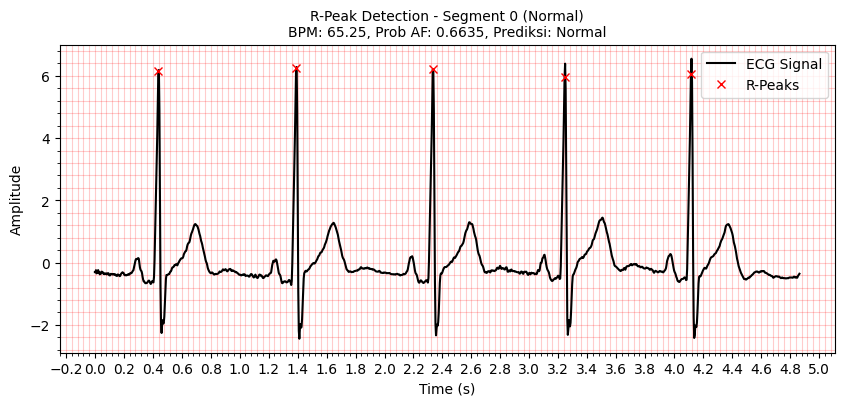

In [4]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import neurokit2 as nk
from scipy.signal import butter, filtfilt, detrend, iirnotch, resample, welch
from scipy.stats import entropy
import pywt

# Required functions (unchanged except for debugging options)
def bandpass_filter(signal, lowcut=0.5, highcut=40.0, fs=267, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def notch_filter(signal, freq=50.0, fs=267, quality=30.0):
    b, a = iirnotch(freq, quality, fs)
    return filtfilt(b, a, signal)

def wavelet_denoise(signal, wavelet='db6', level=5):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    threshold = np.std(coeffs[-1]) * np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)

def compute_rr_features(signal, fs=267, use_entropy=True, visualize=False, segment_idx=0, label='unknown'):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    try:
        signal_detrended = detrend(signal[:, 0])
        signal_denoised = wavelet_denoise(signal_detrended)
        signal_notched = notch_filter(signal_denoised, freq=50.0, fs=fs)
        signal_filtered = bandpass_filter(signal_notched, lowcut=0.5, highcut=40.0, fs=fs)
        signal_norm = (signal_filtered - np.mean(signal_filtered)) / (np.std(signal_filtered) + 1e-8)
        cleaned = nk.ecg_clean(signal_norm, sampling_rate=fs, method='neurokit')
        rpeaks_info = nk.ecg_findpeaks(cleaned, sampling_rate=fs)
        r_peaks = np.array(rpeaks_info['ECG_R_Peaks'])
        if len(r_peaks) < 2:
            print(f"Peringatan: Hanya {len(r_peaks)} puncak R terdeteksi pada segmen {segment_idx}.")
            return None, None, None
        rr_intervals = np.diff(r_peaks) / fs * 1000
        cv_rr = np.std(rr_intervals) / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        qrs_amplitude = np.max(signal_norm) - np.min(signal_norm)
        bpm = 60000 / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        if use_entropy:
            hist, _ = np.histogram(signal_norm, bins=50, density=True)
            signal_entropy = entropy(hist)
            signal_entropy = (signal_entropy - np.mean(hist)) / (np.std(hist) + 1e-8)
        else:
            freqs, psd = welch(signal_norm, fs=fs, nperseg=256)
            signal_entropy = np.sum(psd)
        if visualize:
            visualize_r_peaks(cleaned, r_peaks, label, fs, segment_idx)
        return rr_intervals, [cv_rr, qrs_amplitude, signal_entropy, bpm], r_peaks
    except Exception as e:
        print(f"Error deteksi puncak R: {e}")
        return None, None, None

def visualize_r_peaks(signal, r_peaks, label, fs=267, segment_idx=0, bpm=None, prob=None):
    if r_peaks is None or len(r_peaks) == 0:
        print("Tidak ada R-peaks untuk divisualisasikan.")
        return
    plt.figure(figsize=(10, 4))
    t = np.arange(len(signal)) / fs
    plt.plot(t, signal, label='ECG Signal', color='black')
    plt.plot(t[r_peaks], signal[r_peaks], 'rx', label='R-Peaks')
    title_str = f'R-Peak Detection - Segment {segment_idx} ({label})'
    if bpm is not None and prob is not None:
        title_str += f'\nBPM: {bpm:.2f}, Prob AF: {prob:.4f}, Prediksi: {label}'
    plt.title(title_str, fontsize=10)
    plt.grid(True, which='both', linestyle='-', alpha=0.2, color='red')
    plt.minorticks_on()
    plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.04))
    plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    plt.gca().yaxis.set_major_locator(ticker.AutoLocator())
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.savefig(f'r_peaks_segment_{segment_idx}_{label}.png', dpi=300)
    plt.show()

def augment_signal(signal, noise_factor=0.1):
    noise = np.random.normal(0, noise_factor, signal.shape)
    scaled_signal = signal * np.random.uniform(0.8, 1.2)
    shifted_signal = scaled_signal + np.random.uniform(-0.2, 0.2)
    return shifted_signal + noise

def normalize_signal(signal):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    signal_norm = (signal - np.mean(signal, axis=0)) / (np.std(signal, axis=0) + 1e-8)
    return signal_norm

def load_and_process_csv(csv_file, segment_length=1300, fs=267, disable_augmentation=False):
    df = pd.read_csv(csv_file)
    signal = df['ECG'].values
    original_fs = 250  # Based on 0.004s interval
    if original_fs != fs:
        target_samples = int(len(signal) * (fs / original_fs))
        signal = resample(signal, target_samples)
    if len(signal) < segment_length:
        print(f"Panjang sinyal ({len(signal)}) kurang dari {segment_length}. Tidak dapat memroses.")
        return None, None, None
    segments, rr_features_list, r_peaks_list = [], [], []
    step = int(segment_length * 0.5)
    for i in range(0, len(signal) - segment_length, step):
        segment = signal[i:i + segment_length]
        if len(segment) != segment_length:
            continue
        segment_norm = normalize_signal(segment)
        segment_augmented = segment_norm if disable_augmentation else augment_signal(segment_norm)
        rr_intervals, features, r_peaks = compute_rr_features(segment, fs=fs)
        if rr_intervals is None or features is None:
            continue
        segments.append(segment_augmented)
        rr_features_list.append(features)
        r_peaks_list.append(r_peaks)
    if not segments:
        print("Tidak ada segmen yang valid setelah pemrosesan.")
        return None, None, None
    segments = np.array(segments)
    rr_features_list = np.array(rr_features_list)
    segments = segments.reshape(segments.shape[0], segment_length, 1)
    return segments, rr_features_list, r_peaks_list

def select_best_model(fold_scores, base_path='best_model_lstm_layer_fold_2.h5'):
    if not fold_scores:
        print("Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 2.")
        best_fold = 1
    else:
        best_fold = np.argmax(fold_scores) + 1
    model_path = base_path.format(best_fold)
    if os.path.exists(model_path):
        print(f"Memuat model terbaik dari fold {best_fold} di {model_path}")
        model = load_model(model_path)
        return model, best_fold
    else:
        print(f"Model untuk fold {best_fold} tidak ditemukan di {model_path}")
        return None, None

def predict_with_model(model, scaler, X_test, rr_features_test, threshold=0.5):
    rr_features_norm = scaler.transform(rr_features_test)
    predictions = model.predict([X_test, rr_features_norm], verbose=0)
    predictions_binary = (predictions > threshold).astype(int).flatten()
    return predictions, predictions_binary

# Main execution
csv_file = r'D:\Tugas Akhir\Pemodelan\CNN_LSTM\Recording Perbandingan\1_Pria_21th_Zaidan\1_Pria_21th.csv'  # Ganti dengan path file CSV kamu
segment_length = 1300
fs = 267

# 1. Muat dan proses data CSV with debugging option
X_test, rr_features_test, r_peaks_test = load_and_process_csv(csv_file, segment_length, fs, disable_augmentation=True)
if X_test is None:
    print("Gagal memroses data CSV. Program dihentikan.")
    exit()

print(f"Data CSV diproses: {X_test.shape[0]} segmen")
print(f"RR Features for Segment 0: {rr_features_test[0]}")  # Debug RR features

# 2. Muat scaler dan data yang disimpan
data_dict = joblib.load('processed_data.pkl')
scaler = data_dict['scaler']
print("Scaler dimuat dari 'processed_data.pkl'")

# 3. Pilih model terbaik berdasarkan fold_scores
fold_scores = []  # Ganti dengan daftar fold_scores dari K-Fold CV
# Contoh: fold_scores = [0.95, 0.92, 0.96, 0.93, 0.94]
model, best_fold = select_best_model(fold_scores)
if model is None:
    print("Gagal memuat model terbaik. Program dihentikan.")
    exit()

# 4. Lakukan prediksi with adjustable threshold
predictions, predictions_binary = predict_with_model(model, scaler, X_test, rr_features_test, threshold=0.7)

# 5. Tampilkan hasil prediksi
print(f"\nHasil Prediksi untuk {X_test.shape[0]} Segmen:")
for i, (prob, label) in enumerate(zip(predictions.flatten(), predictions_binary)):
    label_str = 'AF' if label == 1 else 'Normal'
    print(f"Segmen {i+1}: Probabilitas AF = {prob:.4f}, Prediksi = {label_str}")

# 6. Visualisasi sinyal dan R-peaks untuk segmen pertama
if X_test.shape[0] > 0:
    label = 'AF' if predictions_binary[0] == 1 else 'Normal'
    bpm = rr_features_test[0][3]
    prob = predictions[0][0]
    visualize_r_peaks(X_test[0].flatten(), r_peaks_test[0], label, fs=fs, segment_idx=0, bpm=bpm, prob=prob)

Data CSV diproses: 22 segmen
RR Features for Segment 0: [1.28457050e-02 7.76890992e+00 1.05520957e+01 7.19191919e+01]
Scaler dimuat dari 'processed_data.pkl'
Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 2.
Memuat model terbaik dari fold 1 di best_model_lstm_layer_fold_2.h5



Hasil Prediksi untuk 22 Segmen:
Segmen 1: Probabilitas AF = 0.5314, Prediksi = Normal
Segmen 2: Probabilitas AF = 0.4993, Prediksi = Normal
Segmen 3: Probabilitas AF = 0.6151, Prediksi = Normal
Segmen 4: Probabilitas AF = 0.5682, Prediksi = Normal
Segmen 5: Probabilitas AF = 0.5600, Prediksi = Normal
Segmen 6: Probabilitas AF = 0.5172, Prediksi = Normal
Segmen 7: Probabilitas AF = 0.4823, Prediksi = Normal
Segmen 8: Probabilitas AF = 0.5815, Prediksi = Normal
Segmen 9: Probabilitas AF = 0.6647, Prediksi = Normal
Segmen 10: Probabilitas AF = 0.4631, Prediksi = Normal
Segmen 11: Probabilitas AF = 0.5072, Prediksi = Normal
Segmen 12: Probabilitas AF = 0.6508, Prediksi = Normal
Segmen 13: Probabilitas AF = 0.6216, Prediksi = Normal
Segmen 14: Probabilitas AF = 0.4226, Prediksi = Normal
Segmen 15: Probabilitas AF = 0.4647, Prediksi = Normal
Segmen 16: Probabilitas AF = 0.6027, Prediksi = Normal
Segmen 17: Probabilitas AF = 0.6186, Prediksi = Normal
Segmen 18: Probabilitas AF = 0.5740, Pred

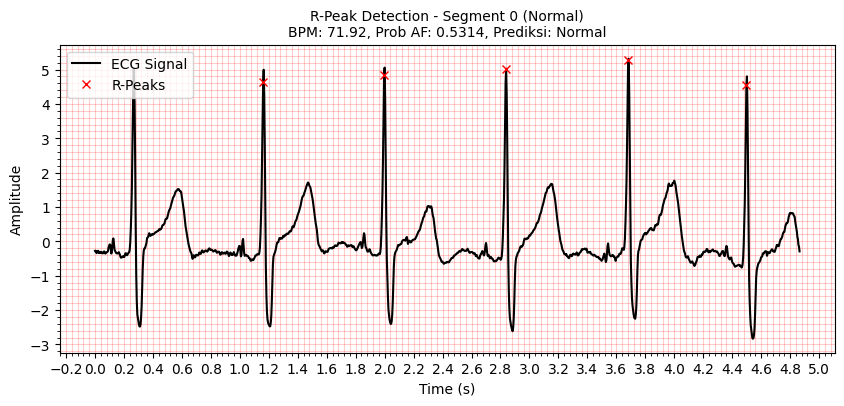

Data CSV diproses: 26 segmen
RR Features for Segment 0: [3.06786490e-02 7.44857936e+00 8.21415473e+00 1.00664273e+02]
Scaler dimuat dari 'processed_data.pkl'
Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 2.
Memuat model terbaik dari fold 1 di best_model_lstm_layer_fold_2.h5



Hasil Prediksi untuk 26 Segmen:
Segmen 1: Probabilitas AF = 0.6292, Prediksi = Normal
Segmen 2: Probabilitas AF = 0.4331, Prediksi = Normal
Segmen 3: Probabilitas AF = 0.6588, Prediksi = Normal
Segmen 4: Probabilitas AF = 0.5206, Prediksi = Normal
Segmen 5: Probabilitas AF = 0.6881, Prediksi = Normal
Segmen 6: Probabilitas AF = 0.5842, Prediksi = Normal
Segmen 7: Probabilitas AF = 0.6784, Prediksi = Normal
Segmen 8: Probabilitas AF = 0.6590, Prediksi = Normal
Segmen 9: Probabilitas AF = 0.6839, Prediksi = Normal
Segmen 10: Probabilitas AF = 0.5698, Prediksi = Normal
Segmen 11: Probabilitas AF = 0.5553, Prediksi = Normal
Segmen 12: Probabilitas AF = 0.5183, Prediksi = Normal
Segmen 13: Probabilitas AF = 0.4817, Prediksi = Normal
Segmen 14: Probabilitas AF = 0.5941, Prediksi = Normal
Segmen 15: Probabilitas AF = 0.6083, Prediksi = Normal
Segmen 16: Probabilitas AF = 0.4593, Prediksi = Normal
Segmen 17: Probabilitas AF = 0.5348, Prediksi = Normal
Segmen 18: Probabilitas AF = 0.4418, Pred

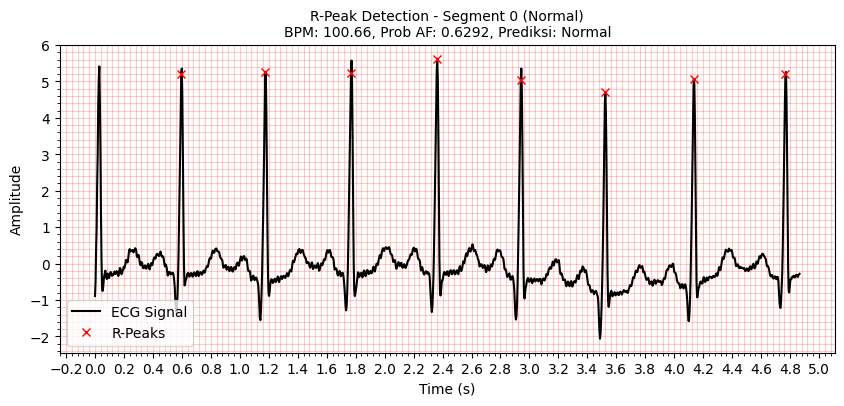

In [6]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import neurokit2 as nk
from scipy.signal import butter, filtfilt, detrend, iirnotch, resample, welch
from scipy.stats import entropy
import pywt

# Required functions (unchanged except for debugging options)
def bandpass_filter(signal, lowcut=0.5, highcut=40.0, fs=267, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def notch_filter(signal, freq=50.0, fs=267, quality=30.0):
    b, a = iirnotch(freq, quality, fs)
    return filtfilt(b, a, signal)

def wavelet_denoise(signal, wavelet='db6', level=5):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    threshold = np.std(coeffs[-1]) * np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)

def compute_rr_features(signal, fs=267, use_entropy=True, visualize=False, segment_idx=0, label='unknown'):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    try:
        signal_detrended = detrend(signal[:, 0])
        signal_denoised = wavelet_denoise(signal_detrended)
        signal_notched = notch_filter(signal_denoised, freq=50.0, fs=fs)
        signal_filtered = bandpass_filter(signal_notched, lowcut=0.5, highcut=40.0, fs=fs)
        signal_norm = (signal_filtered - np.mean(signal_filtered)) / (np.std(signal_filtered) + 1e-8)
        cleaned = nk.ecg_clean(signal_norm, sampling_rate=fs, method='neurokit')
        rpeaks_info = nk.ecg_findpeaks(cleaned, sampling_rate=fs)
        r_peaks = np.array(rpeaks_info['ECG_R_Peaks'])
        if len(r_peaks) < 2:
            print(f"Peringatan: Hanya {len(r_peaks)} puncak R terdeteksi pada segmen {segment_idx}.")
            return None, None, None
        rr_intervals = np.diff(r_peaks) / fs * 1000
        cv_rr = np.std(rr_intervals) / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        qrs_amplitude = np.max(signal_norm) - np.min(signal_norm)
        bpm = 60000 / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        if use_entropy:
            hist, _ = np.histogram(signal_norm, bins=50, density=True)
            signal_entropy = entropy(hist)
            signal_entropy = (signal_entropy - np.mean(hist)) / (np.std(hist) + 1e-8)
        else:
            freqs, psd = welch(signal_norm, fs=fs, nperseg=256)
            signal_entropy = np.sum(psd)
        if visualize:
            visualize_r_peaks(cleaned, r_peaks, label, fs, segment_idx)
        return rr_intervals, [cv_rr, qrs_amplitude, signal_entropy, bpm], r_peaks
    except Exception as e:
        print(f"Error deteksi puncak R: {e}")
        return None, None, None

def visualize_r_peaks(signal, r_peaks, label, fs=267, segment_idx=0, bpm=None, prob=None):
    if r_peaks is None or len(r_peaks) == 0:
        print("Tidak ada R-peaks untuk divisualisasikan.")
        return
    plt.figure(figsize=(10, 4))
    t = np.arange(len(signal)) / fs
    plt.plot(t, signal, label='ECG Signal', color='black')
    plt.plot(t[r_peaks], signal[r_peaks], 'rx', label='R-Peaks')
    title_str = f'R-Peak Detection - Segment {segment_idx} ({label})'
    if bpm is not None and prob is not None:
        title_str += f'\nBPM: {bpm:.2f}, Prob AF: {prob:.4f}, Prediksi: {label}'
    plt.title(title_str, fontsize=10)
    plt.grid(True, which='both', linestyle='-', alpha=0.2, color='red')
    plt.minorticks_on()
    plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.04))
    plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    plt.gca().yaxis.set_major_locator(ticker.AutoLocator())
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.savefig(f'r_peaks_segment_{segment_idx}_{label}.png', dpi=300)
    plt.show()

def augment_signal(signal, noise_factor=0.1):
    noise = np.random.normal(0, noise_factor, signal.shape)
    scaled_signal = signal * np.random.uniform(0.8, 1.2)
    shifted_signal = scaled_signal + np.random.uniform(-0.2, 0.2)
    return shifted_signal + noise

def normalize_signal(signal):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    signal_norm = (signal - np.mean(signal, axis=0)) / (np.std(signal, axis=0) + 1e-8)
    return signal_norm

def load_and_process_csv(csv_file, segment_length=1300, fs=267, disable_augmentation=False):
    df = pd.read_csv(csv_file)
    signal = df['ECG'].values
    original_fs = 250  # Based on 0.004s interval
    if original_fs != fs:
        target_samples = int(len(signal) * (fs / original_fs))
        signal = resample(signal, target_samples)
    if len(signal) < segment_length:
        print(f"Panjang sinyal ({len(signal)}) kurang dari {segment_length}. Tidak dapat memroses.")
        return None, None, None
    segments, rr_features_list, r_peaks_list = [], [], []
    step = int(segment_length * 0.5)
    for i in range(0, len(signal) - segment_length, step):
        segment = signal[i:i + segment_length]
        if len(segment) != segment_length:
            continue
        segment_norm = normalize_signal(segment)
        segment_augmented = segment_norm if disable_augmentation else augment_signal(segment_norm)
        rr_intervals, features, r_peaks = compute_rr_features(segment, fs=fs)
        if rr_intervals is None or features is None:
            continue
        segments.append(segment_augmented)
        rr_features_list.append(features)
        r_peaks_list.append(r_peaks)
    if not segments:
        print("Tidak ada segmen yang valid setelah pemrosesan.")
        return None, None, None
    segments = np.array(segments)
    rr_features_list = np.array(rr_features_list)
    segments = segments.reshape(segments.shape[0], segment_length, 1)
    return segments, rr_features_list, r_peaks_list

def select_best_model(fold_scores, base_path='best_model_lstm_layer_fold_2.h5'):
    if not fold_scores:
        print("Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 2.")
        best_fold = 1
    else:
        best_fold = np.argmax(fold_scores) + 1
    model_path = base_path.format(best_fold)
    if os.path.exists(model_path):
        print(f"Memuat model terbaik dari fold {best_fold} di {model_path}")
        model = load_model(model_path)
        return model, best_fold
    else:
        print(f"Model untuk fold {best_fold} tidak ditemukan di {model_path}")
        return None, None

def predict_with_model(model, scaler, X_test, rr_features_test, threshold=0.5):
    rr_features_norm = scaler.transform(rr_features_test)
    predictions = model.predict([X_test, rr_features_norm], verbose=0)
    predictions_binary = (predictions > threshold).astype(int).flatten()
    return predictions, predictions_binary

# Main execution
csv_file = r'D:\Tugas Akhir\Pemodelan\CNN_LSTM\Recording Perbandingan\3_Wanita_22th_Syalsa\3_Wanita_22th.csv'  # Ganti dengan path file CSV kamu
segment_length = 1300
fs = 267

# 1. Muat dan proses data CSV with debugging option
X_test, rr_features_test, r_peaks_test = load_and_process_csv(csv_file, segment_length, fs, disable_augmentation=True)
if X_test is None:
    print("Gagal memroses data CSV. Program dihentikan.")
    exit()

print(f"Data CSV diproses: {X_test.shape[0]} segmen")
print(f"RR Features for Segment 0: {rr_features_test[0]}")  # Debug RR features

# 2. Muat scaler dan data yang disimpan
data_dict = joblib.load('processed_data.pkl')
scaler = data_dict['scaler']
print("Scaler dimuat dari 'processed_data.pkl'")

# 3. Pilih model terbaik berdasarkan fold_scores
fold_scores = []  # Ganti dengan daftar fold_scores dari K-Fold CV
# Contoh: fold_scores = [0.95, 0.92, 0.96, 0.93, 0.94]
model, best_fold = select_best_model(fold_scores)
if model is None:
    print("Gagal memuat model terbaik. Program dihentikan.")
    exit()

# 4. Lakukan prediksi with adjustable threshold
predictions, predictions_binary = predict_with_model(model, scaler, X_test, rr_features_test, threshold=0.7)

# 5. Tampilkan hasil prediksi
print(f"\nHasil Prediksi untuk {X_test.shape[0]} Segmen:")
for i, (prob, label) in enumerate(zip(predictions.flatten(), predictions_binary)):
    label_str = 'AF' if label == 1 else 'Normal'
    print(f"Segmen {i+1}: Probabilitas AF = {prob:.4f}, Prediksi = {label_str}")

# 6. Visualisasi sinyal dan R-peaks untuk segmen pertama
if X_test.shape[0] > 0:
    label = 'AF' if predictions_binary[0] == 1 else 'Normal'
    bpm = rr_features_test[0][3]
    prob = predictions[0][0]
    visualize_r_peaks(X_test[0].flatten(), r_peaks_test[0], label, fs=fs, segment_idx=0, bpm=bpm, prob=prob)

Data CSV diproses: 26 segmen
RR Features for Segment 0: [2.64906471e-02 6.65102907e+00 8.10877461e+00 8.43157895e+01]
Scaler dimuat dari 'processed_data.pkl'
Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 2.
Memuat model terbaik dari fold 1 di best_model_lstm_layer_fold_2.h5

Hasil Prediksi untuk 26 Segmen:
Segmen 1: Probabilitas AF = 0.7036, Prediksi = AF
Segmen 2: Probabilitas AF = 0.7126, Prediksi = AF
Segmen 3: Probabilitas AF = 0.6716, Prediksi = Normal
Segmen 4: Probabilitas AF = 0.6687, Prediksi = Normal
Segmen 5: Probabilitas AF = 0.7774, Prediksi = AF
Segmen 6: Probabilitas AF = 0.7619, Prediksi = AF
Segmen 7: Probabilitas AF = 0.7663, Prediksi = AF
Segmen 8: Probabilitas AF = 0.7664, Prediksi = AF
Segmen 9: Probabilitas AF = 0.7557, Prediksi = AF
Segmen 10: Probabilitas AF = 0.7514, Prediksi = AF
Segmen 11: Probabilitas AF = 0.4413, Prediksi = Normal
Segmen 12: Probabilitas AF = 0.7175, Prediksi = AF
Segmen 13: Probabilitas AF = 0.5757, Prediksi = Normal
Segme

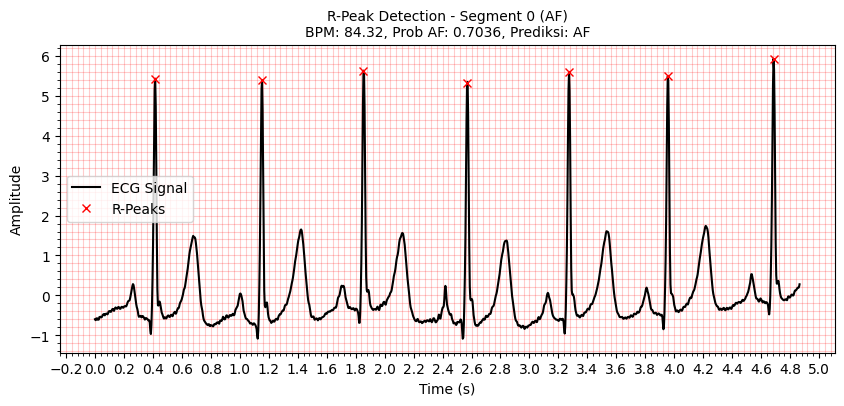

In [7]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import neurokit2 as nk
from scipy.signal import butter, filtfilt, detrend, iirnotch, resample, welch
from scipy.stats import entropy
import pywt

# Required functions (unchanged except for debugging options)
def bandpass_filter(signal, lowcut=0.5, highcut=40.0, fs=267, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def notch_filter(signal, freq=50.0, fs=267, quality=30.0):
    b, a = iirnotch(freq, quality, fs)
    return filtfilt(b, a, signal)

def wavelet_denoise(signal, wavelet='db6', level=5):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    threshold = np.std(coeffs[-1]) * np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)

def compute_rr_features(signal, fs=267, use_entropy=True, visualize=False, segment_idx=0, label='unknown'):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    try:
        signal_detrended = detrend(signal[:, 0])
        signal_denoised = wavelet_denoise(signal_detrended)
        signal_notched = notch_filter(signal_denoised, freq=50.0, fs=fs)
        signal_filtered = bandpass_filter(signal_notched, lowcut=0.5, highcut=40.0, fs=fs)
        signal_norm = (signal_filtered - np.mean(signal_filtered)) / (np.std(signal_filtered) + 1e-8)
        cleaned = nk.ecg_clean(signal_norm, sampling_rate=fs, method='neurokit')
        rpeaks_info = nk.ecg_findpeaks(cleaned, sampling_rate=fs)
        r_peaks = np.array(rpeaks_info['ECG_R_Peaks'])
        if len(r_peaks) < 2:
            print(f"Peringatan: Hanya {len(r_peaks)} puncak R terdeteksi pada segmen {segment_idx}.")
            return None, None, None
        rr_intervals = np.diff(r_peaks) / fs * 1000
        cv_rr = np.std(rr_intervals) / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        qrs_amplitude = np.max(signal_norm) - np.min(signal_norm)
        bpm = 60000 / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        if use_entropy:
            hist, _ = np.histogram(signal_norm, bins=50, density=True)
            signal_entropy = entropy(hist)
            signal_entropy = (signal_entropy - np.mean(hist)) / (np.std(hist) + 1e-8)
        else:
            freqs, psd = welch(signal_norm, fs=fs, nperseg=256)
            signal_entropy = np.sum(psd)
        if visualize:
            visualize_r_peaks(cleaned, r_peaks, label, fs, segment_idx)
        return rr_intervals, [cv_rr, qrs_amplitude, signal_entropy, bpm], r_peaks
    except Exception as e:
        print(f"Error deteksi puncak R: {e}")
        return None, None, None

def visualize_r_peaks(signal, r_peaks, label, fs=267, segment_idx=0, bpm=None, prob=None):
    if r_peaks is None or len(r_peaks) == 0:
        print("Tidak ada R-peaks untuk divisualisasikan.")
        return
    plt.figure(figsize=(10, 4))
    t = np.arange(len(signal)) / fs
    plt.plot(t, signal, label='ECG Signal', color='black')
    plt.plot(t[r_peaks], signal[r_peaks], 'rx', label='R-Peaks')
    title_str = f'R-Peak Detection - Segment {segment_idx} ({label})'
    if bpm is not None and prob is not None:
        title_str += f'\nBPM: {bpm:.2f}, Prob AF: {prob:.4f}, Prediksi: {label}'
    plt.title(title_str, fontsize=10)
    plt.grid(True, which='both', linestyle='-', alpha=0.2, color='red')
    plt.minorticks_on()
    plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.04))
    plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    plt.gca().yaxis.set_major_locator(ticker.AutoLocator())
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.savefig(f'r_peaks_segment_{segment_idx}_{label}.png', dpi=300)
    plt.show()

def augment_signal(signal, noise_factor=0.1):
    noise = np.random.normal(0, noise_factor, signal.shape)
    scaled_signal = signal * np.random.uniform(0.8, 1.2)
    shifted_signal = scaled_signal + np.random.uniform(-0.2, 0.2)
    return shifted_signal + noise

def normalize_signal(signal):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    signal_norm = (signal - np.mean(signal, axis=0)) / (np.std(signal, axis=0) + 1e-8)
    return signal_norm

def load_and_process_csv(csv_file, segment_length=1300, fs=267, disable_augmentation=False):
    df = pd.read_csv(csv_file)
    signal = df['ECG'].values
    original_fs = 250  # Based on 0.004s interval
    if original_fs != fs:
        target_samples = int(len(signal) * (fs / original_fs))
        signal = resample(signal, target_samples)
    if len(signal) < segment_length:
        print(f"Panjang sinyal ({len(signal)}) kurang dari {segment_length}. Tidak dapat memroses.")
        return None, None, None
    segments, rr_features_list, r_peaks_list = [], [], []
    step = int(segment_length * 0.5)
    for i in range(0, len(signal) - segment_length, step):
        segment = signal[i:i + segment_length]
        if len(segment) != segment_length:
            continue
        segment_norm = normalize_signal(segment)
        segment_augmented = segment_norm if disable_augmentation else augment_signal(segment_norm)
        rr_intervals, features, r_peaks = compute_rr_features(segment, fs=fs)
        if rr_intervals is None or features is None:
            continue
        segments.append(segment_augmented)
        rr_features_list.append(features)
        r_peaks_list.append(r_peaks)
    if not segments:
        print("Tidak ada segmen yang valid setelah pemrosesan.")
        return None, None, None
    segments = np.array(segments)
    rr_features_list = np.array(rr_features_list)
    segments = segments.reshape(segments.shape[0], segment_length, 1)
    return segments, rr_features_list, r_peaks_list

def select_best_model(fold_scores, base_path='best_model_lstm_layer_fold_2.h5'):
    if not fold_scores:
        print("Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 2.")
        best_fold = 1
    else:
        best_fold = np.argmax(fold_scores) + 1
    model_path = base_path.format(best_fold)
    if os.path.exists(model_path):
        print(f"Memuat model terbaik dari fold {best_fold} di {model_path}")
        model = load_model(model_path)
        return model, best_fold
    else:
        print(f"Model untuk fold {best_fold} tidak ditemukan di {model_path}")
        return None, None

def predict_with_model(model, scaler, X_test, rr_features_test, threshold=0.5):
    rr_features_norm = scaler.transform(rr_features_test)
    predictions = model.predict([X_test, rr_features_norm], verbose=0)
    predictions_binary = (predictions > threshold).astype(int).flatten()
    return predictions, predictions_binary

# Main execution
csv_file = r'D:\Tugas Akhir\Pemodelan\CNN_LSTM\Recording Perbandingan\4_Wanita_22th_Fallerina\4_Wanita_22th.csv'  # Ganti dengan path file CSV kamu
segment_length = 1300
fs = 267

# 1. Muat dan proses data CSV with debugging option
X_test, rr_features_test, r_peaks_test = load_and_process_csv(csv_file, segment_length, fs, disable_augmentation=True)
if X_test is None:
    print("Gagal memroses data CSV. Program dihentikan.")
    exit()

print(f"Data CSV diproses: {X_test.shape[0]} segmen")
print(f"RR Features for Segment 0: {rr_features_test[0]}")  # Debug RR features

# 2. Muat scaler dan data yang disimpan
data_dict = joblib.load('processed_data.pkl')
scaler = data_dict['scaler']
print("Scaler dimuat dari 'processed_data.pkl'")

# 3. Pilih model terbaik berdasarkan fold_scores
fold_scores = []  # Ganti dengan daftar fold_scores dari K-Fold CV
# Contoh: fold_scores = [0.95, 0.92, 0.96, 0.93, 0.94]
model, best_fold = select_best_model(fold_scores)
if model is None:
    print("Gagal memuat model terbaik. Program dihentikan.")
    exit()

# 4. Lakukan prediksi with adjustable threshold
predictions, predictions_binary = predict_with_model(model, scaler, X_test, rr_features_test, threshold=0.7)

# 5. Tampilkan hasil prediksi
print(f"\nHasil Prediksi untuk {X_test.shape[0]} Segmen:")
for i, (prob, label) in enumerate(zip(predictions.flatten(), predictions_binary)):
    label_str = 'AF' if label == 1 else 'Normal'
    print(f"Segmen {i+1}: Probabilitas AF = {prob:.4f}, Prediksi = {label_str}")

# 6. Visualisasi sinyal dan R-peaks untuk segmen pertama
if X_test.shape[0] > 0:
    label = 'AF' if predictions_binary[0] == 1 else 'Normal'
    bpm = rr_features_test[0][3]
    prob = predictions[0][0]
    visualize_r_peaks(X_test[0].flatten(), r_peaks_test[0], label, fs=fs, segment_idx=0, bpm=bpm, prob=prob)

Data CSV diproses: 26 segmen
RR Features for Segment 0: [4.72100890e-02 9.20130941e+00 1.30614701e+01 7.20323741e+01]
Scaler dimuat dari 'processed_data.pkl'
Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 2.
Memuat model terbaik dari fold 1 di best_model_lstm_layer_fold_2.h5

Hasil Prediksi untuk 26 Segmen:
Segmen 1: Probabilitas AF = 0.3773, Prediksi = Normal
Segmen 2: Probabilitas AF = 0.3816, Prediksi = Normal
Segmen 3: Probabilitas AF = 0.3900, Prediksi = Normal
Segmen 4: Probabilitas AF = 0.4827, Prediksi = Normal
Segmen 5: Probabilitas AF = 0.4980, Prediksi = Normal
Segmen 6: Probabilitas AF = 0.4487, Prediksi = Normal
Segmen 7: Probabilitas AF = 0.5111, Prediksi = Normal
Segmen 8: Probabilitas AF = 0.4129, Prediksi = Normal
Segmen 9: Probabilitas AF = 0.4584, Prediksi = Normal
Segmen 10: Probabilitas AF = 0.3977, Prediksi = Normal
Segmen 11: Probabilitas AF = 0.3763, Prediksi = Normal
Segmen 12: Probabilitas AF = 0.3506, Prediksi = Normal
Segmen 13: Probabilitas 

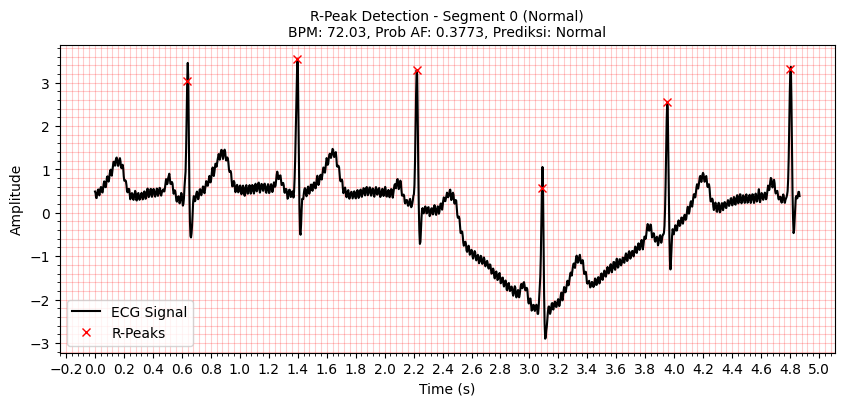

In [8]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import neurokit2 as nk
from scipy.signal import butter, filtfilt, detrend, iirnotch, resample, welch
from scipy.stats import entropy
import pywt

# Required functions (unchanged except for debugging options)
def bandpass_filter(signal, lowcut=0.5, highcut=40.0, fs=267, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def notch_filter(signal, freq=50.0, fs=267, quality=30.0):
    b, a = iirnotch(freq, quality, fs)
    return filtfilt(b, a, signal)

def wavelet_denoise(signal, wavelet='db6', level=5):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    threshold = np.std(coeffs[-1]) * np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)

def compute_rr_features(signal, fs=267, use_entropy=True, visualize=False, segment_idx=0, label='unknown'):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    try:
        signal_detrended = detrend(signal[:, 0])
        signal_denoised = wavelet_denoise(signal_detrended)
        signal_notched = notch_filter(signal_denoised, freq=50.0, fs=fs)
        signal_filtered = bandpass_filter(signal_notched, lowcut=0.5, highcut=40.0, fs=fs)
        signal_norm = (signal_filtered - np.mean(signal_filtered)) / (np.std(signal_filtered) + 1e-8)
        cleaned = nk.ecg_clean(signal_norm, sampling_rate=fs, method='neurokit')
        rpeaks_info = nk.ecg_findpeaks(cleaned, sampling_rate=fs)
        r_peaks = np.array(rpeaks_info['ECG_R_Peaks'])
        if len(r_peaks) < 2:
            print(f"Peringatan: Hanya {len(r_peaks)} puncak R terdeteksi pada segmen {segment_idx}.")
            return None, None, None
        rr_intervals = np.diff(r_peaks) / fs * 1000
        cv_rr = np.std(rr_intervals) / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        qrs_amplitude = np.max(signal_norm) - np.min(signal_norm)
        bpm = 60000 / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        if use_entropy:
            hist, _ = np.histogram(signal_norm, bins=50, density=True)
            signal_entropy = entropy(hist)
            signal_entropy = (signal_entropy - np.mean(hist)) / (np.std(hist) + 1e-8)
        else:
            freqs, psd = welch(signal_norm, fs=fs, nperseg=256)
            signal_entropy = np.sum(psd)
        if visualize:
            visualize_r_peaks(cleaned, r_peaks, label, fs, segment_idx)
        return rr_intervals, [cv_rr, qrs_amplitude, signal_entropy, bpm], r_peaks
    except Exception as e:
        print(f"Error deteksi puncak R: {e}")
        return None, None, None

def visualize_r_peaks(signal, r_peaks, label, fs=267, segment_idx=0, bpm=None, prob=None):
    if r_peaks is None or len(r_peaks) == 0:
        print("Tidak ada R-peaks untuk divisualisasikan.")
        return
    plt.figure(figsize=(10, 4))
    t = np.arange(len(signal)) / fs
    plt.plot(t, signal, label='ECG Signal', color='black')
    plt.plot(t[r_peaks], signal[r_peaks], 'rx', label='R-Peaks')
    title_str = f'R-Peak Detection - Segment {segment_idx} ({label})'
    if bpm is not None and prob is not None:
        title_str += f'\nBPM: {bpm:.2f}, Prob AF: {prob:.4f}, Prediksi: {label}'
    plt.title(title_str, fontsize=10)
    plt.grid(True, which='both', linestyle='-', alpha=0.2, color='red')
    plt.minorticks_on()
    plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.04))
    plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    plt.gca().yaxis.set_major_locator(ticker.AutoLocator())
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.savefig(f'r_peaks_segment_{segment_idx}_{label}.png', dpi=300)
    plt.show()

def augment_signal(signal, noise_factor=0.1):
    noise = np.random.normal(0, noise_factor, signal.shape)
    scaled_signal = signal * np.random.uniform(0.8, 1.2)
    shifted_signal = scaled_signal + np.random.uniform(-0.2, 0.2)
    return shifted_signal + noise

def normalize_signal(signal):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    signal_norm = (signal - np.mean(signal, axis=0)) / (np.std(signal, axis=0) + 1e-8)
    return signal_norm

def load_and_process_csv(csv_file, segment_length=1300, fs=267, disable_augmentation=False):
    df = pd.read_csv(csv_file)
    signal = df['ECG'].values
    original_fs = 250  # Based on 0.004s interval
    if original_fs != fs:
        target_samples = int(len(signal) * (fs / original_fs))
        signal = resample(signal, target_samples)
    if len(signal) < segment_length:
        print(f"Panjang sinyal ({len(signal)}) kurang dari {segment_length}. Tidak dapat memroses.")
        return None, None, None
    segments, rr_features_list, r_peaks_list = [], [], []
    step = int(segment_length * 0.5)
    for i in range(0, len(signal) - segment_length, step):
        segment = signal[i:i + segment_length]
        if len(segment) != segment_length:
            continue
        segment_norm = normalize_signal(segment)
        segment_augmented = segment_norm if disable_augmentation else augment_signal(segment_norm)
        rr_intervals, features, r_peaks = compute_rr_features(segment, fs=fs)
        if rr_intervals is None or features is None:
            continue
        segments.append(segment_augmented)
        rr_features_list.append(features)
        r_peaks_list.append(r_peaks)
    if not segments:
        print("Tidak ada segmen yang valid setelah pemrosesan.")
        return None, None, None
    segments = np.array(segments)
    rr_features_list = np.array(rr_features_list)
    segments = segments.reshape(segments.shape[0], segment_length, 1)
    return segments, rr_features_list, r_peaks_list

def select_best_model(fold_scores, base_path='best_model_lstm_layer_fold_2.h5'):
    if not fold_scores:
        print("Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 2.")
        best_fold = 1
    else:
        best_fold = np.argmax(fold_scores) + 1
    model_path = base_path.format(best_fold)
    if os.path.exists(model_path):
        print(f"Memuat model terbaik dari fold {best_fold} di {model_path}")
        model = load_model(model_path)
        return model, best_fold
    else:
        print(f"Model untuk fold {best_fold} tidak ditemukan di {model_path}")
        return None, None

def predict_with_model(model, scaler, X_test, rr_features_test, threshold=0.5):
    rr_features_norm = scaler.transform(rr_features_test)
    predictions = model.predict([X_test, rr_features_norm], verbose=0)
    predictions_binary = (predictions > threshold).astype(int).flatten()
    return predictions, predictions_binary

# Main execution
csv_file = r'D:\Tugas Akhir\Pemodelan\CNN_LSTM\Recording Perbandingan\5_Wanita_21th_Wina\5_Wanita_21th.csv'  # Ganti dengan path file CSV kamu
segment_length = 1300
fs = 267

# 1. Muat dan proses data CSV with debugging option
X_test, rr_features_test, r_peaks_test = load_and_process_csv(csv_file, segment_length, fs, disable_augmentation=True)
if X_test is None:
    print("Gagal memroses data CSV. Program dihentikan.")
    exit()

print(f"Data CSV diproses: {X_test.shape[0]} segmen")
print(f"RR Features for Segment 0: {rr_features_test[0]}")  # Debug RR features

# 2. Muat scaler dan data yang disimpan
data_dict = joblib.load('processed_data.pkl')
scaler = data_dict['scaler']
print("Scaler dimuat dari 'processed_data.pkl'")

# 3. Pilih model terbaik berdasarkan fold_scores
fold_scores = []  # Ganti dengan daftar fold_scores dari K-Fold CV
# Contoh: fold_scores = [0.95, 0.92, 0.96, 0.93, 0.94]
model, best_fold = select_best_model(fold_scores)
if model is None:
    print("Gagal memuat model terbaik. Program dihentikan.")
    exit()

# 4. Lakukan prediksi with adjustable threshold
predictions, predictions_binary = predict_with_model(model, scaler, X_test, rr_features_test, threshold=0.7)

# 5. Tampilkan hasil prediksi
print(f"\nHasil Prediksi untuk {X_test.shape[0]} Segmen:")
for i, (prob, label) in enumerate(zip(predictions.flatten(), predictions_binary)):
    label_str = 'AF' if label == 1 else 'Normal'
    print(f"Segmen {i+1}: Probabilitas AF = {prob:.4f}, Prediksi = {label_str}")

# 6. Visualisasi sinyal dan R-peaks untuk segmen pertama
if X_test.shape[0] > 0:
    label = 'AF' if predictions_binary[0] == 1 else 'Normal'
    bpm = rr_features_test[0][3]
    prob = predictions[0][0]
    visualize_r_peaks(X_test[0].flatten(), r_peaks_test[0], label, fs=fs, segment_idx=0, bpm=bpm, prob=prob)

Data CSV diproses: 26 segmen
RR Features for Segment 0: [1.93171332e-02 7.70033186e+00 9.00534048e+00 8.22381930e+01]
Scaler dimuat dari 'processed_data.pkl'
Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 2.
Memuat model terbaik dari fold 1 di best_model_lstm_layer_fold_2.h5

Hasil Prediksi untuk 26 Segmen:
Segmen 1: Probabilitas AF = 0.6458, Prediksi = Normal
Segmen 2: Probabilitas AF = 0.6126, Prediksi = Normal
Segmen 3: Probabilitas AF = 0.7199, Prediksi = AF
Segmen 4: Probabilitas AF = 0.7138, Prediksi = AF
Segmen 5: Probabilitas AF = 0.6745, Prediksi = Normal
Segmen 6: Probabilitas AF = 0.4926, Prediksi = Normal
Segmen 7: Probabilitas AF = 0.4148, Prediksi = Normal
Segmen 8: Probabilitas AF = 0.5253, Prediksi = Normal
Segmen 9: Probabilitas AF = 0.6082, Prediksi = Normal
Segmen 10: Probabilitas AF = 0.5529, Prediksi = Normal
Segmen 11: Probabilitas AF = 0.6410, Prediksi = Normal
Segmen 12: Probabilitas AF = 0.6646, Prediksi = Normal
Segmen 13: Probabilitas AF = 0.6

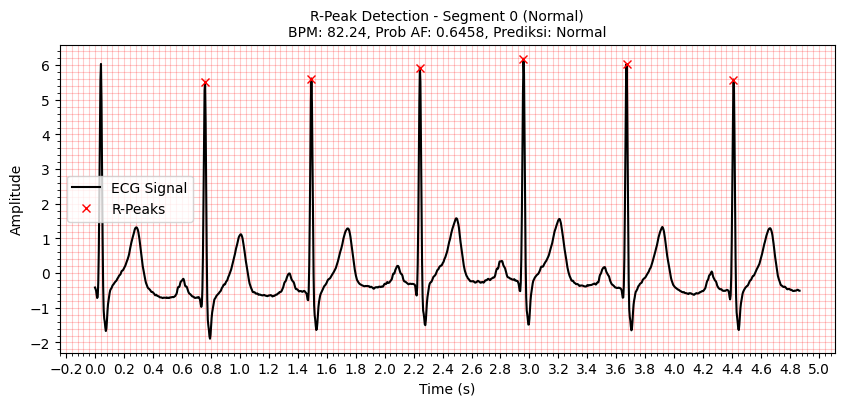

In [10]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import neurokit2 as nk
from scipy.signal import butter, filtfilt, detrend, iirnotch, resample, welch
from scipy.stats import entropy
import pywt

# Required functions (unchanged except for debugging options)
def bandpass_filter(signal, lowcut=0.5, highcut=40.0, fs=267, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def notch_filter(signal, freq=50.0, fs=267, quality=30.0):
    b, a = iirnotch(freq, quality, fs)
    return filtfilt(b, a, signal)

def wavelet_denoise(signal, wavelet='db6', level=5):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    threshold = np.std(coeffs[-1]) * np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)

def compute_rr_features(signal, fs=267, use_entropy=True, visualize=False, segment_idx=0, label='unknown'):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    try:
        signal_detrended = detrend(signal[:, 0])
        signal_denoised = wavelet_denoise(signal_detrended)
        signal_notched = notch_filter(signal_denoised, freq=50.0, fs=fs)
        signal_filtered = bandpass_filter(signal_notched, lowcut=0.5, highcut=40.0, fs=fs)
        signal_norm = (signal_filtered - np.mean(signal_filtered)) / (np.std(signal_filtered) + 1e-8)
        cleaned = nk.ecg_clean(signal_norm, sampling_rate=fs, method='neurokit')
        rpeaks_info = nk.ecg_findpeaks(cleaned, sampling_rate=fs)
        r_peaks = np.array(rpeaks_info['ECG_R_Peaks'])
        if len(r_peaks) < 2:
            print(f"Peringatan: Hanya {len(r_peaks)} puncak R terdeteksi pada segmen {segment_idx}.")
            return None, None, None
        rr_intervals = np.diff(r_peaks) / fs * 1000
        cv_rr = np.std(rr_intervals) / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        qrs_amplitude = np.max(signal_norm) - np.min(signal_norm)
        bpm = 60000 / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        if use_entropy:
            hist, _ = np.histogram(signal_norm, bins=50, density=True)
            signal_entropy = entropy(hist)
            signal_entropy = (signal_entropy - np.mean(hist)) / (np.std(hist) + 1e-8)
        else:
            freqs, psd = welch(signal_norm, fs=fs, nperseg=256)
            signal_entropy = np.sum(psd)
        if visualize:
            visualize_r_peaks(cleaned, r_peaks, label, fs, segment_idx)
        return rr_intervals, [cv_rr, qrs_amplitude, signal_entropy, bpm], r_peaks
    except Exception as e:
        print(f"Error deteksi puncak R: {e}")
        return None, None, None

def visualize_r_peaks(signal, r_peaks, label, fs=267, segment_idx=0, bpm=None, prob=None):
    if r_peaks is None or len(r_peaks) == 0:
        print("Tidak ada R-peaks untuk divisualisasikan.")
        return
    plt.figure(figsize=(10, 4))
    t = np.arange(len(signal)) / fs
    plt.plot(t, signal, label='ECG Signal', color='black')
    plt.plot(t[r_peaks], signal[r_peaks], 'rx', label='R-Peaks')
    title_str = f'R-Peak Detection - Segment {segment_idx} ({label})'
    if bpm is not None and prob is not None:
        title_str += f'\nBPM: {bpm:.2f}, Prob AF: {prob:.4f}, Prediksi: {label}'
    plt.title(title_str, fontsize=10)
    plt.grid(True, which='both', linestyle='-', alpha=0.2, color='red')
    plt.minorticks_on()
    plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.04))
    plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    plt.gca().yaxis.set_major_locator(ticker.AutoLocator())
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.savefig(f'r_peaks_segment_{segment_idx}_{label}.png', dpi=300)
    plt.show()

def augment_signal(signal, noise_factor=0.1):
    noise = np.random.normal(0, noise_factor, signal.shape)
    scaled_signal = signal * np.random.uniform(0.8, 1.2)
    shifted_signal = scaled_signal + np.random.uniform(-0.2, 0.2)
    return shifted_signal + noise

def normalize_signal(signal):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    signal_norm = (signal - np.mean(signal, axis=0)) / (np.std(signal, axis=0) + 1e-8)
    return signal_norm

def load_and_process_csv(csv_file, segment_length=1300, fs=267, disable_augmentation=False):
    df = pd.read_csv(csv_file)
    signal = df['ECG'].values
    original_fs = 250  # Based on 0.004s interval
    if original_fs != fs:
        target_samples = int(len(signal) * (fs / original_fs))
        signal = resample(signal, target_samples)
    if len(signal) < segment_length:
        print(f"Panjang sinyal ({len(signal)}) kurang dari {segment_length}. Tidak dapat memroses.")
        return None, None, None
    segments, rr_features_list, r_peaks_list = [], [], []
    step = int(segment_length * 0.5)
    for i in range(0, len(signal) - segment_length, step):
        segment = signal[i:i + segment_length]
        if len(segment) != segment_length:
            continue
        segment_norm = normalize_signal(segment)
        segment_augmented = segment_norm if disable_augmentation else augment_signal(segment_norm)
        rr_intervals, features, r_peaks = compute_rr_features(segment, fs=fs)
        if rr_intervals is None or features is None:
            continue
        segments.append(segment_augmented)
        rr_features_list.append(features)
        r_peaks_list.append(r_peaks)
    if not segments:
        print("Tidak ada segmen yang valid setelah pemrosesan.")
        return None, None, None
    segments = np.array(segments)
    rr_features_list = np.array(rr_features_list)
    segments = segments.reshape(segments.shape[0], segment_length, 1)
    return segments, rr_features_list, r_peaks_list

def select_best_model(fold_scores, base_path='best_model_lstm_layer_fold_2.h5'):
    if not fold_scores:
        print("Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 2.")
        best_fold = 1
    else:
        best_fold = np.argmax(fold_scores) + 1
    model_path = base_path.format(best_fold)
    if os.path.exists(model_path):
        print(f"Memuat model terbaik dari fold {best_fold} di {model_path}")
        model = load_model(model_path)
        return model, best_fold
    else:
        print(f"Model untuk fold {best_fold} tidak ditemukan di {model_path}")
        return None, None

def predict_with_model(model, scaler, X_test, rr_features_test, threshold=0.5):
    rr_features_norm = scaler.transform(rr_features_test)
    predictions = model.predict([X_test, rr_features_norm], verbose=0)
    predictions_binary = (predictions > threshold).astype(int).flatten()
    return predictions, predictions_binary

# Main execution
csv_file = r'D:\Tugas Akhir\Pemodelan\CNN_LSTM\Recording Perbandingan\6_Pria_22th_Mayco\6_Pria_22th.csv'  # Ganti dengan path file CSV kamu
segment_length = 1300
fs = 267

# 1. Muat dan proses data CSV with debugging option
X_test, rr_features_test, r_peaks_test = load_and_process_csv(csv_file, segment_length, fs, disable_augmentation=True)
if X_test is None:
    print("Gagal memroses data CSV. Program dihentikan.")
    exit()

print(f"Data CSV diproses: {X_test.shape[0]} segmen")
print(f"RR Features for Segment 0: {rr_features_test[0]}")  # Debug RR features

# 2. Muat scaler dan data yang disimpan
data_dict = joblib.load('processed_data.pkl')
scaler = data_dict['scaler']
print("Scaler dimuat dari 'processed_data.pkl'")

# 3. Pilih model terbaik berdasarkan fold_scores
fold_scores = []  # Ganti dengan daftar fold_scores dari K-Fold CV
# Contoh: fold_scores = [0.95, 0.92, 0.96, 0.93, 0.94]
model, best_fold = select_best_model(fold_scores)
if model is None:
    print("Gagal memuat model terbaik. Program dihentikan.")
    exit()

# 4. Lakukan prediksi with adjustable threshold
predictions, predictions_binary = predict_with_model(model, scaler, X_test, rr_features_test, threshold=0.7)

# 5. Tampilkan hasil prediksi
print(f"\nHasil Prediksi untuk {X_test.shape[0]} Segmen:")
for i, (prob, label) in enumerate(zip(predictions.flatten(), predictions_binary)):
    label_str = 'AF' if label == 1 else 'Normal'
    print(f"Segmen {i+1}: Probabilitas AF = {prob:.4f}, Prediksi = {label_str}")

# 6. Visualisasi sinyal dan R-peaks untuk segmen pertama
if X_test.shape[0] > 0:
    label = 'AF' if predictions_binary[0] == 1 else 'Normal'
    bpm = rr_features_test[0][3]
    prob = predictions[0][0]
    visualize_r_peaks(X_test[0].flatten(), r_peaks_test[0], label, fs=fs, segment_idx=0, bpm=bpm, prob=prob)

Data CSV diproses: 26 segmen
RR Features for Segment 0: [3.79138409e-02 8.64663743e+00 1.01039763e+01 7.57805109e+01]
Scaler dimuat dari 'processed_data.pkl'
Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 2.
Memuat model terbaik dari fold 1 di best_model_lstm_layer_fold_2.h5

Hasil Prediksi untuk 26 Segmen:
Segmen 1: Probabilitas AF = 0.5708, Prediksi = Normal
Segmen 2: Probabilitas AF = 0.5407, Prediksi = Normal
Segmen 3: Probabilitas AF = 0.6220, Prediksi = Normal
Segmen 4: Probabilitas AF = 0.5439, Prediksi = Normal
Segmen 5: Probabilitas AF = 0.6496, Prediksi = Normal
Segmen 6: Probabilitas AF = 0.6457, Prediksi = Normal
Segmen 7: Probabilitas AF = 0.4980, Prediksi = Normal
Segmen 8: Probabilitas AF = 0.6171, Prediksi = Normal
Segmen 9: Probabilitas AF = 0.6294, Prediksi = Normal
Segmen 10: Probabilitas AF = 0.5107, Prediksi = Normal
Segmen 11: Probabilitas AF = 0.5219, Prediksi = Normal
Segmen 12: Probabilitas AF = 0.5878, Prediksi = Normal
Segmen 13: Probabilitas 

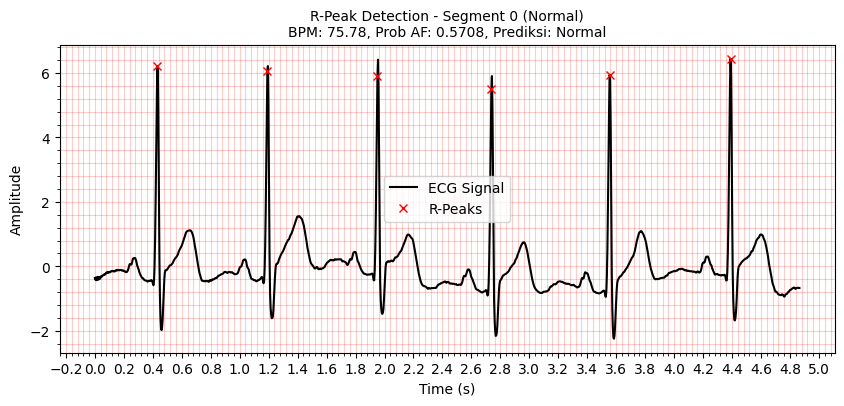

In [11]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import neurokit2 as nk
from scipy.signal import butter, filtfilt, detrend, iirnotch, resample, welch
from scipy.stats import entropy
import pywt

# Required functions (unchanged except for debugging options)
def bandpass_filter(signal, lowcut=0.5, highcut=40.0, fs=267, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def notch_filter(signal, freq=50.0, fs=267, quality=30.0):
    b, a = iirnotch(freq, quality, fs)
    return filtfilt(b, a, signal)

def wavelet_denoise(signal, wavelet='db6', level=5):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    threshold = np.std(coeffs[-1]) * np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)

def compute_rr_features(signal, fs=267, use_entropy=True, visualize=False, segment_idx=0, label='unknown'):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    try:
        signal_detrended = detrend(signal[:, 0])
        signal_denoised = wavelet_denoise(signal_detrended)
        signal_notched = notch_filter(signal_denoised, freq=50.0, fs=fs)
        signal_filtered = bandpass_filter(signal_notched, lowcut=0.5, highcut=40.0, fs=fs)
        signal_norm = (signal_filtered - np.mean(signal_filtered)) / (np.std(signal_filtered) + 1e-8)
        cleaned = nk.ecg_clean(signal_norm, sampling_rate=fs, method='neurokit')
        rpeaks_info = nk.ecg_findpeaks(cleaned, sampling_rate=fs)
        r_peaks = np.array(rpeaks_info['ECG_R_Peaks'])
        if len(r_peaks) < 2:
            print(f"Peringatan: Hanya {len(r_peaks)} puncak R terdeteksi pada segmen {segment_idx}.")
            return None, None, None
        rr_intervals = np.diff(r_peaks) / fs * 1000
        cv_rr = np.std(rr_intervals) / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        qrs_amplitude = np.max(signal_norm) - np.min(signal_norm)
        bpm = 60000 / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        if use_entropy:
            hist, _ = np.histogram(signal_norm, bins=50, density=True)
            signal_entropy = entropy(hist)
            signal_entropy = (signal_entropy - np.mean(hist)) / (np.std(hist) + 1e-8)
        else:
            freqs, psd = welch(signal_norm, fs=fs, nperseg=256)
            signal_entropy = np.sum(psd)
        if visualize:
            visualize_r_peaks(cleaned, r_peaks, label, fs, segment_idx)
        return rr_intervals, [cv_rr, qrs_amplitude, signal_entropy, bpm], r_peaks
    except Exception as e:
        print(f"Error deteksi puncak R: {e}")
        return None, None, None

def visualize_r_peaks(signal, r_peaks, label, fs=267, segment_idx=0, bpm=None, prob=None):
    if r_peaks is None or len(r_peaks) == 0:
        print("Tidak ada R-peaks untuk divisualisasikan.")
        return
    plt.figure(figsize=(10, 4))
    t = np.arange(len(signal)) / fs
    plt.plot(t, signal, label='ECG Signal', color='black')
    plt.plot(t[r_peaks], signal[r_peaks], 'rx', label='R-Peaks')
    title_str = f'R-Peak Detection - Segment {segment_idx} ({label})'
    if bpm is not None and prob is not None:
        title_str += f'\nBPM: {bpm:.2f}, Prob AF: {prob:.4f}, Prediksi: {label}'
    plt.title(title_str, fontsize=10)
    plt.grid(True, which='both', linestyle='-', alpha=0.2, color='red')
    plt.minorticks_on()
    plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.04))
    plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    plt.gca().yaxis.set_major_locator(ticker.AutoLocator())
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.savefig(f'r_peaks_segment_{segment_idx}_{label}.png', dpi=300)
    plt.show()

def augment_signal(signal, noise_factor=0.1):
    noise = np.random.normal(0, noise_factor, signal.shape)
    scaled_signal = signal * np.random.uniform(0.8, 1.2)
    shifted_signal = scaled_signal + np.random.uniform(-0.2, 0.2)
    return shifted_signal + noise

def normalize_signal(signal):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    signal_norm = (signal - np.mean(signal, axis=0)) / (np.std(signal, axis=0) + 1e-8)
    return signal_norm

def load_and_process_csv(csv_file, segment_length=1300, fs=267, disable_augmentation=False):
    df = pd.read_csv(csv_file)
    signal = df['ECG'].values
    original_fs = 250  # Based on 0.004s interval
    if original_fs != fs:
        target_samples = int(len(signal) * (fs / original_fs))
        signal = resample(signal, target_samples)
    if len(signal) < segment_length:
        print(f"Panjang sinyal ({len(signal)}) kurang dari {segment_length}. Tidak dapat memroses.")
        return None, None, None
    segments, rr_features_list, r_peaks_list = [], [], []
    step = int(segment_length * 0.5)
    for i in range(0, len(signal) - segment_length, step):
        segment = signal[i:i + segment_length]
        if len(segment) != segment_length:
            continue
        segment_norm = normalize_signal(segment)
        segment_augmented = segment_norm if disable_augmentation else augment_signal(segment_norm)
        rr_intervals, features, r_peaks = compute_rr_features(segment, fs=fs)
        if rr_intervals is None or features is None:
            continue
        segments.append(segment_augmented)
        rr_features_list.append(features)
        r_peaks_list.append(r_peaks)
    if not segments:
        print("Tidak ada segmen yang valid setelah pemrosesan.")
        return None, None, None
    segments = np.array(segments)
    rr_features_list = np.array(rr_features_list)
    segments = segments.reshape(segments.shape[0], segment_length, 1)
    return segments, rr_features_list, r_peaks_list

def select_best_model(fold_scores, base_path='best_model_lstm_layer_fold_2.h5'):
    if not fold_scores:
        print("Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 2.")
        best_fold = 1
    else:
        best_fold = np.argmax(fold_scores) + 1
    model_path = base_path.format(best_fold)
    if os.path.exists(model_path):
        print(f"Memuat model terbaik dari fold {best_fold} di {model_path}")
        model = load_model(model_path)
        return model, best_fold
    else:
        print(f"Model untuk fold {best_fold} tidak ditemukan di {model_path}")
        return None, None

def predict_with_model(model, scaler, X_test, rr_features_test, threshold=0.5):
    rr_features_norm = scaler.transform(rr_features_test)
    predictions = model.predict([X_test, rr_features_norm], verbose=0)
    predictions_binary = (predictions > threshold).astype(int).flatten()
    return predictions, predictions_binary

# Main execution
csv_file = r'D:\Tugas Akhir\Pemodelan\CNN_LSTM\Recording Perbandingan\7_Pria_23th_Ade\7_Pria_23th.csv'  # Ganti dengan path file CSV kamu
segment_length = 1300
fs = 267

# 1. Muat dan proses data CSV with debugging option
X_test, rr_features_test, r_peaks_test = load_and_process_csv(csv_file, segment_length, fs, disable_augmentation=True)
if X_test is None:
    print("Gagal memroses data CSV. Program dihentikan.")
    exit()

print(f"Data CSV diproses: {X_test.shape[0]} segmen")
print(f"RR Features for Segment 0: {rr_features_test[0]}")  # Debug RR features

# 2. Muat scaler dan data yang disimpan
data_dict = joblib.load('processed_data.pkl')
scaler = data_dict['scaler']
print("Scaler dimuat dari 'processed_data.pkl'")

# 3. Pilih model terbaik berdasarkan fold_scores
fold_scores = []  # Ganti dengan daftar fold_scores dari K-Fold CV
# Contoh: fold_scores = [0.95, 0.92, 0.96, 0.93, 0.94]
model, best_fold = select_best_model(fold_scores)
if model is None:
    print("Gagal memuat model terbaik. Program dihentikan.")
    exit()

# 4. Lakukan prediksi with adjustable threshold
predictions, predictions_binary = predict_with_model(model, scaler, X_test, rr_features_test, threshold=0.7)

# 5. Tampilkan hasil prediksi
print(f"\nHasil Prediksi untuk {X_test.shape[0]} Segmen:")
for i, (prob, label) in enumerate(zip(predictions.flatten(), predictions_binary)):
    label_str = 'AF' if label == 1 else 'Normal'
    print(f"Segmen {i+1}: Probabilitas AF = {prob:.4f}, Prediksi = {label_str}")

# 6. Visualisasi sinyal dan R-peaks untuk segmen pertama
if X_test.shape[0] > 0:
    label = 'AF' if predictions_binary[0] == 1 else 'Normal'
    bpm = rr_features_test[0][3]
    prob = predictions[0][0]
    visualize_r_peaks(X_test[0].flatten(), r_peaks_test[0], label, fs=fs, segment_idx=0, bpm=bpm, prob=prob)

Data CSV diproses: 27 segmen
RR Features for Segment 0: [1.44119528e-02 8.93392253e+00 7.57716831e+00 7.04175824e+01]
Scaler dimuat dari 'processed_data.pkl'
Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 2.
Memuat model terbaik dari fold 1 di best_model_lstm_layer_fold_2.h5

Hasil Prediksi untuk 27 Segmen:
Segmen 1: Probabilitas AF = 0.6558, Prediksi = Normal
Segmen 2: Probabilitas AF = 0.6545, Prediksi = Normal
Segmen 3: Probabilitas AF = 0.6602, Prediksi = Normal
Segmen 4: Probabilitas AF = 0.5918, Prediksi = Normal
Segmen 5: Probabilitas AF = 0.4094, Prediksi = Normal
Segmen 6: Probabilitas AF = 0.5978, Prediksi = Normal
Segmen 7: Probabilitas AF = 0.5532, Prediksi = Normal
Segmen 8: Probabilitas AF = 0.6941, Prediksi = Normal
Segmen 9: Probabilitas AF = 0.6293, Prediksi = Normal
Segmen 10: Probabilitas AF = 0.6359, Prediksi = Normal
Segmen 11: Probabilitas AF = 0.6862, Prediksi = Normal
Segmen 12: Probabilitas AF = 0.6261, Prediksi = Normal
Segmen 13: Probabilitas 

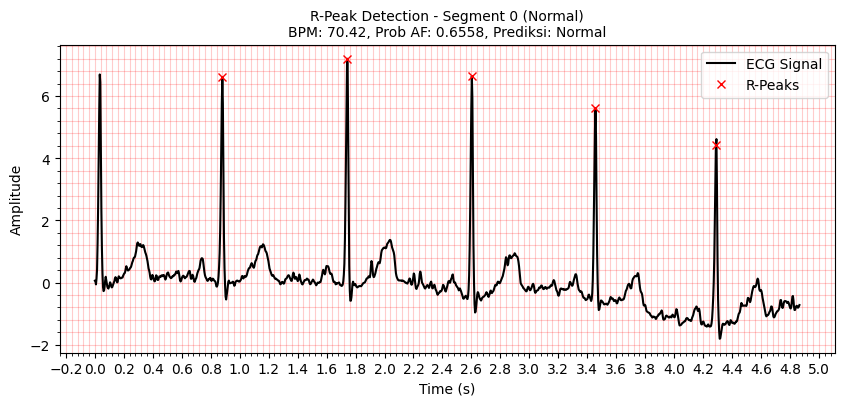

In [12]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import neurokit2 as nk
from scipy.signal import butter, filtfilt, detrend, iirnotch, resample, welch
from scipy.stats import entropy
import pywt

# Required functions (unchanged except for debugging options)
def bandpass_filter(signal, lowcut=0.5, highcut=40.0, fs=267, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def notch_filter(signal, freq=50.0, fs=267, quality=30.0):
    b, a = iirnotch(freq, quality, fs)
    return filtfilt(b, a, signal)

def wavelet_denoise(signal, wavelet='db6', level=5):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    threshold = np.std(coeffs[-1]) * np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)

def compute_rr_features(signal, fs=267, use_entropy=True, visualize=False, segment_idx=0, label='unknown'):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    try:
        signal_detrended = detrend(signal[:, 0])
        signal_denoised = wavelet_denoise(signal_detrended)
        signal_notched = notch_filter(signal_denoised, freq=50.0, fs=fs)
        signal_filtered = bandpass_filter(signal_notched, lowcut=0.5, highcut=40.0, fs=fs)
        signal_norm = (signal_filtered - np.mean(signal_filtered)) / (np.std(signal_filtered) + 1e-8)
        cleaned = nk.ecg_clean(signal_norm, sampling_rate=fs, method='neurokit')
        rpeaks_info = nk.ecg_findpeaks(cleaned, sampling_rate=fs)
        r_peaks = np.array(rpeaks_info['ECG_R_Peaks'])
        if len(r_peaks) < 2:
            print(f"Peringatan: Hanya {len(r_peaks)} puncak R terdeteksi pada segmen {segment_idx}.")
            return None, None, None
        rr_intervals = np.diff(r_peaks) / fs * 1000
        cv_rr = np.std(rr_intervals) / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        qrs_amplitude = np.max(signal_norm) - np.min(signal_norm)
        bpm = 60000 / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        if use_entropy:
            hist, _ = np.histogram(signal_norm, bins=50, density=True)
            signal_entropy = entropy(hist)
            signal_entropy = (signal_entropy - np.mean(hist)) / (np.std(hist) + 1e-8)
        else:
            freqs, psd = welch(signal_norm, fs=fs, nperseg=256)
            signal_entropy = np.sum(psd)
        if visualize:
            visualize_r_peaks(cleaned, r_peaks, label, fs, segment_idx)
        return rr_intervals, [cv_rr, qrs_amplitude, signal_entropy, bpm], r_peaks
    except Exception as e:
        print(f"Error deteksi puncak R: {e}")
        return None, None, None

def visualize_r_peaks(signal, r_peaks, label, fs=267, segment_idx=0, bpm=None, prob=None):
    if r_peaks is None or len(r_peaks) == 0:
        print("Tidak ada R-peaks untuk divisualisasikan.")
        return
    plt.figure(figsize=(10, 4))
    t = np.arange(len(signal)) / fs
    plt.plot(t, signal, label='ECG Signal', color='black')
    plt.plot(t[r_peaks], signal[r_peaks], 'rx', label='R-Peaks')
    title_str = f'R-Peak Detection - Segment {segment_idx} ({label})'
    if bpm is not None and prob is not None:
        title_str += f'\nBPM: {bpm:.2f}, Prob AF: {prob:.4f}, Prediksi: {label}'
    plt.title(title_str, fontsize=10)
    plt.grid(True, which='both', linestyle='-', alpha=0.2, color='red')
    plt.minorticks_on()
    plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.04))
    plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    plt.gca().yaxis.set_major_locator(ticker.AutoLocator())
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.savefig(f'r_peaks_segment_{segment_idx}_{label}.png', dpi=300)
    plt.show()

def augment_signal(signal, noise_factor=0.1):
    noise = np.random.normal(0, noise_factor, signal.shape)
    scaled_signal = signal * np.random.uniform(0.8, 1.2)
    shifted_signal = scaled_signal + np.random.uniform(-0.2, 0.2)
    return shifted_signal + noise

def normalize_signal(signal):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    signal_norm = (signal - np.mean(signal, axis=0)) / (np.std(signal, axis=0) + 1e-8)
    return signal_norm

def load_and_process_csv(csv_file, segment_length=1300, fs=267, disable_augmentation=False):
    df = pd.read_csv(csv_file)
    signal = df['ECG'].values
    original_fs = 250  # Based on 0.004s interval
    if original_fs != fs:
        target_samples = int(len(signal) * (fs / original_fs))
        signal = resample(signal, target_samples)
    if len(signal) < segment_length:
        print(f"Panjang sinyal ({len(signal)}) kurang dari {segment_length}. Tidak dapat memroses.")
        return None, None, None
    segments, rr_features_list, r_peaks_list = [], [], []
    step = int(segment_length * 0.5)
    for i in range(0, len(signal) - segment_length, step):
        segment = signal[i:i + segment_length]
        if len(segment) != segment_length:
            continue
        segment_norm = normalize_signal(segment)
        segment_augmented = segment_norm if disable_augmentation else augment_signal(segment_norm)
        rr_intervals, features, r_peaks = compute_rr_features(segment, fs=fs)
        if rr_intervals is None or features is None:
            continue
        segments.append(segment_augmented)
        rr_features_list.append(features)
        r_peaks_list.append(r_peaks)
    if not segments:
        print("Tidak ada segmen yang valid setelah pemrosesan.")
        return None, None, None
    segments = np.array(segments)
    rr_features_list = np.array(rr_features_list)
    segments = segments.reshape(segments.shape[0], segment_length, 1)
    return segments, rr_features_list, r_peaks_list

def select_best_model(fold_scores, base_path='best_model_lstm_layer_fold_2.h5'):
    if not fold_scores:
        print("Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 2.")
        best_fold = 1
    else:
        best_fold = np.argmax(fold_scores) + 1
    model_path = base_path.format(best_fold)
    if os.path.exists(model_path):
        print(f"Memuat model terbaik dari fold {best_fold} di {model_path}")
        model = load_model(model_path)
        return model, best_fold
    else:
        print(f"Model untuk fold {best_fold} tidak ditemukan di {model_path}")
        return None, None

def predict_with_model(model, scaler, X_test, rr_features_test, threshold=0.5):
    rr_features_norm = scaler.transform(rr_features_test)
    predictions = model.predict([X_test, rr_features_norm], verbose=0)
    predictions_binary = (predictions > threshold).astype(int).flatten()
    return predictions, predictions_binary

# Main execution
csv_file = r'D:\Tugas Akhir\Pemodelan\CNN_LSTM\Recording Perbandingan\8_Pria_22th_Rayhan\8_Pria_22th.csv'  # Ganti dengan path file CSV kamu
segment_length = 1300
fs = 267

# 1. Muat dan proses data CSV with debugging option
X_test, rr_features_test, r_peaks_test = load_and_process_csv(csv_file, segment_length, fs, disable_augmentation=True)
if X_test is None:
    print("Gagal memroses data CSV. Program dihentikan.")
    exit()

print(f"Data CSV diproses: {X_test.shape[0]} segmen")
print(f"RR Features for Segment 0: {rr_features_test[0]}")  # Debug RR features

# 2. Muat scaler dan data yang disimpan
data_dict = joblib.load('processed_data.pkl')
scaler = data_dict['scaler']
print("Scaler dimuat dari 'processed_data.pkl'")

# 3. Pilih model terbaik berdasarkan fold_scores
fold_scores = []  # Ganti dengan daftar fold_scores dari K-Fold CV
# Contoh: fold_scores = [0.95, 0.92, 0.96, 0.93, 0.94]
model, best_fold = select_best_model(fold_scores)
if model is None:
    print("Gagal memuat model terbaik. Program dihentikan.")
    exit()

# 4. Lakukan prediksi with adjustable threshold
predictions, predictions_binary = predict_with_model(model, scaler, X_test, rr_features_test, threshold=0.7)

# 5. Tampilkan hasil prediksi
print(f"\nHasil Prediksi untuk {X_test.shape[0]} Segmen:")
for i, (prob, label) in enumerate(zip(predictions.flatten(), predictions_binary)):
    label_str = 'AF' if label == 1 else 'Normal'
    print(f"Segmen {i+1}: Probabilitas AF = {prob:.4f}, Prediksi = {label_str}")

# 6. Visualisasi sinyal dan R-peaks untuk segmen pertama
if X_test.shape[0] > 0:
    label = 'AF' if predictions_binary[0] == 1 else 'Normal'
    bpm = rr_features_test[0][3]
    prob = predictions[0][0]
    visualize_r_peaks(X_test[0].flatten(), r_peaks_test[0], label, fs=fs, segment_idx=0, bpm=bpm, prob=prob)

Data CSV diproses: 26 segmen
RR Features for Segment 0: [3.63518824e-02 7.70569017e+00 8.84312287e+00 7.24067797e+01]
Scaler dimuat dari 'processed_data.pkl'
Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 2.
Memuat model terbaik dari fold 1 di best_model_lstm_layer_fold_2.h5

Hasil Prediksi untuk 26 Segmen:
Segmen 1: Probabilitas AF = 0.6701, Prediksi = Normal
Segmen 2: Probabilitas AF = 0.5557, Prediksi = Normal
Segmen 3: Probabilitas AF = 0.5631, Prediksi = Normal
Segmen 4: Probabilitas AF = 0.6712, Prediksi = Normal
Segmen 5: Probabilitas AF = 0.6743, Prediksi = Normal
Segmen 6: Probabilitas AF = 0.5876, Prediksi = Normal
Segmen 7: Probabilitas AF = 0.6221, Prediksi = Normal
Segmen 8: Probabilitas AF = 0.6500, Prediksi = Normal
Segmen 9: Probabilitas AF = 0.4486, Prediksi = Normal
Segmen 10: Probabilitas AF = 0.5794, Prediksi = Normal
Segmen 11: Probabilitas AF = 0.4742, Prediksi = Normal
Segmen 12: Probabilitas AF = 0.6007, Prediksi = Normal
Segmen 13: Probabilitas 

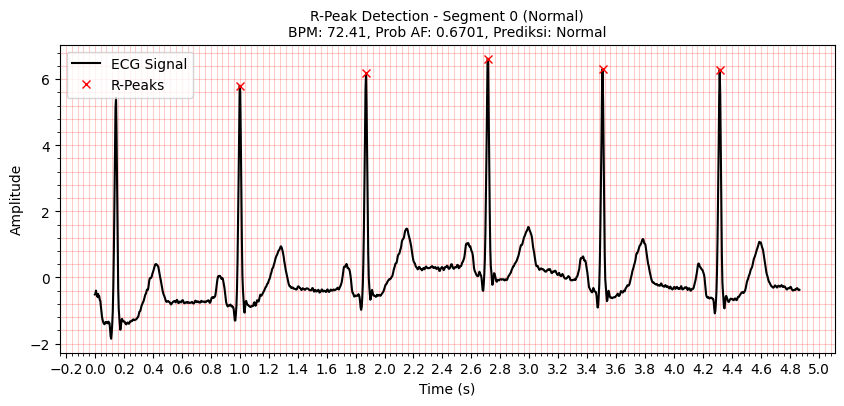

In [13]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import neurokit2 as nk
from scipy.signal import butter, filtfilt, detrend, iirnotch, resample, welch
from scipy.stats import entropy
import pywt

# Required functions (unchanged except for debugging options)
def bandpass_filter(signal, lowcut=0.5, highcut=40.0, fs=267, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def notch_filter(signal, freq=50.0, fs=267, quality=30.0):
    b, a = iirnotch(freq, quality, fs)
    return filtfilt(b, a, signal)

def wavelet_denoise(signal, wavelet='db6', level=5):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    threshold = np.std(coeffs[-1]) * np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)

def compute_rr_features(signal, fs=267, use_entropy=True, visualize=False, segment_idx=0, label='unknown'):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    try:
        signal_detrended = detrend(signal[:, 0])
        signal_denoised = wavelet_denoise(signal_detrended)
        signal_notched = notch_filter(signal_denoised, freq=50.0, fs=fs)
        signal_filtered = bandpass_filter(signal_notched, lowcut=0.5, highcut=40.0, fs=fs)
        signal_norm = (signal_filtered - np.mean(signal_filtered)) / (np.std(signal_filtered) + 1e-8)
        cleaned = nk.ecg_clean(signal_norm, sampling_rate=fs, method='neurokit')
        rpeaks_info = nk.ecg_findpeaks(cleaned, sampling_rate=fs)
        r_peaks = np.array(rpeaks_info['ECG_R_Peaks'])
        if len(r_peaks) < 2:
            print(f"Peringatan: Hanya {len(r_peaks)} puncak R terdeteksi pada segmen {segment_idx}.")
            return None, None, None
        rr_intervals = np.diff(r_peaks) / fs * 1000
        cv_rr = np.std(rr_intervals) / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        qrs_amplitude = np.max(signal_norm) - np.min(signal_norm)
        bpm = 60000 / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        if use_entropy:
            hist, _ = np.histogram(signal_norm, bins=50, density=True)
            signal_entropy = entropy(hist)
            signal_entropy = (signal_entropy - np.mean(hist)) / (np.std(hist) + 1e-8)
        else:
            freqs, psd = welch(signal_norm, fs=fs, nperseg=256)
            signal_entropy = np.sum(psd)
        if visualize:
            visualize_r_peaks(cleaned, r_peaks, label, fs, segment_idx)
        return rr_intervals, [cv_rr, qrs_amplitude, signal_entropy, bpm], r_peaks
    except Exception as e:
        print(f"Error deteksi puncak R: {e}")
        return None, None, None

def visualize_r_peaks(signal, r_peaks, label, fs=267, segment_idx=0, bpm=None, prob=None):
    if r_peaks is None or len(r_peaks) == 0:
        print("Tidak ada R-peaks untuk divisualisasikan.")
        return
    plt.figure(figsize=(10, 4))
    t = np.arange(len(signal)) / fs
    plt.plot(t, signal, label='ECG Signal', color='black')
    plt.plot(t[r_peaks], signal[r_peaks], 'rx', label='R-Peaks')
    title_str = f'R-Peak Detection - Segment {segment_idx} ({label})'
    if bpm is not None and prob is not None:
        title_str += f'\nBPM: {bpm:.2f}, Prob AF: {prob:.4f}, Prediksi: {label}'
    plt.title(title_str, fontsize=10)
    plt.grid(True, which='both', linestyle='-', alpha=0.2, color='red')
    plt.minorticks_on()
    plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.04))
    plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    plt.gca().yaxis.set_major_locator(ticker.AutoLocator())
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.savefig(f'r_peaks_segment_{segment_idx}_{label}.png', dpi=300)
    plt.show()

def augment_signal(signal, noise_factor=0.1):
    noise = np.random.normal(0, noise_factor, signal.shape)
    scaled_signal = signal * np.random.uniform(0.8, 1.2)
    shifted_signal = scaled_signal + np.random.uniform(-0.2, 0.2)
    return shifted_signal + noise

def normalize_signal(signal):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    signal_norm = (signal - np.mean(signal, axis=0)) / (np.std(signal, axis=0) + 1e-8)
    return signal_norm

def load_and_process_csv(csv_file, segment_length=1300, fs=267, disable_augmentation=False):
    df = pd.read_csv(csv_file)
    signal = df['ECG'].values
    original_fs = 250  # Based on 0.004s interval
    if original_fs != fs:
        target_samples = int(len(signal) * (fs / original_fs))
        signal = resample(signal, target_samples)
    if len(signal) < segment_length:
        print(f"Panjang sinyal ({len(signal)}) kurang dari {segment_length}. Tidak dapat memroses.")
        return None, None, None
    segments, rr_features_list, r_peaks_list = [], [], []
    step = int(segment_length * 0.5)
    for i in range(0, len(signal) - segment_length, step):
        segment = signal[i:i + segment_length]
        if len(segment) != segment_length:
            continue
        segment_norm = normalize_signal(segment)
        segment_augmented = segment_norm if disable_augmentation else augment_signal(segment_norm)
        rr_intervals, features, r_peaks = compute_rr_features(segment, fs=fs)
        if rr_intervals is None or features is None:
            continue
        segments.append(segment_augmented)
        rr_features_list.append(features)
        r_peaks_list.append(r_peaks)
    if not segments:
        print("Tidak ada segmen yang valid setelah pemrosesan.")
        return None, None, None
    segments = np.array(segments)
    rr_features_list = np.array(rr_features_list)
    segments = segments.reshape(segments.shape[0], segment_length, 1)
    return segments, rr_features_list, r_peaks_list

def select_best_model(fold_scores, base_path='best_model_lstm_layer_fold_2.h5'):
    if not fold_scores:
        print("Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 2.")
        best_fold = 1
    else:
        best_fold = np.argmax(fold_scores) + 1
    model_path = base_path.format(best_fold)
    if os.path.exists(model_path):
        print(f"Memuat model terbaik dari fold {best_fold} di {model_path}")
        model = load_model(model_path)
        return model, best_fold
    else:
        print(f"Model untuk fold {best_fold} tidak ditemukan di {model_path}")
        return None, None

def predict_with_model(model, scaler, X_test, rr_features_test, threshold=0.5):
    rr_features_norm = scaler.transform(rr_features_test)
    predictions = model.predict([X_test, rr_features_norm], verbose=0)
    predictions_binary = (predictions > threshold).astype(int).flatten()
    return predictions, predictions_binary

# Main execution
csv_file = r'D:\Tugas Akhir\Pemodelan\CNN_LSTM\Recording Perbandingan\9_Wanita_22th_Malsa\9_Wanita_22th.csv'  # Ganti dengan path file CSV kamu
segment_length = 1300
fs = 267

# 1. Muat dan proses data CSV with debugging option
X_test, rr_features_test, r_peaks_test = load_and_process_csv(csv_file, segment_length, fs, disable_augmentation=True)
if X_test is None:
    print("Gagal memroses data CSV. Program dihentikan.")
    exit()

print(f"Data CSV diproses: {X_test.shape[0]} segmen")
print(f"RR Features for Segment 0: {rr_features_test[0]}")  # Debug RR features

# 2. Muat scaler dan data yang disimpan
data_dict = joblib.load('processed_data.pkl')
scaler = data_dict['scaler']
print("Scaler dimuat dari 'processed_data.pkl'")

# 3. Pilih model terbaik berdasarkan fold_scores
fold_scores = []  # Ganti dengan daftar fold_scores dari K-Fold CV
# Contoh: fold_scores = [0.95, 0.92, 0.96, 0.93, 0.94]
model, best_fold = select_best_model(fold_scores)
if model is None:
    print("Gagal memuat model terbaik. Program dihentikan.")
    exit()

# 4. Lakukan prediksi with adjustable threshold
predictions, predictions_binary = predict_with_model(model, scaler, X_test, rr_features_test, threshold=0.7)

# 5. Tampilkan hasil prediksi
print(f"\nHasil Prediksi untuk {X_test.shape[0]} Segmen:")
for i, (prob, label) in enumerate(zip(predictions.flatten(), predictions_binary)):
    label_str = 'AF' if label == 1 else 'Normal'
    print(f"Segmen {i+1}: Probabilitas AF = {prob:.4f}, Prediksi = {label_str}")

# 6. Visualisasi sinyal dan R-peaks untuk segmen pertama
if X_test.shape[0] > 0:
    label = 'AF' if predictions_binary[0] == 1 else 'Normal'
    bpm = rr_features_test[0][3]
    prob = predictions[0][0]
    visualize_r_peaks(X_test[0].flatten(), r_peaks_test[0], label, fs=fs, segment_idx=0, bpm=bpm, prob=prob)

Data CSV diproses: 26 segmen
RR Features for Segment 0: [1.22574055e-02 7.45483842e+00 7.89828455e+00 8.18181818e+01]
Scaler dimuat dari 'processed_data.pkl'
Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 2.
Memuat model terbaik dari fold 1 di best_model_lstm_layer_fold_2.h5

Hasil Prediksi untuk 26 Segmen:
Segmen 1: Probabilitas AF = 0.7030, Prediksi = AF
Segmen 2: Probabilitas AF = 0.8074, Prediksi = AF
Segmen 3: Probabilitas AF = 0.7554, Prediksi = AF
Segmen 4: Probabilitas AF = 0.8044, Prediksi = AF
Segmen 5: Probabilitas AF = 0.8088, Prediksi = AF
Segmen 6: Probabilitas AF = 0.7888, Prediksi = AF
Segmen 7: Probabilitas AF = 0.8231, Prediksi = AF
Segmen 8: Probabilitas AF = 0.6624, Prediksi = Normal
Segmen 9: Probabilitas AF = 0.8267, Prediksi = AF
Segmen 10: Probabilitas AF = 0.7900, Prediksi = AF
Segmen 11: Probabilitas AF = 0.8149, Prediksi = AF
Segmen 12: Probabilitas AF = 0.7581, Prediksi = AF
Segmen 13: Probabilitas AF = 0.8066, Prediksi = AF
Segmen 14: Probab

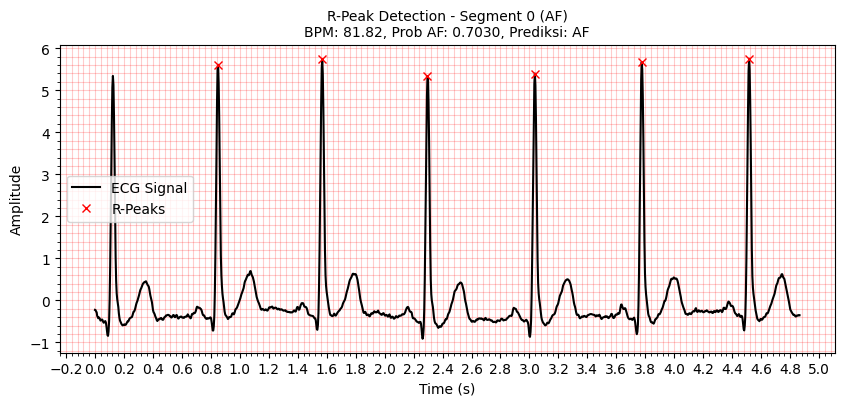

In [14]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import neurokit2 as nk
from scipy.signal import butter, filtfilt, detrend, iirnotch, resample, welch
from scipy.stats import entropy
import pywt

# Required functions (unchanged except for debugging options)
def bandpass_filter(signal, lowcut=0.5, highcut=40.0, fs=267, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def notch_filter(signal, freq=50.0, fs=267, quality=30.0):
    b, a = iirnotch(freq, quality, fs)
    return filtfilt(b, a, signal)

def wavelet_denoise(signal, wavelet='db6', level=5):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    threshold = np.std(coeffs[-1]) * np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)

def compute_rr_features(signal, fs=267, use_entropy=True, visualize=False, segment_idx=0, label='unknown'):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    try:
        signal_detrended = detrend(signal[:, 0])
        signal_denoised = wavelet_denoise(signal_detrended)
        signal_notched = notch_filter(signal_denoised, freq=50.0, fs=fs)
        signal_filtered = bandpass_filter(signal_notched, lowcut=0.5, highcut=40.0, fs=fs)
        signal_norm = (signal_filtered - np.mean(signal_filtered)) / (np.std(signal_filtered) + 1e-8)
        cleaned = nk.ecg_clean(signal_norm, sampling_rate=fs, method='neurokit')
        rpeaks_info = nk.ecg_findpeaks(cleaned, sampling_rate=fs)
        r_peaks = np.array(rpeaks_info['ECG_R_Peaks'])
        if len(r_peaks) < 2:
            print(f"Peringatan: Hanya {len(r_peaks)} puncak R terdeteksi pada segmen {segment_idx}.")
            return None, None, None
        rr_intervals = np.diff(r_peaks) / fs * 1000
        cv_rr = np.std(rr_intervals) / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        qrs_amplitude = np.max(signal_norm) - np.min(signal_norm)
        bpm = 60000 / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        if use_entropy:
            hist, _ = np.histogram(signal_norm, bins=50, density=True)
            signal_entropy = entropy(hist)
            signal_entropy = (signal_entropy - np.mean(hist)) / (np.std(hist) + 1e-8)
        else:
            freqs, psd = welch(signal_norm, fs=fs, nperseg=256)
            signal_entropy = np.sum(psd)
        if visualize:
            visualize_r_peaks(cleaned, r_peaks, label, fs, segment_idx)
        return rr_intervals, [cv_rr, qrs_amplitude, signal_entropy, bpm], r_peaks
    except Exception as e:
        print(f"Error deteksi puncak R: {e}")
        return None, None, None

def visualize_r_peaks(signal, r_peaks, label, fs=267, segment_idx=0, bpm=None, prob=None):
    if r_peaks is None or len(r_peaks) == 0:
        print("Tidak ada R-peaks untuk divisualisasikan.")
        return
    plt.figure(figsize=(10, 4))
    t = np.arange(len(signal)) / fs
    plt.plot(t, signal, label='ECG Signal', color='black')
    plt.plot(t[r_peaks], signal[r_peaks], 'rx', label='R-Peaks')
    title_str = f'R-Peak Detection - Segment {segment_idx} ({label})'
    if bpm is not None and prob is not None:
        title_str += f'\nBPM: {bpm:.2f}, Prob AF: {prob:.4f}, Prediksi: {label}'
    plt.title(title_str, fontsize=10)
    plt.grid(True, which='both', linestyle='-', alpha=0.2, color='red')
    plt.minorticks_on()
    plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.04))
    plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    plt.gca().yaxis.set_major_locator(ticker.AutoLocator())
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.savefig(f'r_peaks_segment_{segment_idx}_{label}.png', dpi=300)
    plt.show()

def augment_signal(signal, noise_factor=0.1):
    noise = np.random.normal(0, noise_factor, signal.shape)
    scaled_signal = signal * np.random.uniform(0.8, 1.2)
    shifted_signal = scaled_signal + np.random.uniform(-0.2, 0.2)
    return shifted_signal + noise

def normalize_signal(signal):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    signal_norm = (signal - np.mean(signal, axis=0)) / (np.std(signal, axis=0) + 1e-8)
    return signal_norm

def load_and_process_csv(csv_file, segment_length=1300, fs=267, disable_augmentation=False):
    df = pd.read_csv(csv_file)
    signal = df['ECG'].values
    original_fs = 250  # Based on 0.004s interval
    if original_fs != fs:
        target_samples = int(len(signal) * (fs / original_fs))
        signal = resample(signal, target_samples)
    if len(signal) < segment_length:
        print(f"Panjang sinyal ({len(signal)}) kurang dari {segment_length}. Tidak dapat memroses.")
        return None, None, None
    segments, rr_features_list, r_peaks_list = [], [], []
    step = int(segment_length * 0.5)
    for i in range(0, len(signal) - segment_length, step):
        segment = signal[i:i + segment_length]
        if len(segment) != segment_length:
            continue
        segment_norm = normalize_signal(segment)
        segment_augmented = segment_norm if disable_augmentation else augment_signal(segment_norm)
        rr_intervals, features, r_peaks = compute_rr_features(segment, fs=fs)
        if rr_intervals is None or features is None:
            continue
        segments.append(segment_augmented)
        rr_features_list.append(features)
        r_peaks_list.append(r_peaks)
    if not segments:
        print("Tidak ada segmen yang valid setelah pemrosesan.")
        return None, None, None
    segments = np.array(segments)
    rr_features_list = np.array(rr_features_list)
    segments = segments.reshape(segments.shape[0], segment_length, 1)
    return segments, rr_features_list, r_peaks_list

def select_best_model(fold_scores, base_path='best_model_lstm_layer_fold_2.h5'):
    if not fold_scores:
        print("Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 2.")
        best_fold = 1
    else:
        best_fold = np.argmax(fold_scores) + 1
    model_path = base_path.format(best_fold)
    if os.path.exists(model_path):
        print(f"Memuat model terbaik dari fold {best_fold} di {model_path}")
        model = load_model(model_path)
        return model, best_fold
    else:
        print(f"Model untuk fold {best_fold} tidak ditemukan di {model_path}")
        return None, None

def predict_with_model(model, scaler, X_test, rr_features_test, threshold=0.5):
    rr_features_norm = scaler.transform(rr_features_test)
    predictions = model.predict([X_test, rr_features_norm], verbose=0)
    predictions_binary = (predictions > threshold).astype(int).flatten()
    return predictions, predictions_binary

# Main execution
csv_file = r'D:\Tugas Akhir\Pemodelan\CNN_LSTM\Recording Perbandingan\10_Pria_22th_Alif\10_Pria_22th.csv'  # Ganti dengan path file CSV kamu
segment_length = 1300
fs = 267

# 1. Muat dan proses data CSV with debugging option
X_test, rr_features_test, r_peaks_test = load_and_process_csv(csv_file, segment_length, fs, disable_augmentation=True)
if X_test is None:
    print("Gagal memroses data CSV. Program dihentikan.")
    exit()

print(f"Data CSV diproses: {X_test.shape[0]} segmen")
print(f"RR Features for Segment 0: {rr_features_test[0]}")  # Debug RR features

# 2. Muat scaler dan data yang disimpan
data_dict = joblib.load('processed_data.pkl')
scaler = data_dict['scaler']
print("Scaler dimuat dari 'processed_data.pkl'")

# 3. Pilih model terbaik berdasarkan fold_scores
fold_scores = []  # Ganti dengan daftar fold_scores dari K-Fold CV
# Contoh: fold_scores = [0.95, 0.92, 0.96, 0.93, 0.94]
model, best_fold = select_best_model(fold_scores)
if model is None:
    print("Gagal memuat model terbaik. Program dihentikan.")
    exit()

# 4. Lakukan prediksi with adjustable threshold
predictions, predictions_binary = predict_with_model(model, scaler, X_test, rr_features_test, threshold=0.7)

# 5. Tampilkan hasil prediksi
print(f"\nHasil Prediksi untuk {X_test.shape[0]} Segmen:")
for i, (prob, label) in enumerate(zip(predictions.flatten(), predictions_binary)):
    label_str = 'AF' if label == 1 else 'Normal'
    print(f"Segmen {i+1}: Probabilitas AF = {prob:.4f}, Prediksi = {label_str}")

# 6. Visualisasi sinyal dan R-peaks untuk segmen pertama
if X_test.shape[0] > 0:
    label = 'AF' if predictions_binary[0] == 1 else 'Normal'
    bpm = rr_features_test[0][3]
    prob = predictions[0][0]
    visualize_r_peaks(X_test[0].flatten(), r_peaks_test[0], label, fs=fs, segment_idx=0, bpm=bpm, prob=prob)

Data CSV diproses: 1721 segmen
RR Features for Segment 0: [2.21457103e-02 7.68747974e+00 1.39136679e+01 1.44715447e+02]
Scaler dimuat dari 'processed_data.pkl'
Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 2.
Memuat model terbaik dari fold 1 di best_model_lstm_layer_fold_2.h5



Hasil Prediksi untuk 1721 Segmen:
Segmen 1: Probabilitas AF = 0.3009, Prediksi = Normal
Segmen 2: Probabilitas AF = 0.3087, Prediksi = Normal
Segmen 3: Probabilitas AF = 0.2826, Prediksi = Normal
Segmen 4: Probabilitas AF = 0.3821, Prediksi = Normal
Segmen 5: Probabilitas AF = 0.4053, Prediksi = Normal
Segmen 6: Probabilitas AF = 0.4837, Prediksi = Normal
Segmen 7: Probabilitas AF = 0.4692, Prediksi = Normal
Segmen 8: Probabilitas AF = 0.4585, Prediksi = Normal
Segmen 9: Probabilitas AF = 0.3344, Prediksi = Normal
Segmen 10: Probabilitas AF = 0.3366, Prediksi = Normal
Segmen 11: Probabilitas AF = 0.2987, Prediksi = Normal
Segmen 12: Probabilitas AF = 0.3670, Prediksi = Normal
Segmen 13: Probabilitas AF = 0.3318, Prediksi = Normal
Segmen 14: Probabilitas AF = 0.4302, Prediksi = Normal
Segmen 15: Probabilitas AF = 0.3934, Prediksi = Normal
Segmen 16: Probabilitas AF = 0.3775, Prediksi = Normal
Segmen 17: Probabilitas AF = 0.3972, Prediksi = Normal
Segmen 18: Probabilitas AF = 0.4307, Pr

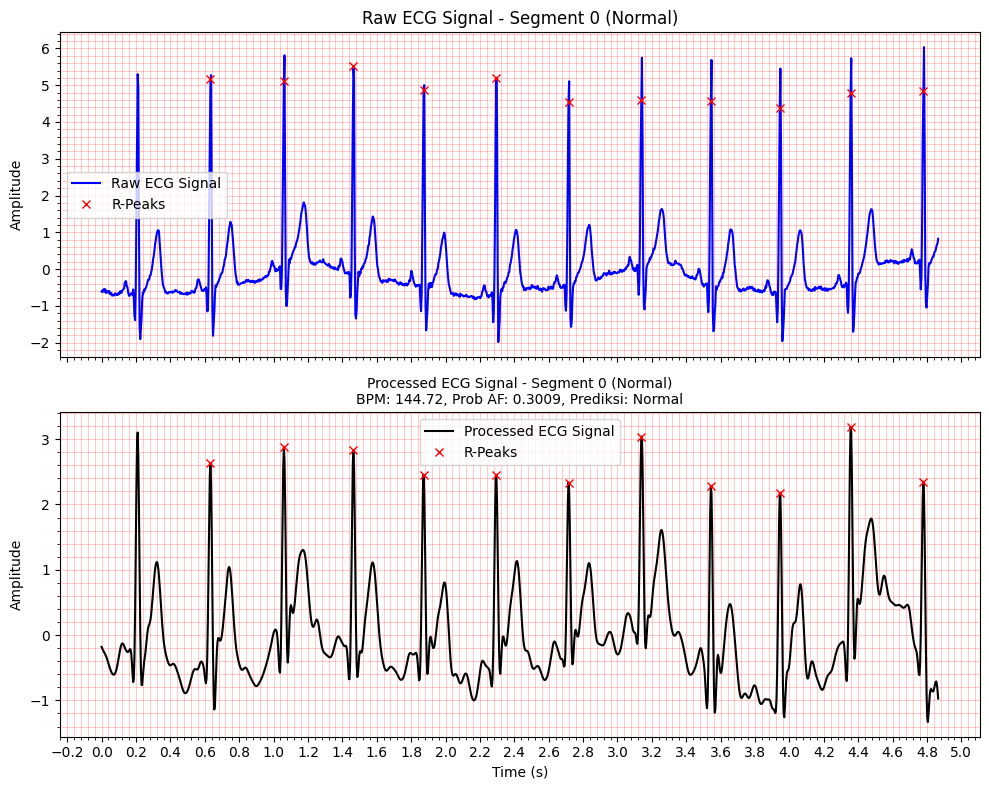

In [ ]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import neurokit2 as nk
from scipy.signal import butter, filtfilt, detrend, iirnotch, resample, welch
from scipy.stats import entropy
import pywt

# Required functions (unchanged except for debugging options)
def bandpass_filter(signal, lowcut=0.5, highcut=40.0, fs=267, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def notch_filter(signal, freq=50.0, fs=267, quality=30.0):
    b, a = iirnotch(freq, quality, fs)
    return filtfilt(b, a, signal)

def wavelet_denoise(signal, wavelet='db6', level=5):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    threshold = np.std(coeffs[-1]) * np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)

def compute_rr_features(signal, fs=267, use_entropy=True, visualize=False, segment_idx=0, label='unknown'):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    try:
        # Simpan sinyal asli untuk visualisasi
        signal_raw = signal[:, 0].copy()
        signal_detrended = detrend(signal[:, 0])
        signal_denoised = wavelet_denoise(signal_detrended)
        signal_notched = notch_filter(signal_denoised, freq=50.0, fs=fs)
        signal_filtered = bandpass_filter(signal_notched, lowcut=0.5, highcut=40.0, fs=fs)
        signal_norm = (signal_filtered - np.mean(signal_filtered)) / (np.std(signal_filtered) + 1e-8)
        cleaned = nk.ecg_clean(signal_norm, sampling_rate=fs, method='neurokit')
        rpeaks_info = nk.ecg_findpeaks(cleaned, sampling_rate=fs)
        r_peaks = np.array(rpeaks_info['ECG_R_Peaks'])
        if len(r_peaks) < 2:
            print(f"Peringatan: Hanya {len(r_peaks)} puncak R terdeteksi pada segmen {segment_idx}.")
            return None, None, None, None
        rr_intervals = np.diff(r_peaks) / fs * 1000
        cv_rr = np.std(rr_intervals) / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        qrs_amplitude = np.max(signal_norm) - np.min(signal_norm)
        bpm = 60000 / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        if use_entropy:
            hist, _ = np.histogram(signal_norm, bins=50, density=True)
            signal_entropy = entropy(hist)
            signal_entropy = (signal_entropy - np.mean(hist)) / (np.std(hist) + 1e-8)
        else:
            freqs, psd = welch(signal_norm, fs=fs, nperseg=256)
            signal_entropy = np.sum(psd)
        if visualize:
            visualize_r_peaks(signal_raw, cleaned, r_peaks, label, fs, segment_idx)
        return rr_intervals, [cv_rr, qrs_amplitude, signal_entropy, bpm], r_peaks, cleaned
    except Exception as e:
        print(f"Error deteksi puncak R: {e}")
        return None, None, None, None

def visualize_r_peaks(signal_raw, signal_processed, r_peaks, label, fs=267, segment_idx=0, bpm=None, prob=None):
    if r_peaks is None or len(r_peaks) == 0:
        print("Tidak ada R-peaks untuk divisualisasikan.")
        return
    # Membuat subplot untuk sinyal sebelum dan sesudah preprocessing
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    t = np.arange(len(signal_raw)) / fs
    
    # Plot sinyal sebelum preprocessing
    ax1.plot(t, signal_raw, label='processed ECG Signal', color='blue')
    ax1.plot(t[r_peaks], signal_raw[r_peaks], 'rx', label='R-Peaks')
    ax1.set_title(f'Raw ECG Signal - Segment {segment_idx} ({label})')
    ax1.grid(True, which='both', linestyle='-', alpha=0.2, color='red')
    ax1.minorticks_on()
    ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.04))
    ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax1.yaxis.set_major_locator(ticker.AutoLocator())
    ax1.set_ylabel('Amplitude')
    ax1.legend()

    # Plot sinyal sesudah preprocessing
    ax2.plot(t, signal_processed, label='Processed ECG Signal', color='black')
    ax2.plot(t[r_peaks], signal_processed[r_peaks], 'rx', label='R-Peaks')
    title_str = f'Processed ECG Signal - Segment {segment_idx} ({label})'
    if bpm is not None and prob is not None:
        title_str += f'\nBPM: {bpm:.2f}, Prob AF: {prob:.4f}, Prediksi: {label}'
    ax2.set_title(title_str, fontsize=10)
    ax2.grid(True, which='both', linestyle='-', alpha=0.2, color='red')
    ax2.minorticks_on()
    ax2.xaxis.set_minor_locator(ticker.MultipleLocator(0.04))
    ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax2.yaxis.set_major_locator(ticker.AutoLocator())
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Amplitude')
    ax2.legend()

    plt.tight_layout()
    plt.savefig(f'ecg_segment_{segment_idx}_{label}.png', dpi=300)
    plt.show()

def augment_signal(signal, noise_factor=0.1):
    noise = np.random.normal(0, noise_factor, signal.shape)
    scaled_signal = signal * np.random.uniform(0.8, 1.2)
    shifted_signal = scaled_signal + np.random.uniform(-0.2, 0.2)
    return shifted_signal + noise

def normalize_signal(signal):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    signal_norm = (signal - np.mean(signal, axis=0)) / (np.std(signal, axis=0) + 1e-8)
    return signal_norm

def load_and_process_csv(csv_file, segment_length=1300, fs=267, disable_augmentation=False):
    df = pd.read_csv(csv_file)
    signal = df['ECG'].values
    original_fs = 250  # Based on 0.004s interval
    if original_fs != fs:
        target_samples = int(len(signal) * (fs / original_fs))
        signal = resample(signal, target_samples)
    if len(signal) < segment_length:
        print(f"Panjang sinyal ({len(signal)}) kurang dari {segment_length}. Tidak dapat memroses.")
        return None, None, None, None
    segments, rr_features_list, r_peaks_list, cleaned_signals = [], [], [], []
    step = int(segment_length * 0.5)
    for i in range(0, len(signal) - segment_length, step):
        segment = signal[i:i + segment_length]
        if len(segment) != segment_length:
            continue
        segment_norm = normalize_signal(segment)
        segment_augmented = segment_norm if disable_augmentation else augment_signal(segment_norm)
        rr_intervals, features, r_peaks, cleaned_signal = compute_rr_features(segment, fs=fs, visualize=False)
        if rr_intervals is None or features is None:
            continue
        segments.append(segment_augmented)
        rr_features_list.append(features)
        r_peaks_list.append(r_peaks)
        cleaned_signals.append(cleaned_signal)
    if not segments:
        print("Tidak ada segmen yang valid setelah pemrosesan.")
        return None, None, None, None
    segments = np.array(segments)
    rr_features_list = np.array(rr_features_list)
    segments = segments.reshape(segments.shape[0], segment_length, 1)
    return segments, rr_features_list, r_peaks_list, cleaned_signals

def select_best_model(fold_scores, base_path='best_model_lstm_layer_fold_2.h5'):
    if not fold_scores:
        print("Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 2.")
        best_fold = 1
    else:
        best_fold = np.argmax(fold_scores) + 1
    model_path = base_path.format(best_fold)
    if os.path.exists(model_path):
        print(f"Memuat model terbaik dari fold {best_fold} di {model_path}")
        model = load_model(model_path)
        return model, best_fold
    else:
        print(f"Model untuk fold {best_fold} tidak ditemukan di {model_path}")
        return None, None

def predict_with_model(model, scaler, X_test, rr_features_test, threshold=0.5):
    rr_features_norm = scaler.transform(rr_features_test)
    predictions = model.predict([X_test, rr_features_norm], verbose=0)
    predictions_binary = (predictions > threshold).astype(int).flatten()
    return predictions, predictions_binary

# Main execution
csv_file = r'D:\Tugas Akhir\Pemodelan\CNN_LSTM\normal_16773_leadII.csv'  # Ganti dengan path file CSV kamu
segment_length = 1300
fs = 267

# 1. Muat dan proses data CSV
X_test, rr_features_test, r_peaks_test, cleaned_signals = load_and_process_csv(csv_file, segment_length, fs, disable_augmentation=True)
if X_test is None:
    print("Gagal memroses data CSV. Program dihentikan.")
    exit()

print(f"Data CSV diproses: {X_test.shape[0]} segmen")
print(f"RR Features for Segment 0: {rr_features_test[0]}")  # Debug RR features

# 2. Muat scaler dan data yang disimpan
data_dict = joblib.load('processed_data.pkl')
scaler = data_dict['scaler']
print("Scaler dimuat dari 'processed_data.pkl'")

# 3. Pilih model terbaik berdasarkan fold_scores
fold_scores = []  # Ganti dengan daftar fold_scores dari K-Fold CV
model, best_fold = select_best_model(fold_scores)
if model is None:
    print("Gagal memuat model terbaik. Program dihentikan.")
    exit()

# 4. Lakukan prediksi
predictions, predictions_binary = predict_with_model(model, scaler, X_test, rr_features_test, threshold=0.7)

# 5. Tampilkan hasil prediksi
print(f"\nHasil Prediksi untuk {X_test.shape[0]} Segmen:")
for i, (prob, label) in enumerate(zip(predictions.flatten(), predictions_binary)):
    label_str = 'AF' if label == 1 else 'Normal'
    print(f"Segmen {i+1}: Probabilitas AF = {prob:.4f}, Prediksi = {label_str}")

# 6. Visualisasi sinyal dan R-peaks untuk segmen pertama
if X_test.shape[0] > 0:
    label = 'AF' if predictions_binary[0] == 1 else 'Normal'
    bpm = rr_features_test[0][3]
    prob = predictions[0][0]
    visualize_r_peaks(X_test[0].flatten(), cleaned_signals[0], r_peaks_test[0], label, fs=fs, segment_idx=0, bpm=bpm, prob=prob)

Data CSV diproses: 1721 segmen
RR Features for Segment 0: [2.21457103e-02 7.68747974e+00 1.39136679e+01 1.44715447e+02]
Scaler dimuat dari 'processed_data.pkl'
Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 2.
Memuat model terbaik dari fold 1 di best_model_lstm_layer_fold_2.h5



Hasil Prediksi untuk 1721 Segmen:
Segmen 1: Probabilitas AF = 0.3009, Prediksi = Normal
Segmen 2: Probabilitas AF = 0.3087, Prediksi = Normal
Segmen 3: Probabilitas AF = 0.2826, Prediksi = Normal
Segmen 4: Probabilitas AF = 0.3821, Prediksi = Normal
Segmen 5: Probabilitas AF = 0.4053, Prediksi = Normal
Segmen 6: Probabilitas AF = 0.4837, Prediksi = Normal
Segmen 7: Probabilitas AF = 0.4692, Prediksi = Normal
Segmen 8: Probabilitas AF = 0.4585, Prediksi = Normal
Segmen 9: Probabilitas AF = 0.3344, Prediksi = Normal
Segmen 10: Probabilitas AF = 0.3366, Prediksi = Normal
Segmen 11: Probabilitas AF = 0.2987, Prediksi = Normal
Segmen 12: Probabilitas AF = 0.3670, Prediksi = Normal
Segmen 13: Probabilitas AF = 0.3318, Prediksi = Normal
Segmen 14: Probabilitas AF = 0.4302, Prediksi = Normal
Segmen 15: Probabilitas AF = 0.3934, Prediksi = Normal
Segmen 16: Probabilitas AF = 0.3775, Prediksi = Normal
Segmen 17: Probabilitas AF = 0.3972, Prediksi = Normal
Segmen 18: Probabilitas AF = 0.4307, Pr

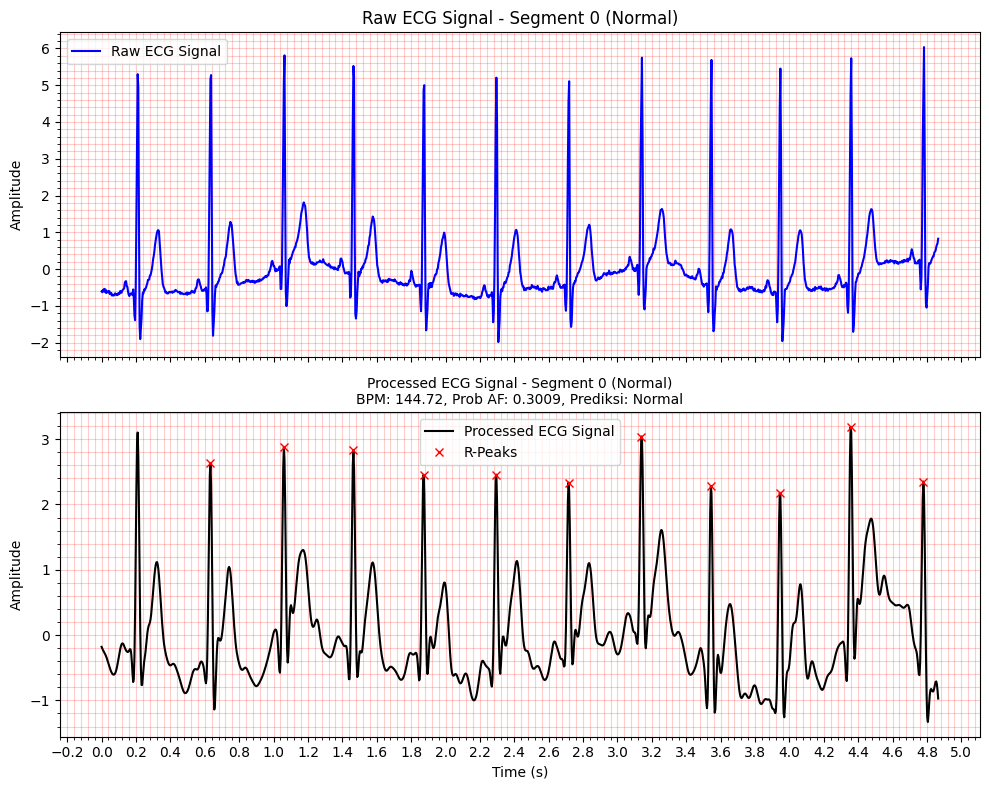

In [2]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import neurokit2 as nk
from scipy.signal import butter, filtfilt, detrend, iirnotch, resample, welch
from scipy.stats import entropy
import pywt

# Required functions (unchanged except for debugging options)
def bandpass_filter(signal, lowcut=0.5, highcut=40.0, fs=267, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def notch_filter(signal, freq=50.0, fs=267, quality=30.0):
    b, a = iirnotch(freq, quality, fs)
    return filtfilt(b, a, signal)

def wavelet_denoise(signal, wavelet='db6', level=5):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    threshold = np.std(coeffs[-1]) * np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)

def compute_rr_features(signal, fs=267, use_entropy=True, visualize=False, segment_idx=0, label='unknown'):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    try:
        # Simpan sinyal asli untuk visualisasi
        signal_raw = signal[:, 0].copy()
        signal_detrended = detrend(signal[:, 0])
        signal_denoised = wavelet_denoise(signal_detrended)
        signal_notched = notch_filter(signal_denoised, freq=50.0, fs=fs)
        signal_filtered = bandpass_filter(signal_notched, lowcut=0.5, highcut=40.0, fs=fs)
        signal_norm = (signal_filtered - np.mean(signal_filtered)) / (np.std(signal_filtered) + 1e-8)
        cleaned = nk.ecg_clean(signal_norm, sampling_rate=fs, method='neurokit')
        rpeaks_info = nk.ecg_findpeaks(cleaned, sampling_rate=fs)
        r_peaks = np.array(rpeaks_info['ECG_R_Peaks'])
        if len(r_peaks) < 2:
            print(f"Peringatan: Hanya {len(r_peaks)} puncak R terdeteksi pada segmen {segment_idx}.")
            return None, None, None, None
        rr_intervals = np.diff(r_peaks) / fs * 1000
        cv_rr = np.std(rr_intervals) / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        qrs_amplitude = np.max(signal_norm) - np.min(signal_norm)
        bpm = 60000 / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        if use_entropy:
            hist, _ = np.histogram(signal_norm, bins=50, density=True)
            signal_entropy = entropy(hist)
            signal_entropy = (signal_entropy - np.mean(hist)) / (np.std(hist) + 1e-8)
        else:
            freqs, psd = welch(signal_norm, fs=fs, nperseg=256)
            signal_entropy = np.sum(psd)
        if visualize:
            visualize_r_peaks(signal_raw, cleaned, r_peaks, label, fs, segment_idx)
        return rr_intervals, [cv_rr, qrs_amplitude, signal_entropy, bpm], r_peaks, cleaned
    except Exception as e:
        print(f"Error deteksi puncak R: {e}")
        return None, None, None, None

def visualize_r_peaks(signal_raw, signal_processed, r_peaks, label, fs=267, segment_idx=0, bpm=None, prob=None):
    if r_peaks is None or len(r_peaks) == 0:
        print("Tidak ada R-peaks untuk divisualisasikan.")
        return
    # Membuat subplot untuk sinyal sebelum dan sesudah preprocessing
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    t = np.arange(len(signal_raw)) / fs
    
    # Plot sinyal sebelum preprocessing tanpa R-peaks
    ax1.plot(t, signal_raw, label='Raw ECG Signal', color='blue')
    ax1.set_title(f'Raw ECG Signal - Segment {segment_idx} ({label})')
    ax1.grid(True, which='both', linestyle='-', alpha=0.2, color='red')
    ax1.minorticks_on()
    ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.04))
    ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax1.yaxis.set_major_locator(ticker.AutoLocator())
    ax1.set_ylabel('Amplitude')
    ax1.legend()

    # Plot sinyal sesudah preprocessing dengan R-peaks
    ax2.plot(t, signal_processed, label='Processed ECG Signal', color='black')
    ax2.plot(t[r_peaks], signal_processed[r_peaks], 'rx', label='R-Peaks')
    title_str = f'Processed ECG Signal - Segment {segment_idx} ({label})'
    if bpm is not None and prob is not None:
        title_str += f'\nBPM: {bpm:.2f}, Prob AF: {prob:.4f}, Prediksi: {label}'
    ax2.set_title(title_str, fontsize=10)
    ax2.grid(True, which='both', linestyle='-', alpha=0.2, color='red')
    ax2.minorticks_on()
    ax2.xaxis.set_minor_locator(ticker.MultipleLocator(0.04))
    ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax2.yaxis.set_major_locator(ticker.AutoLocator())
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Amplitude')
    ax2.legend()

    plt.tight_layout()
    plt.savefig(f'ecg_segment_{segment_idx}_{label}.png', dpi=300)
    plt.show()

def augment_signal(signal, noise_factor=0.1):
    noise = np.random.normal(0, noise_factor, signal.shape)
    scaled_signal = signal * np.random.uniform(0.8, 1.2)
    shifted_signal = scaled_signal + np.random.uniform(-0.2, 0.2)
    return shifted_signal + noise

def normalize_signal(signal):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    signal_norm = (signal - np.mean(signal, axis=0)) / (np.std(signal, axis=0) + 1e-8)
    return signal_norm

def load_and_process_csv(csv_file, segment_length=1300, fs=267, disable_augmentation=False):
    df = pd.read_csv(csv_file)
    signal = df['ECG'].values
    original_fs = 250  # Based on 0.004s interval
    if original_fs != fs:
        target_samples = int(len(signal) * (fs / original_fs))
        signal = resample(signal, target_samples)
    if len(signal) < segment_length:
        print(f"Panjang sinyal ({len(signal)}) kurang dari {segment_length}. Tidak dapat memroses.")
        return None, None, None, None
    segments, rr_features_list, r_peaks_list, cleaned_signals = [], [], [], []
    step = int(segment_length * 0.5)
    for i in range(0, len(signal) - segment_length, step):
        segment = signal[i:i + segment_length]
        if len(segment) != segment_length:
            continue
        segment_norm = normalize_signal(segment)
        segment_augmented = segment_norm if disable_augmentation else augment_signal(segment_norm)
        rr_intervals, features, r_peaks, cleaned_signal = compute_rr_features(segment, fs=fs, visualize=False)
        if rr_intervals is None or features is None:
            continue
        segments.append(segment_augmented)
        rr_features_list.append(features)
        r_peaks_list.append(r_peaks)
        cleaned_signals.append(cleaned_signal)
    if not segments:
        print("Tidak ada segmen yang valid setelah pemrosesan.")
        return None, None, None, None
    segments = np.array(segments)
    rr_features_list = np.array(rr_features_list)
    segments = segments.reshape(segments.shape[0], segment_length, 1)
    return segments, rr_features_list, r_peaks_list, cleaned_signals

def select_best_model(fold_scores, base_path='best_model_lstm_layer_fold_2.h5'):
    if not fold_scores:
        print("Peringatan: fold_scores kosong. Mencoba memuat model dari Fold 2.")
        best_fold = 1
    else:
        best_fold = np.argmax(fold_scores) + 1
    model_path = base_path.format(best_fold)
    if os.path.exists(model_path):
        print(f"Memuat model terbaik dari fold {best_fold} di {model_path}")
        model = load_model(model_path)
        return model, best_fold
    else:
        print(f"Model untuk fold {best_fold} tidak ditemukan di {model_path}")
        return None, None

def predict_with_model(model, scaler, X_test, rr_features_test, threshold=0.5):
    rr_features_norm = scaler.transform(rr_features_test)
    predictions = model.predict([X_test, rr_features_norm], verbose=0)
    predictions_binary = (predictions > threshold).astype(int).flatten()
    return predictions, predictions_binary

# Main execution
csv_file = r'D:\Tugas Akhir\Pemodelan\CNN_LSTM\normal_16773_leadII.csv'  # Ganti dengan path file CSV kamu
segment_length = 1300
fs = 267

# 1. Muat dan proses data CSV
X_test, rr_features_test, r_peaks_test, cleaned_signals = load_and_process_csv(csv_file, segment_length, fs, disable_augmentation=True)
if X_test is None:
    print("Gagal memroses data CSV. Program dihentikan.")
    exit()

print(f"Data CSV diproses: {X_test.shape[0]} segmen")
print(f"RR Features for Segment 0: {rr_features_test[0]}")  # Debug RR features

# 2. Muat scaler dan data yang disimpan
data_dict = joblib.load('processed_data.pkl')
scaler = data_dict['scaler']
print("Scaler dimuat dari 'processed_data.pkl'")

# 3. Pilih model terbaik berdasarkan fold_scores
fold_scores = []  # Ganti dengan daftar fold_scores dari K-Fold CV
model, best_fold = select_best_model(fold_scores)
if model is None:
    print("Gagal memuat model terbaik. Program dihentikan.")
    exit()

# 4. Lakukan prediksi
predictions, predictions_binary = predict_with_model(model, scaler, X_test, rr_features_test, threshold=0.7)

# 5. Tampilkan hasil prediksi
print(f"\nHasil Prediksi untuk {X_test.shape[0]} Segmen:")
for i, (prob, label) in enumerate(zip(predictions.flatten(), predictions_binary)):
    label_str = 'AF' if label == 1 else 'Normal'
    print(f"Segmen {i+1}: Probabilitas AF = {prob:.4f}, Prediksi = {label_str}")

# 6. Visualisasi sinyal dan R-peaks untuk segmen pertama
if X_test.shape[0] > 0:
    label = 'AF' if predictions_binary[0] == 1 else 'Normal'
    bpm = rr_features_test[0][3]
    prob = predictions[0][0]
    visualize_r_peaks(X_test[0].flatten(), cleaned_signals[0], r_peaks_test[0], label, fs=fs, segment_idx=0, bpm=bpm, prob=prob)